<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

#  Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant R. L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes : régression [linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou   [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Industrialisaiton avec le package `caret` et itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision.

**Avertissement** 

* Ce tutoriel est découpé en 5 séances / épisodes de travaux dirigés syncronisées avec le cours d'apprentissage machine. 
* Réfléchir aux réponses aux questions marquées **Q** issues du sujet d'examen.
* Ce calepin est complété par celui en Python (à faire _après_, ou en parallèle) afin de comparer les performances respectives des deux environnements. 

## Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique. 

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester différentes méthodes : régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

Toutes les opérations sont réalisées dans R avec l'appui de bibliothèques complémentaires éventuellement à télécharger (`corrplot, FactoMineR, glmnet, ROCR, mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret, doParallel, xgboost, missForest, Rlof, dbscan, kernlab`). 

Python (consulter le [calepin](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-Python-Ozone.ipynb)) conduit à des résultats comparables mais moins complets pour leur interprétation. En particulier, l'absence du type *DataFrame* dans la librairie scikit-learn n'autorise pas une sélection fine des variables dans les modèles statistiques usuels. En revanche, l'exécution de la validation croisée Monte Carlo est plus rapide en python.

# <FONT COLOR="Red"> Épisode 1 </font>
<FONT COLOR="Red"> 2022-02-09 </font>

## Prise en charge des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** : type de jour ; férié (1) ou pas (0) ;
* **O3obs** : concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** : température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** : rapport d'humidité ;
* **NO2** : concentration en dioxyde d'azote ;
* **NO** : concentration en monoxyde d'azote ;
* **STATION** : lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** : force du vent ;
* **VentANG** : orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention**: Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

In [1]:
library(corrplot)

corrplot 0.92 loaded



In [2]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# Vérification du contenu
summary(ozone)

      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [3]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

## Exploration élémentaire

Remarquer le type des variables. Il est nécessaire d'en étudier la distribution. Noter la symétrie ou non de celles-ci .

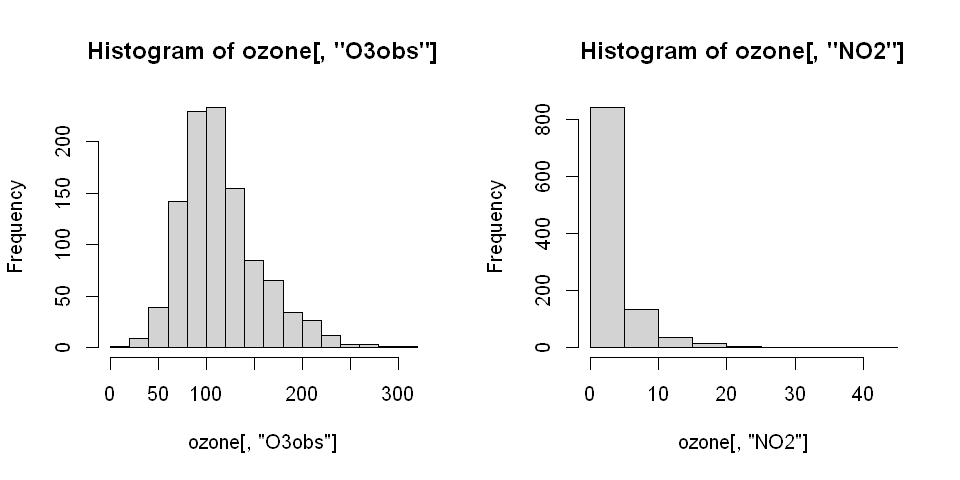

In [4]:
par(mfrow = c(1, 2))
options(repr.plot.width = 8, repr.plot.height = 4)
hist(ozone[, "O3obs"])
hist(ozone[, "NO2"])

On remarque que O3obs ressemble à une distribution normale (mais pas tout à fait symétrique) tandis que NO2 ressemble à une distribution exponentielle. 

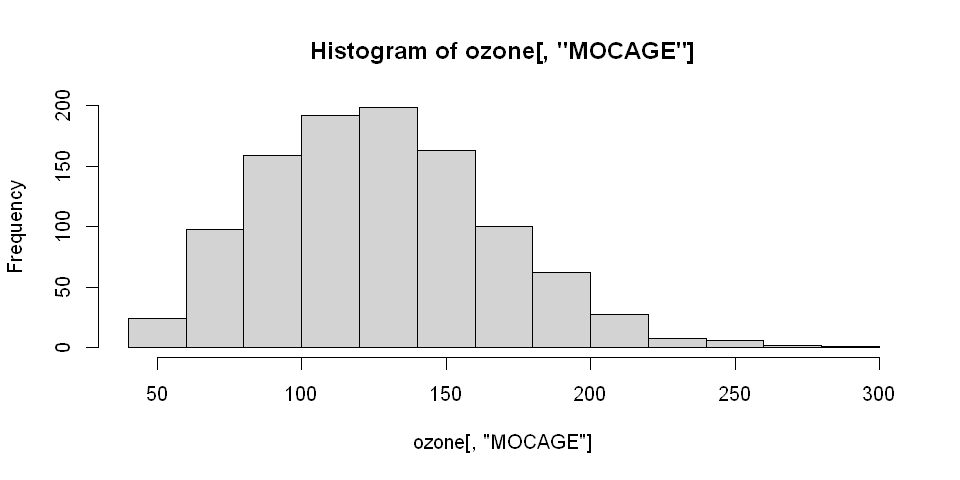

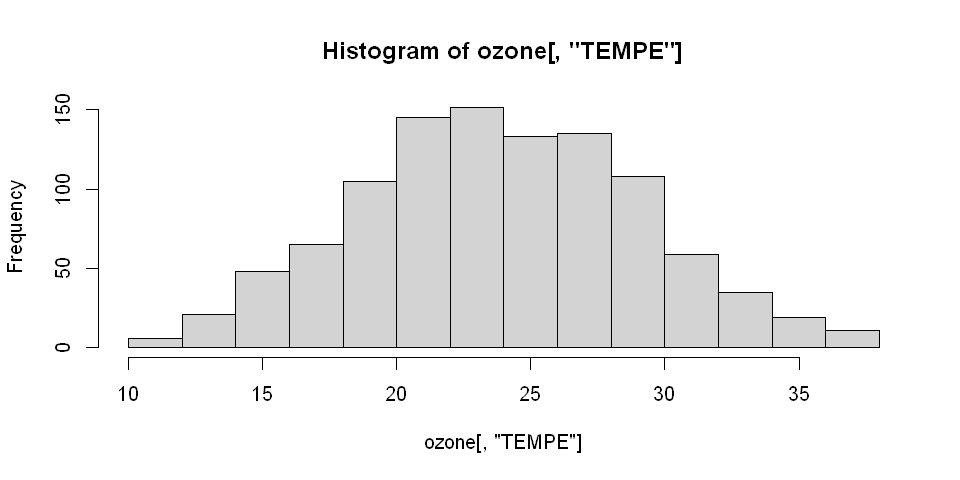

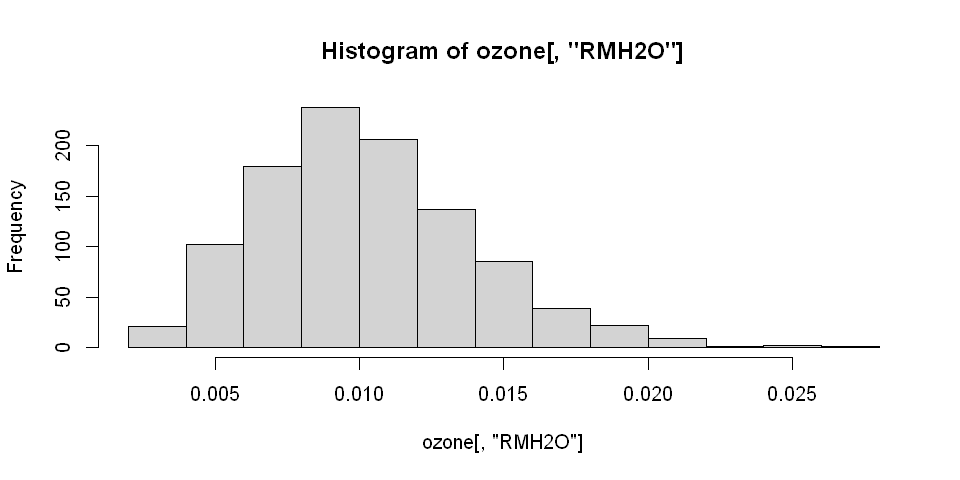

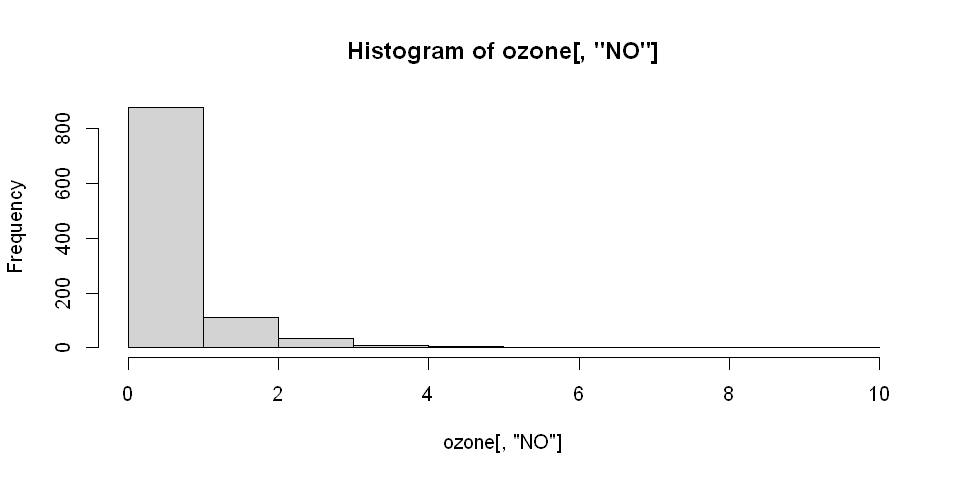

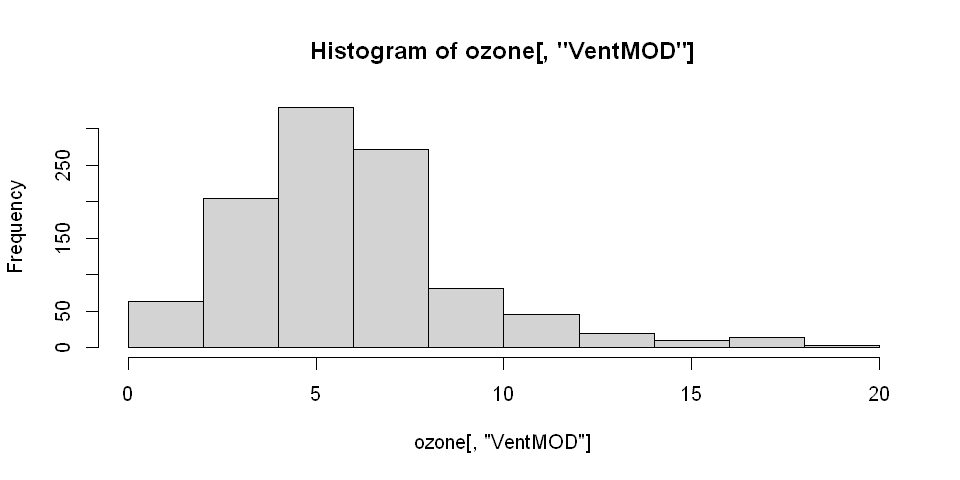

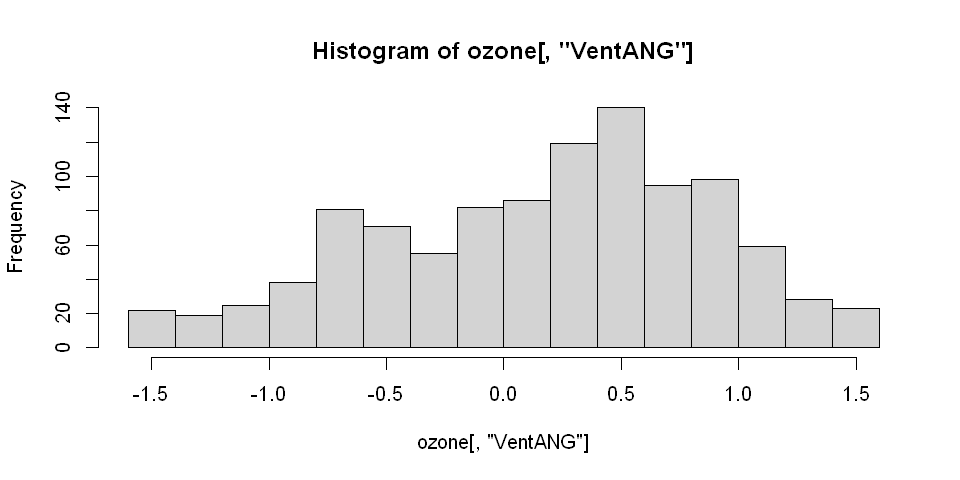

In [5]:
# Même chose pour les autres variables
 hist(ozone[,"MOCAGE"]);hist(ozone[,"TEMPE"]);hist(ozone[,"RMH2O"])
#
hist(ozone[,"NO"]);hist(ozone[,"VentMOD"]);hist(ozone[,"VentANG"])

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir de modélisation (linéaires), par pour toutes (arbres).

In [6]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

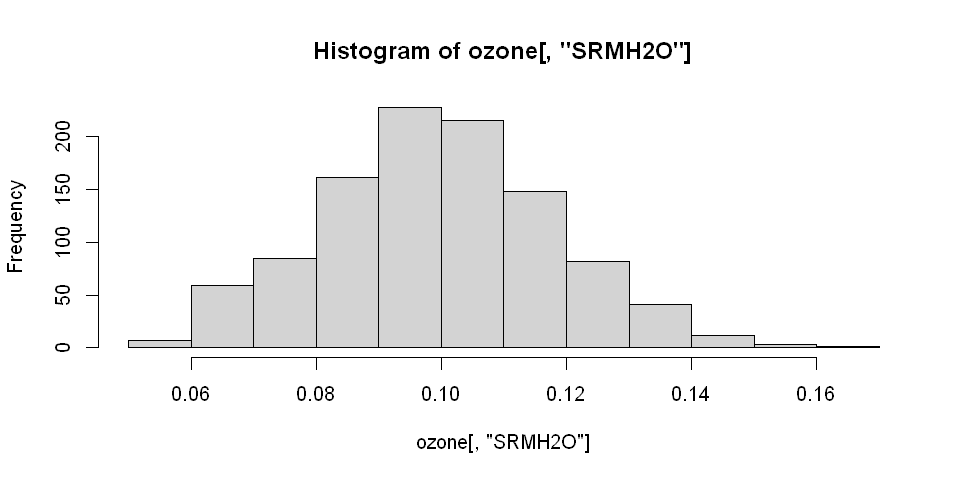

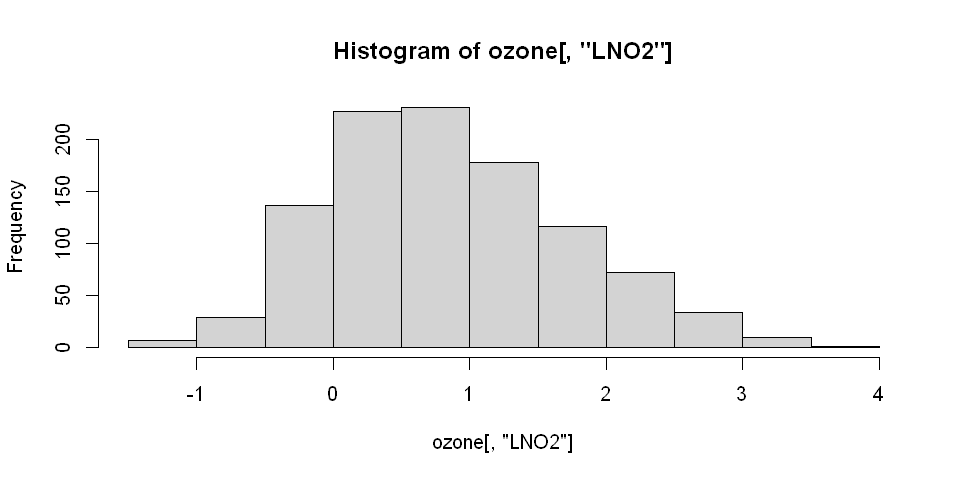

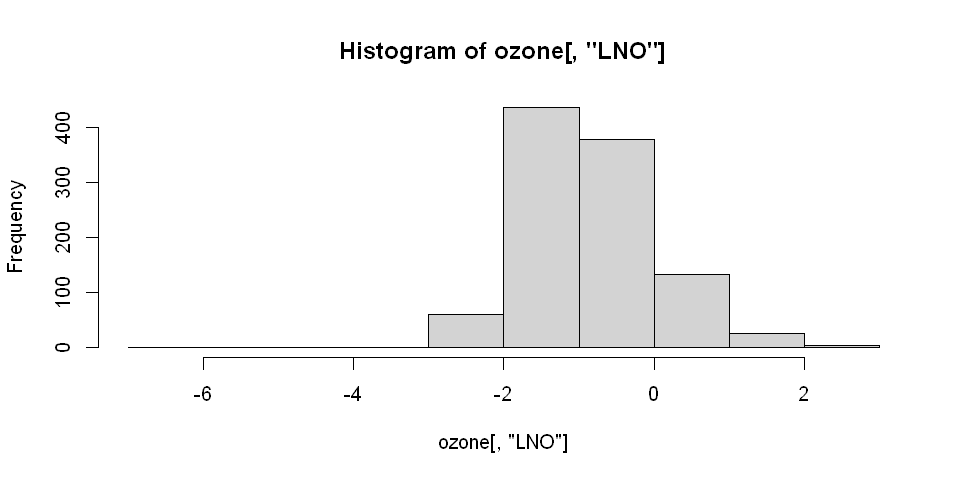

In [7]:
hist(ozone[,"SRMH2O"]);hist(ozone[,"LNO2"]);hist(ozone[,"LNO"])

Vérifier l'opportunité de ces transformations puis retirer les variables initiales et construire la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.


In [8]:
ozone <- ozone[, c(1:4, 8:13)]
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

On crée une variable DepSeuil qui prend la valeur 1 si la concentration de O3obs a depassé le seuil de danger fixé à 150. 
On utilisera soit les variables binaire DepSeuil pour faire de la regression logistique ou les variables quantitatives O3obs pour faire de la regression: 2 façons d'étudier l'ozone. 

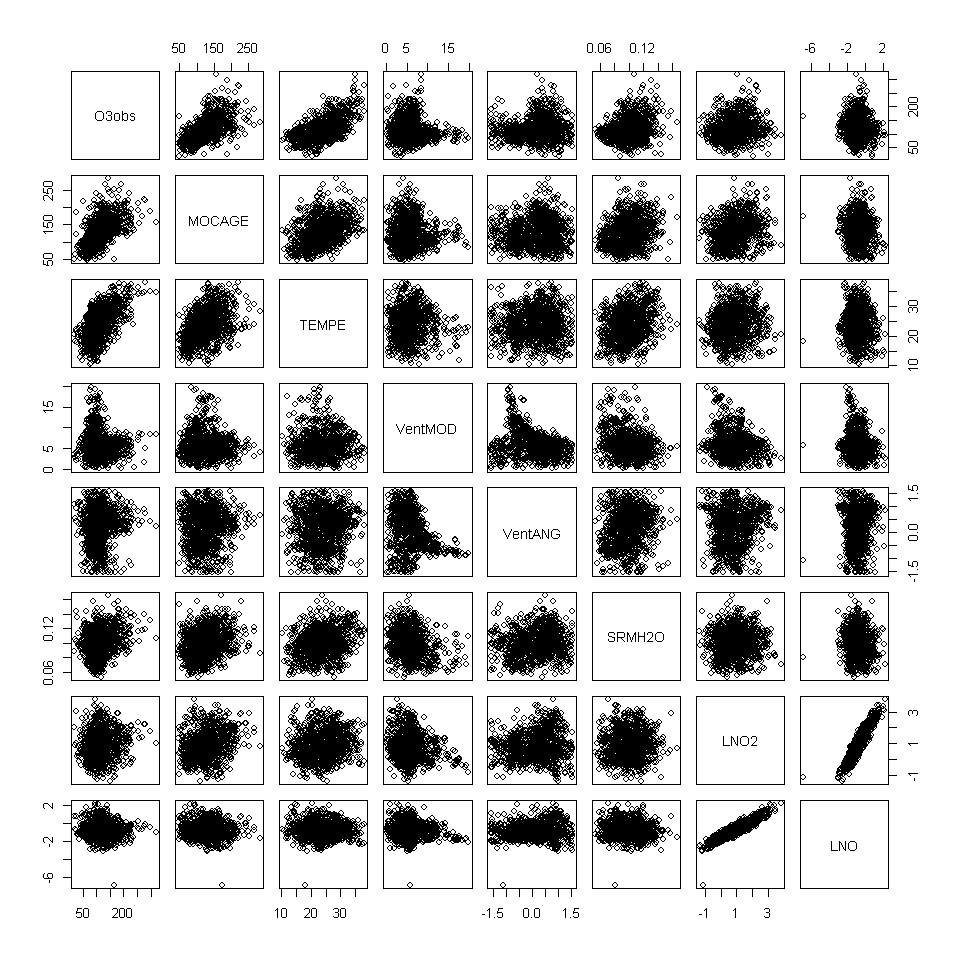

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
pairs(ozone[, c(2:4, 6:10)]) # A matrix of scatterplots is produced 

**Q** Que dire sur les relations des varibles 2 à 2 ?

On observe pour certaines variables des relations linéaires. Par exemple, entre LNO2 et LNO. De plus, certaines semblent indépendantes par ex : LNO avec toutes les variables sauf LNO2. Ceci se voit lorsque le nuage de point est vertical ou horizontal. 

**Q** Compléter en visualisant les corrélations avec la fonction 'corrplot' (package `corrplot`). Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ? 

Cela confirme les interprétations précédents. On observe une forte corrélation entre LNO2 et LNO et entre MOCAGE TEMPE et O3obs. On observe une faible corrélation entre LNO et l'ensemble des variables (sauf LNO2). 

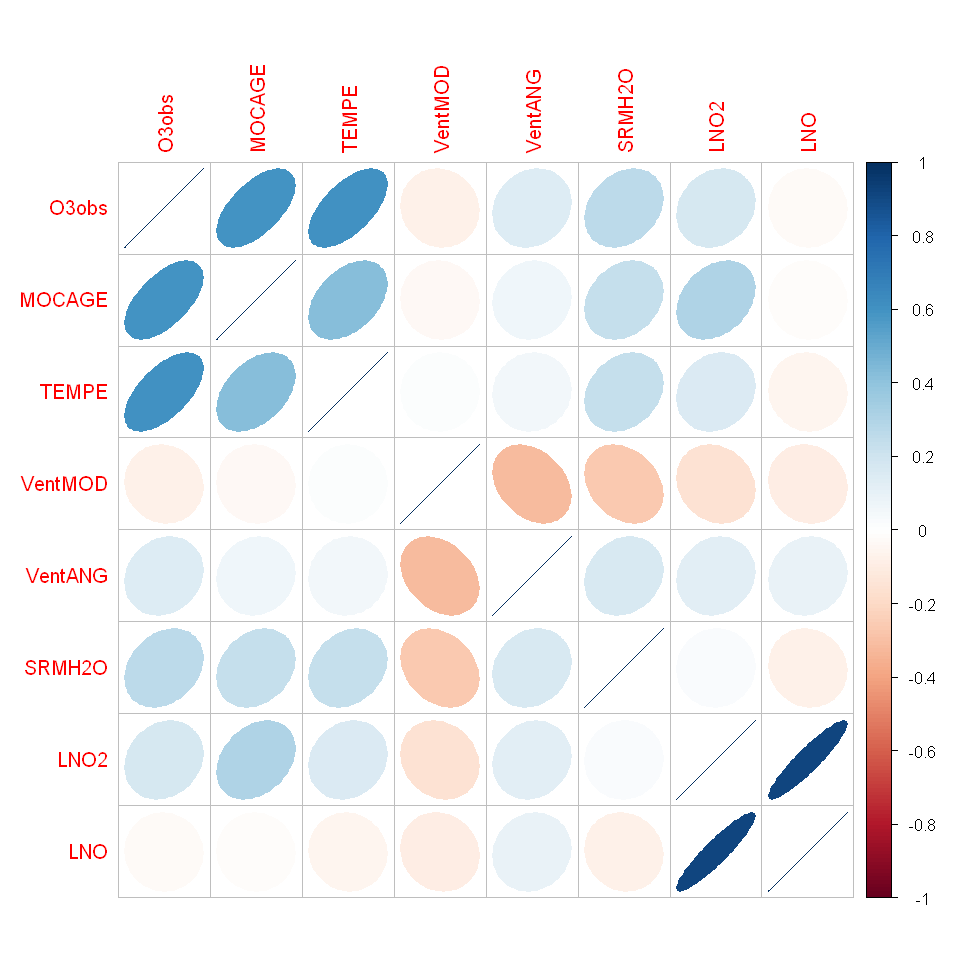

In [10]:
correlation <-cor(ozone[, c(2:4, 6:10)])
corrplot(correlation, method = "ellipse")

Les commandes suivantes permettent de réaliser une [analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) sur les seules variables quantitatives. Par ailleurs la variable à modéliser  (O3obs, concentration observée) n'est pas utilisée.

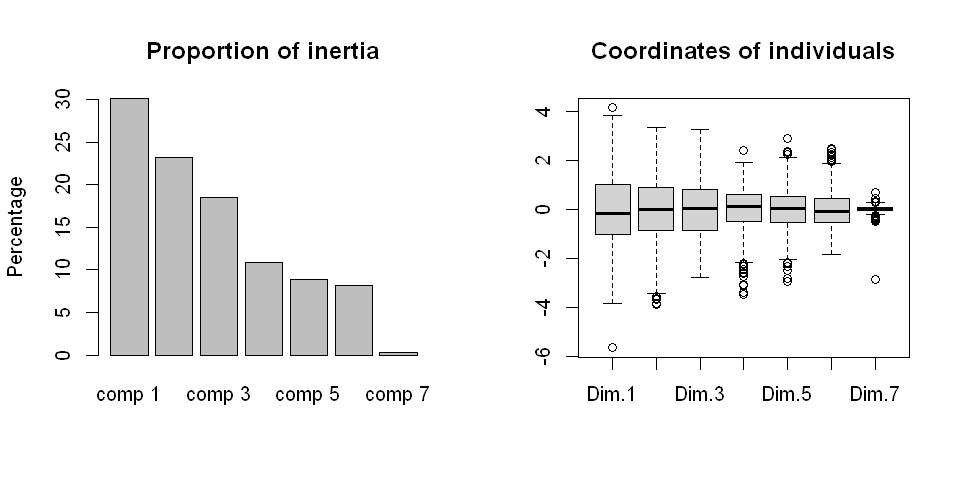

In [11]:
# ACP réduite
# Décroissance des valeurs propres
library(FactoMineR)
acp <- PCA(ozone[, c(11,2:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7) 
#quali.sup = 1 c'est la première colonne (ici 11) du dataframe ozone qui est une variable supplémentaire qualitative 
# c'est DepSeuil (11 deviant la première colonne)
#quanti.sup = 2 c'est la dexième colonne (ici 2) du dataframe ozone qui est une variable supplémentaire quantitative
# c'est O3obs  

options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
barplot(acp$eig[, 2], ylab = "Percentage", main = "Proportion of inertia")
boxplot(acp$ind$coord, main = "Coordinates of individuals")

In [12]:
summary(ozone[, c(11,2:4, 6:10)])

  DepSeuil       O3obs           MOCAGE          TEMPE          VentMOD       
 FALSE:863   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Min.   : 0.1414  
 TRUE :178   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   1st Qu.: 3.9623  
             Median :109.0   Median :125.6   Median :23.80   Median : 5.5973  
             Mean   :115.4   Mean   :127.2   Mean   :23.88   Mean   : 5.9072  
             3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   3rd Qu.: 7.1063  
             Max.   :319.0   Max.   :284.7   Max.   :38.00   Max.   :19.8910  
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215   1st Qu.:-1.4439  
 Median : 0.2783   Median :0.09925   Median : 0.7462   Median :-0.9467  
 Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440   Mean   :-0.8399  
 3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017   3rd Qu.:-0.2957  
 Max.   :

In [13]:
help(PCA)

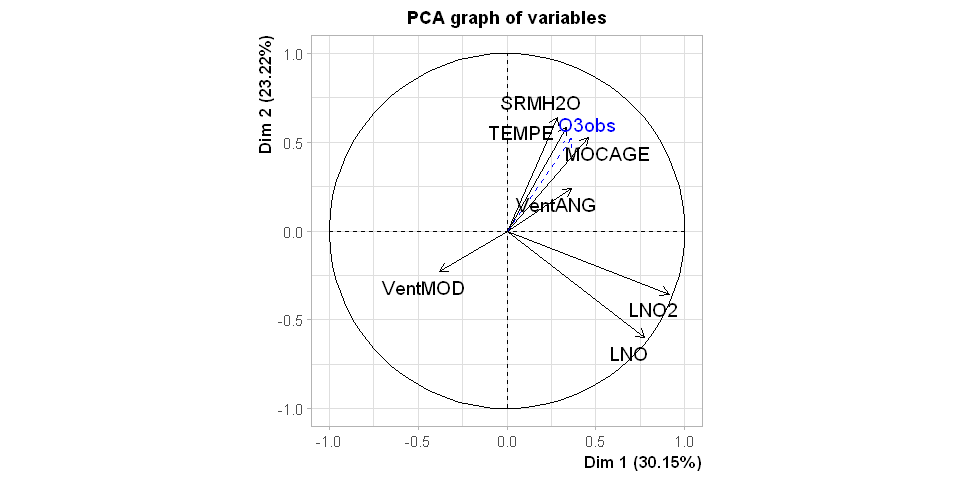

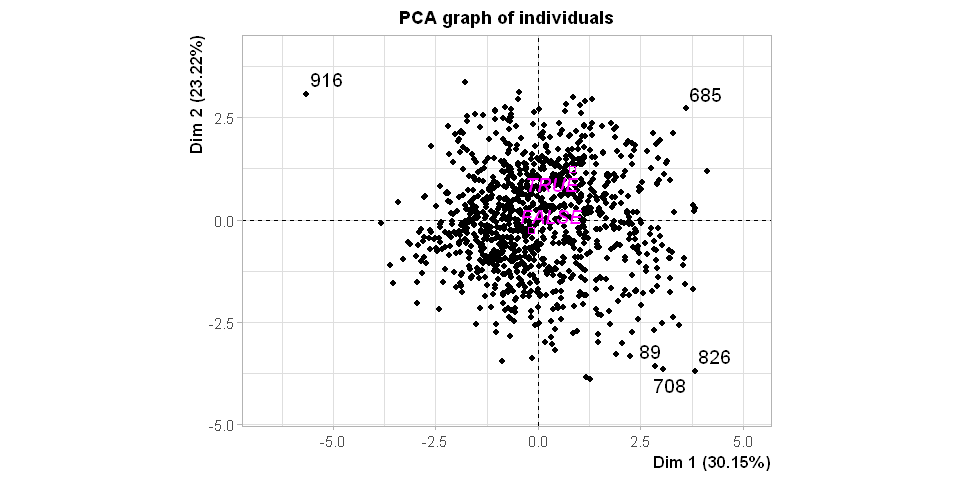

In [14]:
plot(acp, choix = "varcor")
plot(acp, choix = "ind", select = "contrib 5", unselect = 0)

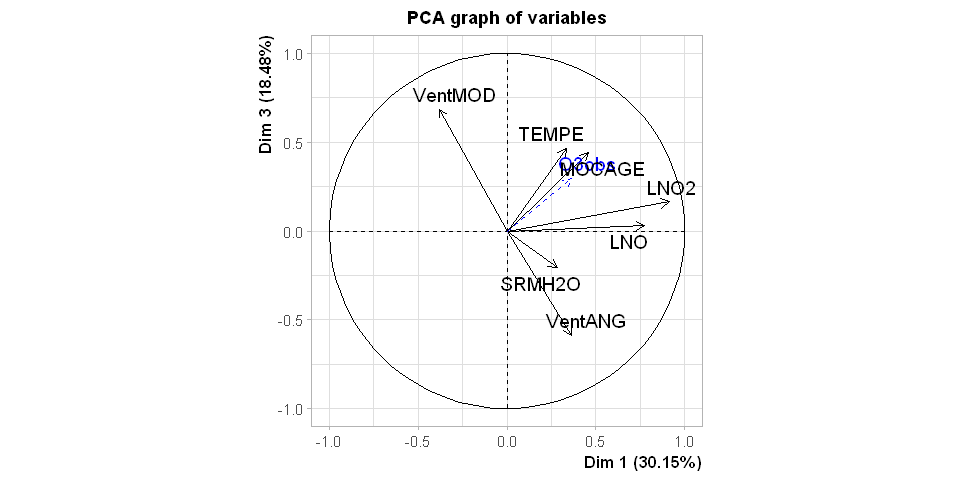

In [15]:
plot(acp, choix = "varcor",axes = c(1,3)) #pour plot en fonction des autres dimensions (1 et 2 par défaut)

In [16]:
ozone[c(916,685,826,708,89),] #outliers
summary(ozone)    

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
916,1,166,173.5,18.2,Pla,5.77060,-1.08390,0.08093207,-1.114742,-6.9077553,TRUE
685,0,276,223.5,34.7,Ram,1.70294,0.86854,0.13917615,2.207285,-0.2678794,TRUE
826,0,96,91.2,20.5,Ram,2.54950,0.84090,0.07141428,3.793149,2.2437900,FALSE
708,1,96,96.1,15.2,Ram,3.15753,0.19118,0.08573214,3.345790,2.0228712,FALSE
89,0,106,81.4,14.5,Aix,0.94340,-0.55860,0.09843780,3.113338,2.1415944,FALSE


 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

**Q** Que sont ces graphiques?
Le premier graphique est le graphique de corrélation des variables. Il montre les relations entre toutes les variables. Il peut être interprété comme suit:
- Les variables positivement corrélées sont regroupées.
- Les variables négativement corrélées sont positionnées sur les côtés opposés de l’origine du graphique (quadrants opposés).
- La distance entre les variables et l’origine mesure la qualité de représentation des variables. Les variables qui sont loin de l’origine sont bien représentées par l’ACP.

Sur ce graphe on peut voir quelles sont les variables qui sont corrélées avec la variable à expliquer (O3obs).

Le 2e graphique est la projection des individus sur la PC1 (dim1) et la PC2 (dim2) (principal component). 

**Q** Que dire du choix de la dimension, des valeurs atypiques?
On représente la dimension 1 contre la 2 car ceux sont celles qui portent le plus d'information. 
On remarque que l'outlier 826 correspond au max de LNO2. 
Remarque : Quand on fait une analyse de données il faut repérer les outliers au début et les enlever pour ne pas fausser l'analyse. 

**Q** Que dire de la structure de corrélation des variables ? Est-elle intuitive ?

Même graphe en coloriant les dépassement de seuil.

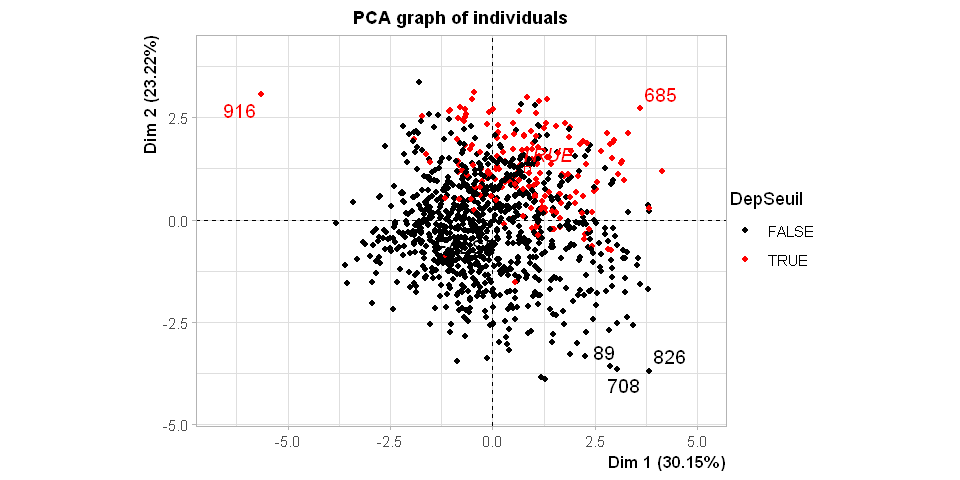

In [17]:
plot(acp, choix = "ind", habillage = 1,
     #habillage = 1 sélectionne la première variabl du dataframe pour colorer ici DepSeuil.
     select = "contrib 5", unselect = 0) #select = "contrib 5" : 5 valeurs les plus atypiques

In [18]:
help(plot)

L'objectif est donc de définir une surface séparant les deux classes. 

**Q** Une discrimination linéaire (hyperplan) semble-t-elle possible? 
Les points ne sont pas assez séparés pour faire une séparation. 


Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir. Par exemple en 2 classes, par l'algorithme k-means. Donne t-elle la même information ?

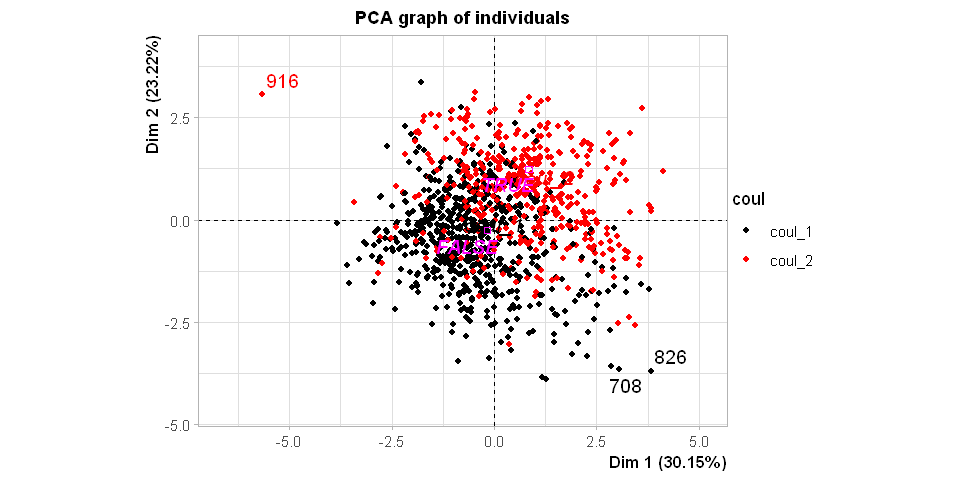

In [19]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2) # crée 2 clusters abev les colonnes 3:4 et 6:10
# Représentation dans les coordonnées de l'acp
acp2 <- PCA(cbind(coul = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE, #rajoute col 11 (DepSeuil) pour colorier en fonction des clusters
          graph = FALSE, quali.sup = 1:2, ncp = 7) # quali.sup = 1:2 -> MOCAGE et TEMP deviennent les colonnes 1 et 2
plot(acp2, choix = "ind", habillage = "coul",
     select = "contrib 3", unselect = 0)

## Protocole de comparaison

### Stratégie

La recherche  d'une meilleure méthode de prévision suit le protocole suivant.

1. Étape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf):
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.

**Q** Commenta appelle-t-on cette procédure spécifique de validation croisée?

<FONT COLOR="blue">K-fold cross validation

# <FONT COLOR="Red">A RETENIR : ERREUR AJUSTEMENT=ERREUR D'APPRENTISSAGE ≠ erreur de généralisation/prédiction/sur les données test</font>

<FONT COLOR="blue">Le but du jeu de la validation croisée est de moyenner l'erreur sur des données qui n'ont pas servi à l'apprentissage. On fait cela V fois (le nombre de folds) dans le but de diminuer la variance. Pour chaque fold v, on apprend le modèle sur $D_{apprentissage}$\ $D_v$ et estime l'erreur de généralisation sur $D_v$. On obtient V estimations d'erreur, donc on fait ensuite la moyenne. La validation croisée va permettre de choisir les paramètres optimaux pour la construction du modèle (exemple : choix du $\lambda$ dans la méthode du LASSO).

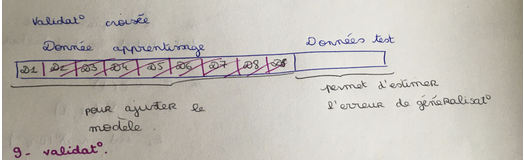

<FONT COLOR="blue"> ATTENTION : on utilise JAMAIS les données test sauf à la fin pour choisir le meilleur modèle parmi tous les modèles testés. 

* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test. 

Utiliser trois chiffres au hasard, et **remplacer** "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de ne pas obtenir les mêmes modèles, les mêmes résultats.

In [20]:
set.seed(121) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(ozone) # nombre de lignes dans les données
nvar <- ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

In [21]:
help(setdiff)

<FONT COLOR="blue"> Cette étape est très importante : permet de calculer l'erreur de généralisation/prédiction. On va le faire sur des données qui n'ont pas servi à l'apprentissage de notre modèle erreur ajustement : erreur sur les données qui ont servi à l'apprentissage DIFFERENTE erreur de généralisation : on évalue l'erreur sur des données qui n'ont pas servi à l'apprentissage. et c'est cette erreur qu'on veut minimiser.

<FONT COLOR="blue"> 
Construction des échantillons pour la régression: prévision de la concentration en ozone.

<FONT COLOR="blue"> Rq : - si on enlève O3obs (quantitative) on fait une méthode de classification : regression logistique
- si on enlève depseuil (qualitative)  on fait une méthode de regression 

<FONT COLOR="blue"> Ici on commence par enlever Depseuil et on garde O3obs. En apprentissage supervisée on garde les entrées et les orties. 

In [22]:
# construction de l'échantillon d'apprentissage
datappr <- ozone[appri, -11] #-11 : on enlève la variable depseuil
# construction de l'échantillon test
datestr <- ozone[testi, -11] 
# vérification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	832 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 2 2 1 1 ...
 $ O3obs  : int  91 100 82 107 150 164 135 121 129 118 ...
 $ MOCAGE : num  93.2 104.6 103.6 99 114.3 ...
 $ TEMPE  : num  21.5 20.2 17.4 23.7 23.6 26.6 23.5 23.3 23.7 22.2 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 7.88 6.31 ...
 $ VentANG: num  -0.6435 -0.05 -0.1283 -0.4182 0.0634 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0855 0.1087 ...
 $ LNO2   : num  0.471 0.752 0.505 0.503 1.671 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.794 0.295 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 2 2 1 1 1 ...
 $ O3obs  : int  103 87 133 95 149 87 183 148 118 99 ...
 $ MOCAGE : num  158.4 76.1 147.1 98.2 128.2 ...
 $ TEMPE  : num  13.8 18.2 18.9 21.1 28.3 21.6 25.1 27.6 21.5 14.2 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 4 5 4 4 2 3 1 3 3 5 ...
 $ VentMOD: num  7

Construction des échantillons pour la discrimination: prévision de dépassement.

In [23]:
# construction de l'échantillon d'apprentissage
datappq <- ozone[appri,-2] #-2 : on enlève la variable O3obs
# construction de l'échantillon test 
datestq <- ozone[testi,-2] 

# vérification
str(datappq)
str(datestq)
#summary(datappq)

'data.frame':	832 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 2 2 1 1 ...
 $ MOCAGE  : num  93.2 104.6 103.6 99 114.3 ...
 $ TEMPE   : num  21.5 20.2 17.4 23.7 23.6 26.6 23.5 23.3 23.7 22.2 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD : num  9.5 8.01 9.38 7.88 6.31 ...
 $ VentANG : num  -0.6435 -0.05 -0.1283 -0.4182 0.0634 ...
 $ SRMH2O  : num  0.092 0.0939 0.0975 0.0855 0.1087 ...
 $ LNO2    : num  0.471 0.752 0.505 0.503 1.671 ...
 $ LNO     : num  -0.858 -0.633 -0.761 -0.794 0.295 ...
 $ DepSeuil: Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 2 1 1 1 1 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 2 2 1 1 1 ...
 $ MOCAGE  : num  158.4 76.1 147.1 98.2 128.2 ...
 $ TEMPE   : num  13.8 18.2 18.9 21.1 28.3 21.6 25.1 27.6 21.5 14.2 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 4 5 4 4 2 3 1 3 3 5 ...
 $ VentMOD : num  7.77 4.96 7.76 19.33 1.91 ...
 

Enfin, avant de passer aux différents algorithmes, définissons une fonction traçant le graphe des résidus avec des couleurs et des échelles fixes sur les axes. 

In [24]:
options(repr.plot.width = 8, repr.plot.height = 4)
# Définition d'une fonction pour un graphe coloré et des échelles fixes sur les
# axes
plot.res <- function(x, y, titre = "titre") {
    plot(x, y, col = "blue", xlim = c(0, 250), ylim = c(-100, 100), ylab = "Résidus", 
        xlab = "Valeurs prédites", main = titre, pch = 20)
    # points(x2, y, col='red')
    abline(h = 0, col = "green")
}

## [Prévision par modèle gaussien](http://wikistat.fr/pdf/st-m-app-select.pdf)

Le premier modèle à tester est un simple modèle de régression linéaire mais, comme certaines variables sont qualitatives, il s'agit d'une analyse de covariance. D'autre part, on s'intéresse à savoir si des interactions sont à prendre en compte. Le modèle devient alors polynomial d'ordre 2 ou quadratique.

### Modèle linéaire

#### Sans sélection de variables

Le modèle de régression linéaire simple intégre des variables qualitatives; c'est dans ce cas une *analyse de covariance*  estimée par la fonction `aov` mieux adaptée à ce modèle.

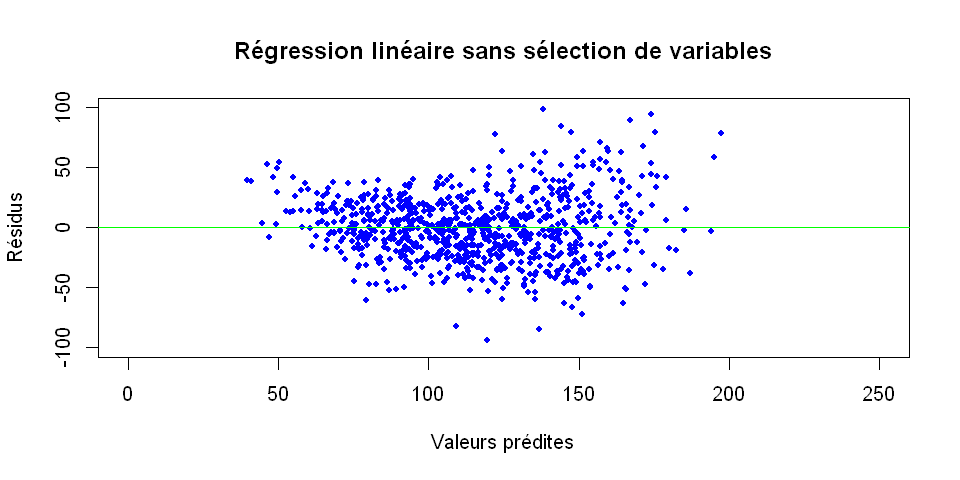

In [25]:
# estimation du modèle sans interaction
reg.lm <- aov(O3obs ~ . , data = datappr) #data sans Depseuil

# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Graphe des résidus. 
plot.res(fit.lm,res.lm,"Régression linéaire sans sélection de variables")

**Q1** Que dire de la distribution de ces résidus? 

**Q** La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle?

Q1 :


<FONT COLOR="blue"> - On observe que le nuages des individus a une forme en entonoir sur le graphe de regression linéaire, cela signifie que leur variance augmente avec Y => hétérocédasticité. 
    
<FONT COLOR="blue"> - On observe aussi une forme courbe dans le nuage donc il y a toujours une tendance => il va falloir appliquer une transformation quadratique sur les données pour éliminer la tendance. 

<FONT COLOR="blue"> Remarque : si les points étaient répartis de manière aléatoire nos données seraient bonnes. 

Apprécier néanmoins sa significativité par la commande suivante.

In [26]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1     43      43   0.053 0.817199    
MOCAGE        1 468729  468729 582.628  < 2e-16 ***
TEMPE         1 243969  243969 303.252  < 2e-16 ***
STATION       4  16701    4175   5.190 0.000393 ***
VentMOD       1  11706   11706  14.551 0.000147 ***
VentANG       1  10277   10277  12.774 0.000372 ***
SRMH2O        1   1221    1221   1.518 0.218302    
LNO2          1   2430    2430   3.021 0.082585 .  
LNO           1  10871   10871  13.513 0.000252 ***
Residuals   819 658892     805                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [27]:
coef(reg.lm)

(Intercept)       JOUR1      MOCAGE       TEMPE  STATIONAls  STATIONCad 
-21.0604331   0.3611302   0.3935837   4.4156222   3.0043767  10.3544354 
 STATIONPla  STATIONRam     VentMOD     VentANG      SRMH2O        LNO2 
 22.7603279   5.5494771  -1.2490149   4.4419684  83.2444145 -16.5907801 
        LNO 
 18.8201286

**Q** Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?

<FONT COLOR="blue">  Rappel : **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes)

<FONT COLOR="blue"> Ici on considère pour les résidus datappr[,"MOCAGE"] - datappr[,"O3obs"] car on veut regarder la différence entre le modèle déterministe et les sorties observées. 

<FONT COLOR="blue"> On voit que notre modèle statistique avec toutes les variables améliore le modèle déterministe car dans le premier nuage de points on observe un grand biais qui n'est plus présent dans le deuxième graphique. Les résidus de notre modèle statistiques sont plus faibles. 
    
<FONT COLOR="blue"> ==> On a un graphe de résidus. On veut un nuage de point proche de 0. A gauche modèle déterministe. A droite, modèle aléatoire (en utilisant d'autres paramètres) il y a pas d'hétéroscédasticité mais une sorte de banane apparait toujours (remet en cause l'hypithèse de linéarité. Cependant c'est quand meme mieux que celui de gauche. 

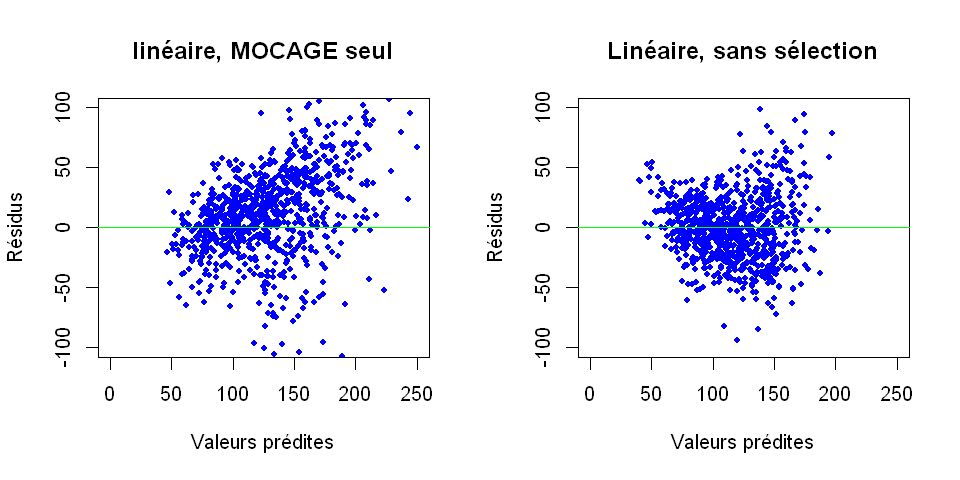

In [28]:
# Graphe des résidus du modèle déterministe MOCAGE
par(mfrow = c(1, 2))
plot.res(datappr[, "MOCAGE"],
         datappr[, "MOCAGE"] - datappr[, "O3obs"], "linéaire, MOCAGE seul")
plot.res(fit.lm, res.lm, "Linéaire, sans sélection")
par(mfrow = c(1, 1))

#### Sélection de variable par régularisation L1 (LASSO)

Le chargement a nécessité le package : Matrix

Loaded glmnet 4.1-3



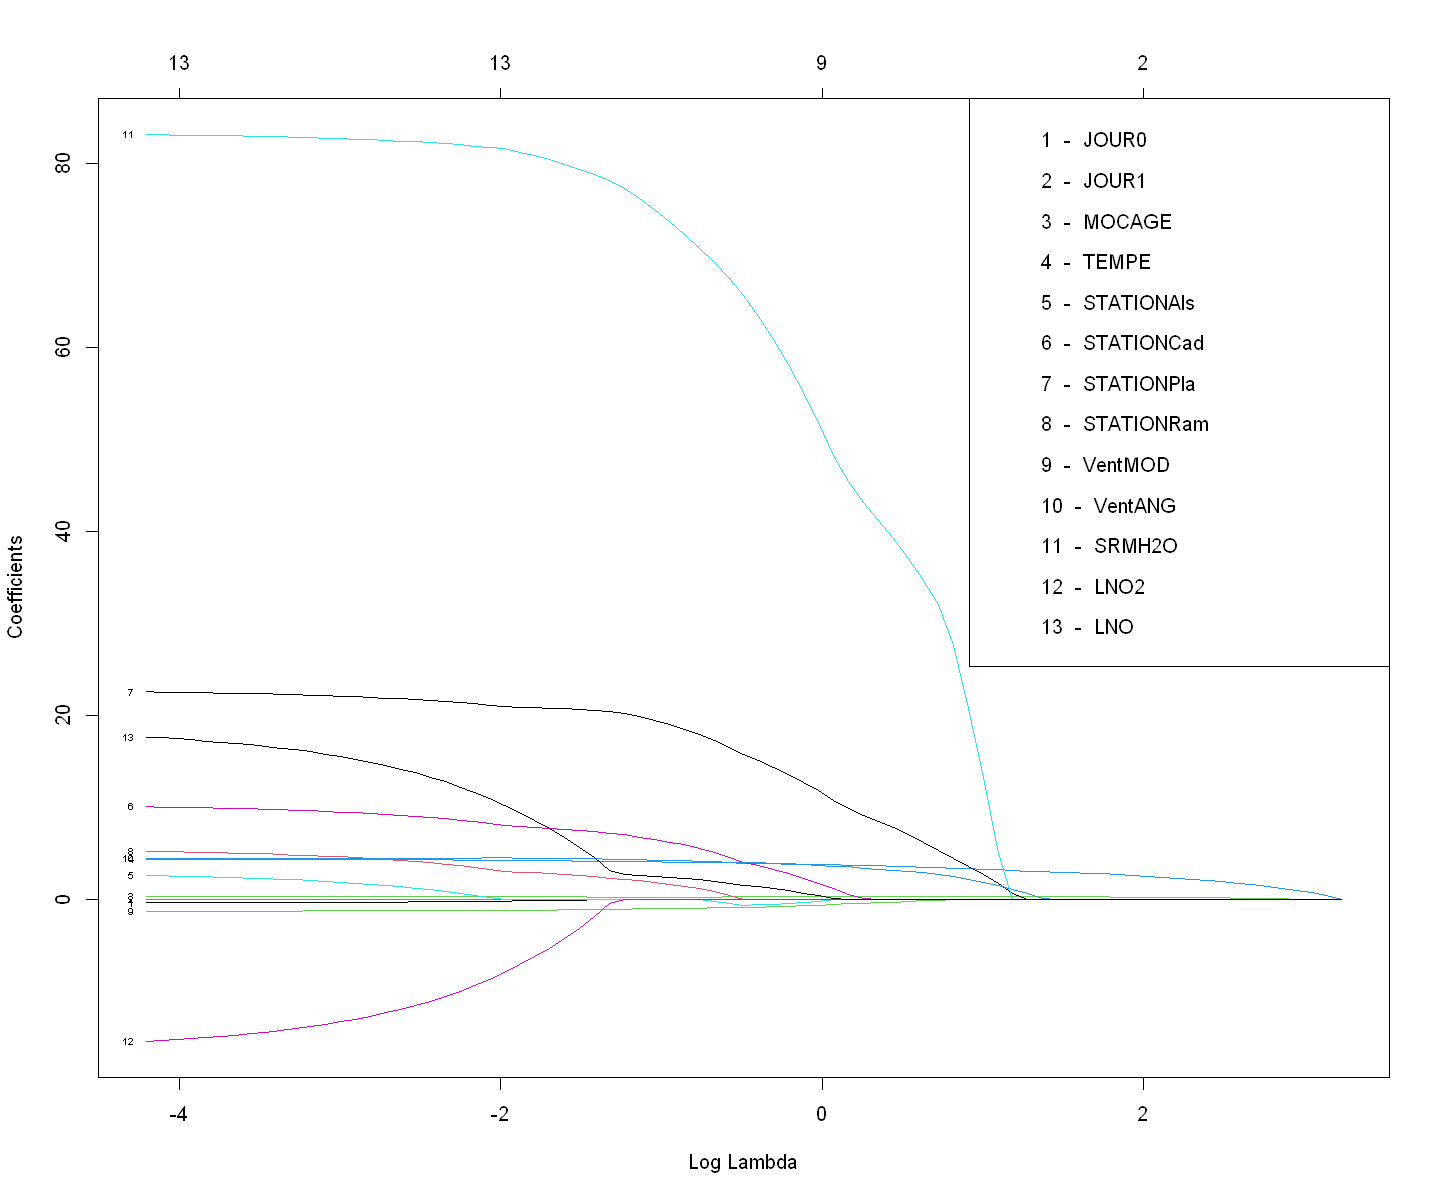

In [29]:
library(glmnet)
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)])) #enlève Jour et Station (variables qualitatives) + O3obs (valeur à prédire)
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(O3obs ~ . - 1, data = datappr) #-1 : on enlève l'intercept car dans la regression de Lasso on ne pénalise pas l'intercept (Beta0) 
                                                    #sinon on aurait des solutions dépendantes dez la position d'origine
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

#abline(v=log(lambda_min), col="blue")
#abline(v=log(lambda.1se), col="red")

In [30]:
head(x.mat)

,JOUR0,JOUR1,MOCAGE,TEMPE,STATIONAls,STATIONCad,STATIONPla,STATIONRam,VentMOD,VentANG,SRMH2O,LNO2,LNO
1,0,1,93.2,21.5,0,0,0,0,9.5000,-0.64350,0.09203260,0.4712528,-0.8580218
2,0,1,104.6,20.2,0,0,0,0,8.0100,-0.04996,0.09386160,0.7518877,-0.6329933
3,1,0,103.6,17.4,0,0,0,0,9.3771,-0.12832,0.09751923,0.5050087,-0.7614260
5,1,0,99.0,23.7,0,0,0,0,7.8791,-0.41822,0.08549854,0.5025918,-0.7940731
6,1,0,114.3,23.6,0,0,0,0,6.3127,0.06341,0.10871982,1.6707211,0.2949059
7,1,0,127.7,26.6,0,0,0,0,4.8042,0.04164,0.09679876,1.0441561,-0.5978370


**Q** Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?

<FONT COLOR="blue"> La commande model.matrix crée une matrice dans laquelle les variables qualitatives sont séparées par modalités, et pour garder un modèle régulier on met la première variable dans l'intercept. Les colonnes de modalités ne contiennent plus que des 0 et des 1 selon si la modalité considérée est présente sur l'élément observé. Cela permet de transformer les variables qualitatives en variables quantitatives (c'est à dire avec des indicatrices)
    
<FONT COLOR="red"> BE CAREFUL : pour les variables qualitatives deux cas à traiter différemment :
    * si il y a un intercept : on est obligé de mettre à 0 une modalité pour chaque variable qualitative (pour éviter le surajustement et ça n'enlève pas d'information car on peut retrouver l'indicatrice de la modalité enlevée en regardant la modalité de toutes les autres modalités 
    * si il n'y a pas d'intercept : on est obligé de mettre pour toutes les variables qualitatives une modalité à 0 sauf pour une des variables qualitatives (pour pas que le modèle ne soit surparamétré et que l'on soit plus dans le cas régulier) : ici on voit bien qu'on a conservé toutes les modalités de JOUR et qu'on a supprimé une des modalités de station (il y en avait 5 de base et plus que 4 dans le tableau)
    
<FONT COLOR="blue"> x.mat <- model.matrix(O3obs ~ . - 1, data = datappr) crée le modèle qui explique O3obs en fonction de toutes les autres variables, et en enlevant l'intercept. On utilise les données datappr dans lesquelles on a enlevé Depseuil. 

**Q** Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?

<FONT COLOR="blue">Ces courbes représentent l'annulation des coefficients de notre modèle ne fonction de la valeur de lambda. Plus lambda augmente plus on a de coefficient nuls, LASSO permet d'obtenir un estimateur sparse.  
    deuxième version #Meli Ce graphique représente le chemin de régularisation : 
Pour chaque log $\lambda$ on a l'estimation des paramètres du modèle $\widehat{\beta}$. 
Plus $\lambda$ augmente plus des paramètres vont être estimés à 0, car plus la pénalité prend du poids, et plus on augmente donc la sparsité. 
Chaque courbe c'est une variable dans $\widehat{\beta}$ 

[1] 826.7938

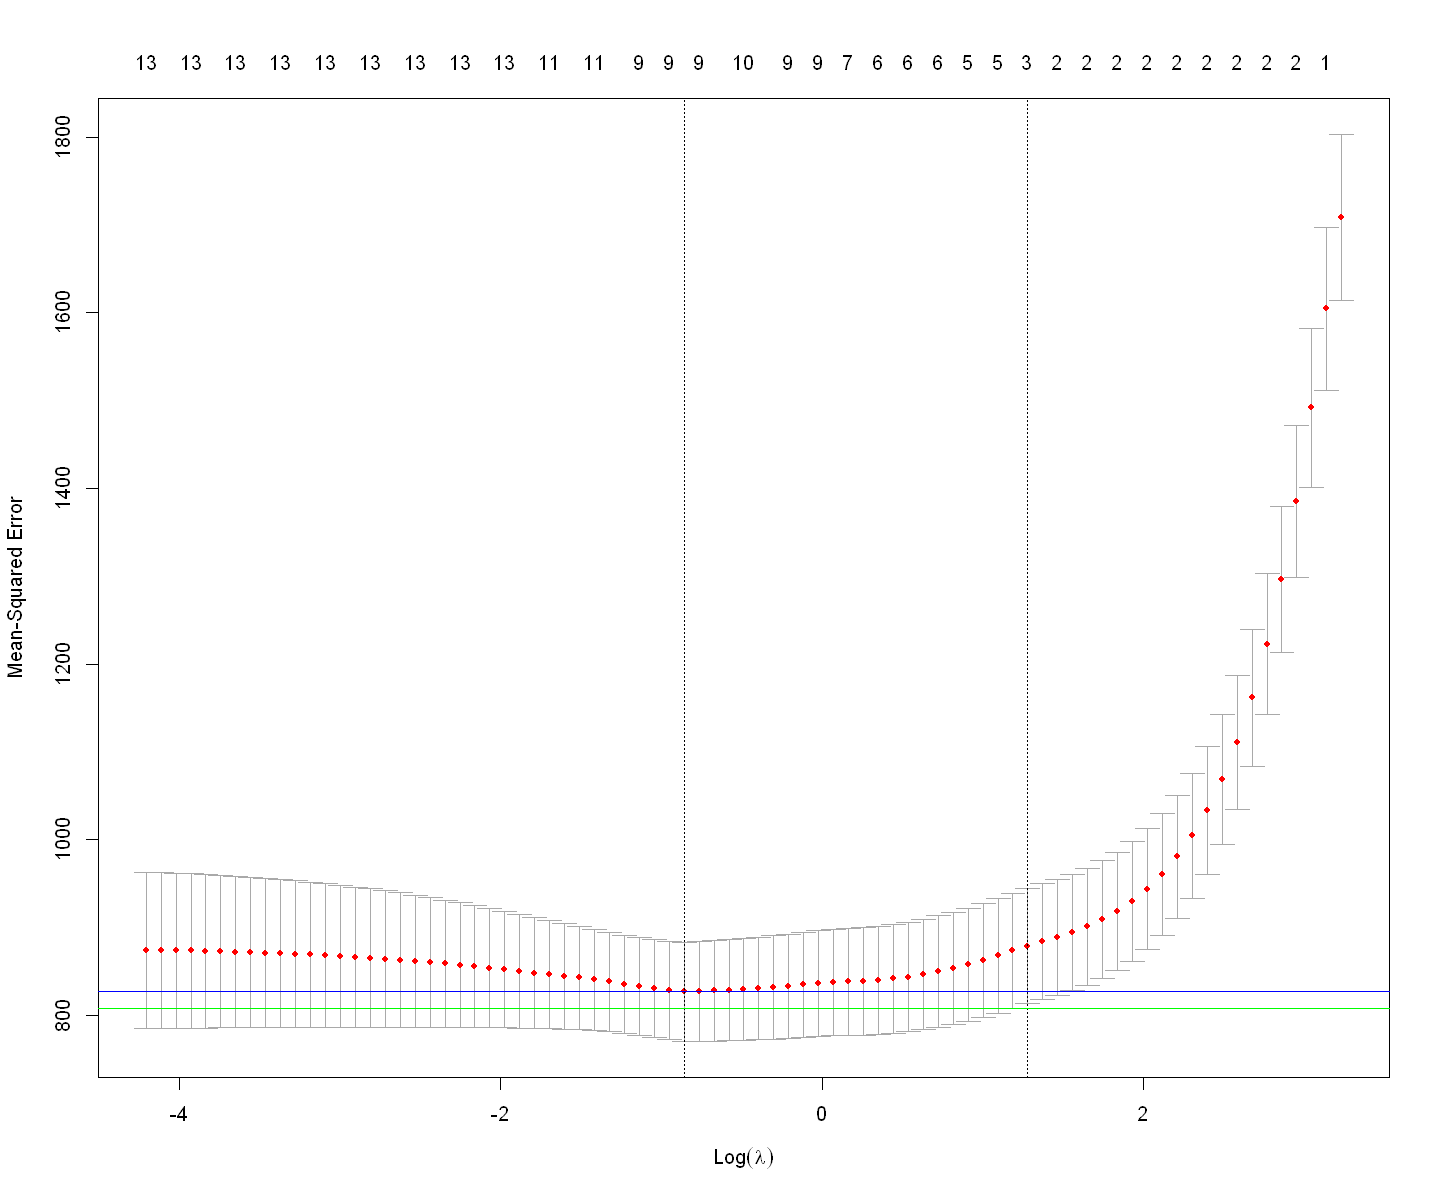

In [31]:
#install.packages("plotrix") # Install plotrix R package
library("plotrix") 
# choix du paramètre de régularisation par validation croisée
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
plot(reg.lasso.cv)

min(reg.lasso.cv$cvm) 

#on récupère les valeurs des points rouge (valeur moyenne des erreurs de régularisation)
abline(h=min(reg.lasso.cv$cvm), col="blue")

#on trace la tangente horizontale associée au min des moyennes des erreurs de généralisation
abline(h=min(reg.lasso.cv$cvm)-std.error(reg.lasso.cv$cvm), col="green")
#lambda.1se : largest value of lambda such that error is within 1 standard error of the minimum.

In [32]:
library(glmnet)
help(cv.glmnet) #cross-validation for glmnet
# cv : Does k-fold cross-validation for glmnet, produces a plot, and returns a value for lambda

**Q** Que représente la courbe rouge ? Et la bande qui est autour ? 

<FONT COLOR="blue"> Le nombre de folders est à 10 par défaut !!! 
Interprétation : on trace les IC en gris associés aux 10 erreurs de généralisation pour chaque $\lambda$. 

<FONT COLOR="blue"> - En rouge : moyenne des erreurs estimées par la validation croisée. cvm = moyenne des erreurs de validation croisée sur les 10 folds = les points rouges

  <FONT COLOR="blue">  - Bande autour = intervalle de confiance autour de la moyenne

**Q** Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?
      
<FONT COLOR="blue">- 1ère ligne en pointillé = La valeur de lambda pour laquelle la moyenne est la plus petite.
    
<FONT COLOR="blue"> - 2ème ligne en pointillé = la valeur de lambda telle que l'erreur reste en dessous du minimum + un écart type => c'est pas l'erreur minimale mais elle reste raisonnable. 

<FONT COLOR="blue"> $\textbf{comment choisir $\lambda$ ?}$
    SELON L'OBJECTIF
    
   <FONT COLOR="blue"> -on choisit $\lambda_{min}$ si on veut diminuer l'erreur de généralisation ==> C'est celui pour lequel la valeur de la moyenne des erreurs de généralisation associé aux différents $\lambda$. $\textbf{SI le but est de prédire en diminuant l'erreur du modèle}.$

<FONT COLOR="blue">-on choisit $\lambda_{SE}$ si on prend le plus grand lambda tel que la valeur minimale de la moyenne appartienne encore à l'intervalle de confiance (on prend le $\lambda$ le plus grand tel que la droite bleue passe dans l'IC). $\textbf{SI le but est de prédire bien tout en diminuant le nombre de variables (expliquer le modèle)}$

In [33]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se") #lambda.1se = largest value of lambda such that error is within 1 standard error of the minimum.

[1] "CV estimate of lambda : 3.602"

14 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) -2.1964412
JOUR0        .        
JOUR1        .        
MOCAGE       0.3379639
TEMPE        3.0928979
STATIONAls   .        
STATIONCad   .        
STATIONPla   .        
STATIONRam   .        
VentMOD      .        
VentANG      0.6453645
SRMH2O       .        
LNO2         .        
LNO          .        

**Q** Combien restent-ils de coefficients non nuls. Vérifier sur les chemins de régularisation.

<FONT COLOR="blue">  Il y a 3 coefficients non nuls pour cette valeur de lambda. Cela correspond sur le graphe au lambda repéré par la 2ème ligne en pointillés. 

**Q** Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. "reg.lasso.cv$lambda.min"

<FONT COLOR="blue">  Il y a 9 coefficients non nuls pour cette valeur de lambda. Cela correspond sur le graphe au lambda repéré par la 1ère ligne en pointillés.


<FONT COLOR="blue"> ==> Cela confirme le fait que si on utilise $\lambda_{min}$ on prédit au mieux mais on garde beaucoup de variables, alors que si on utilise le $\lambda_{1SE}$ on va supprimer beaucoup plus de variables donc simplifier le modèle en ayant une erreur de généralisation un peu moins bonne. 
Dans le cas de $\lambda_{min}$, on a que seule une variable est mise à 0. logique car LO2 et LO étaient liées donc on peut en enlever une. 

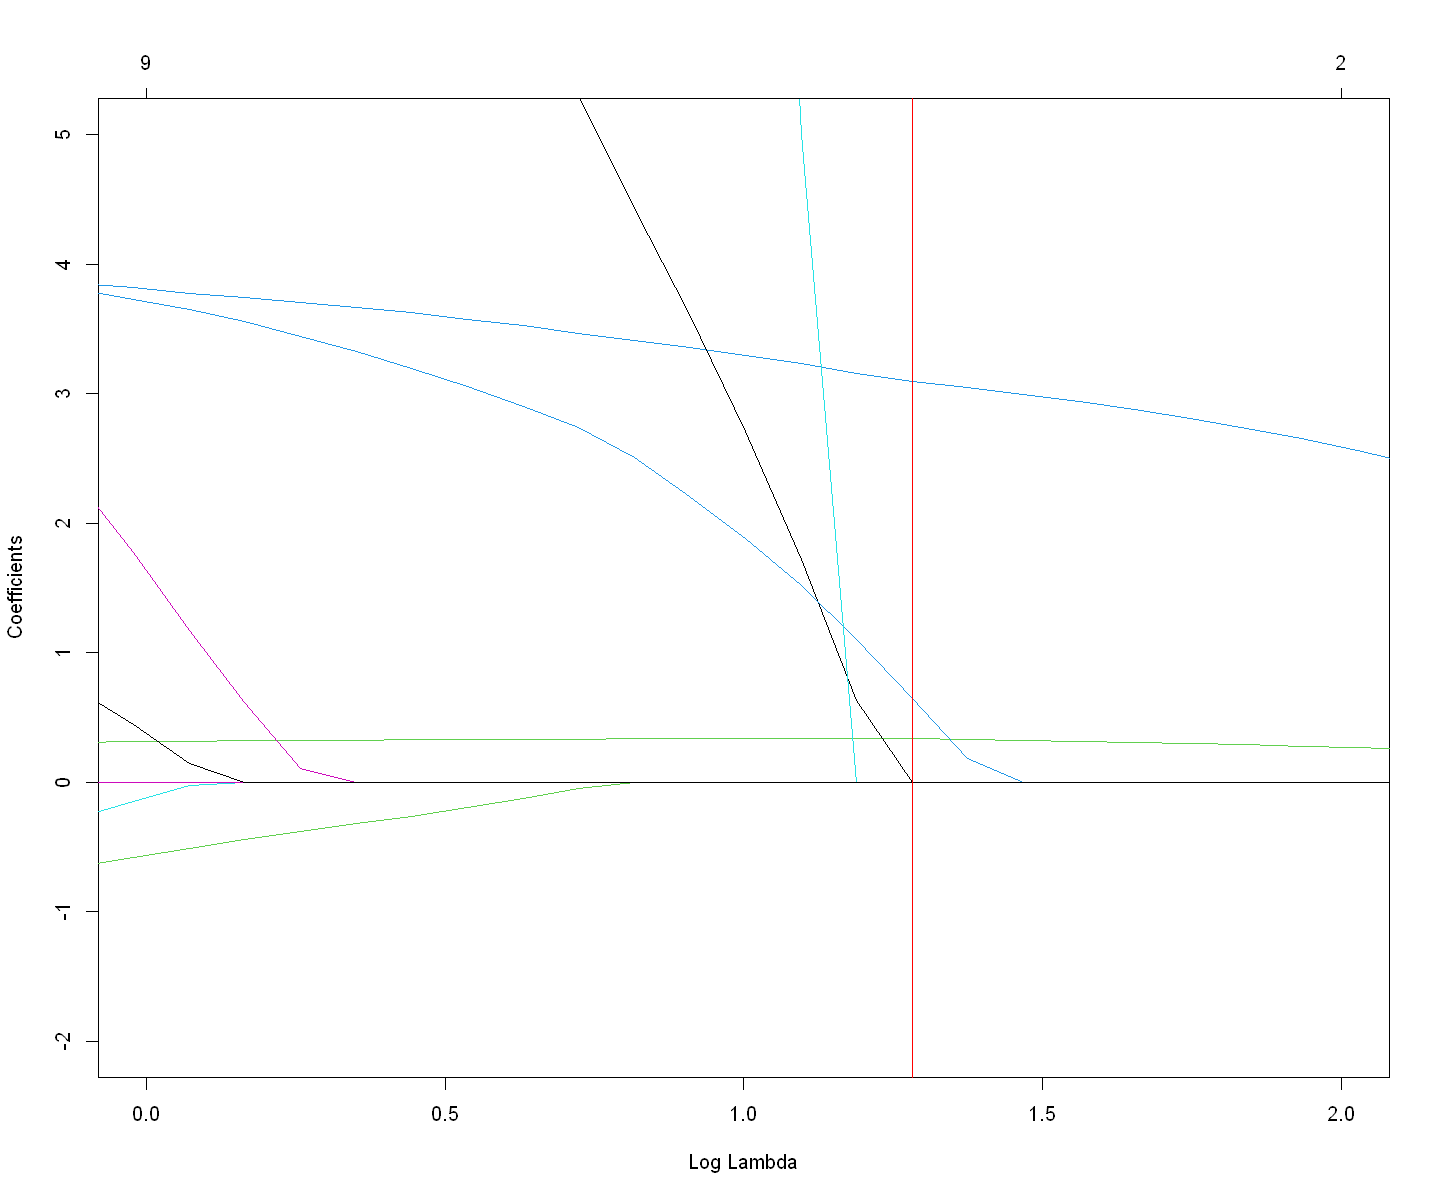

In [34]:
# NEW : 
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(0,2),ylim=c(-2,5))
abline(v=log(reg.lasso.cv$lambda.1se),col="red")

[1] "CV estimate of lambda : 0.424"

14 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -24.4690938
JOUR0         .        
JOUR1         .        
MOCAGE        0.2862437
TEMPE         4.0703522
STATIONAls    .        
STATIONCad    5.9478709
STATIONPla   18.5089831
STATIONRam    1.4652904
VentMOD      -0.9435600
VentANG       4.2237961
SRMH2O       72.2905963
LNO2          .        
LNO           2.2975046

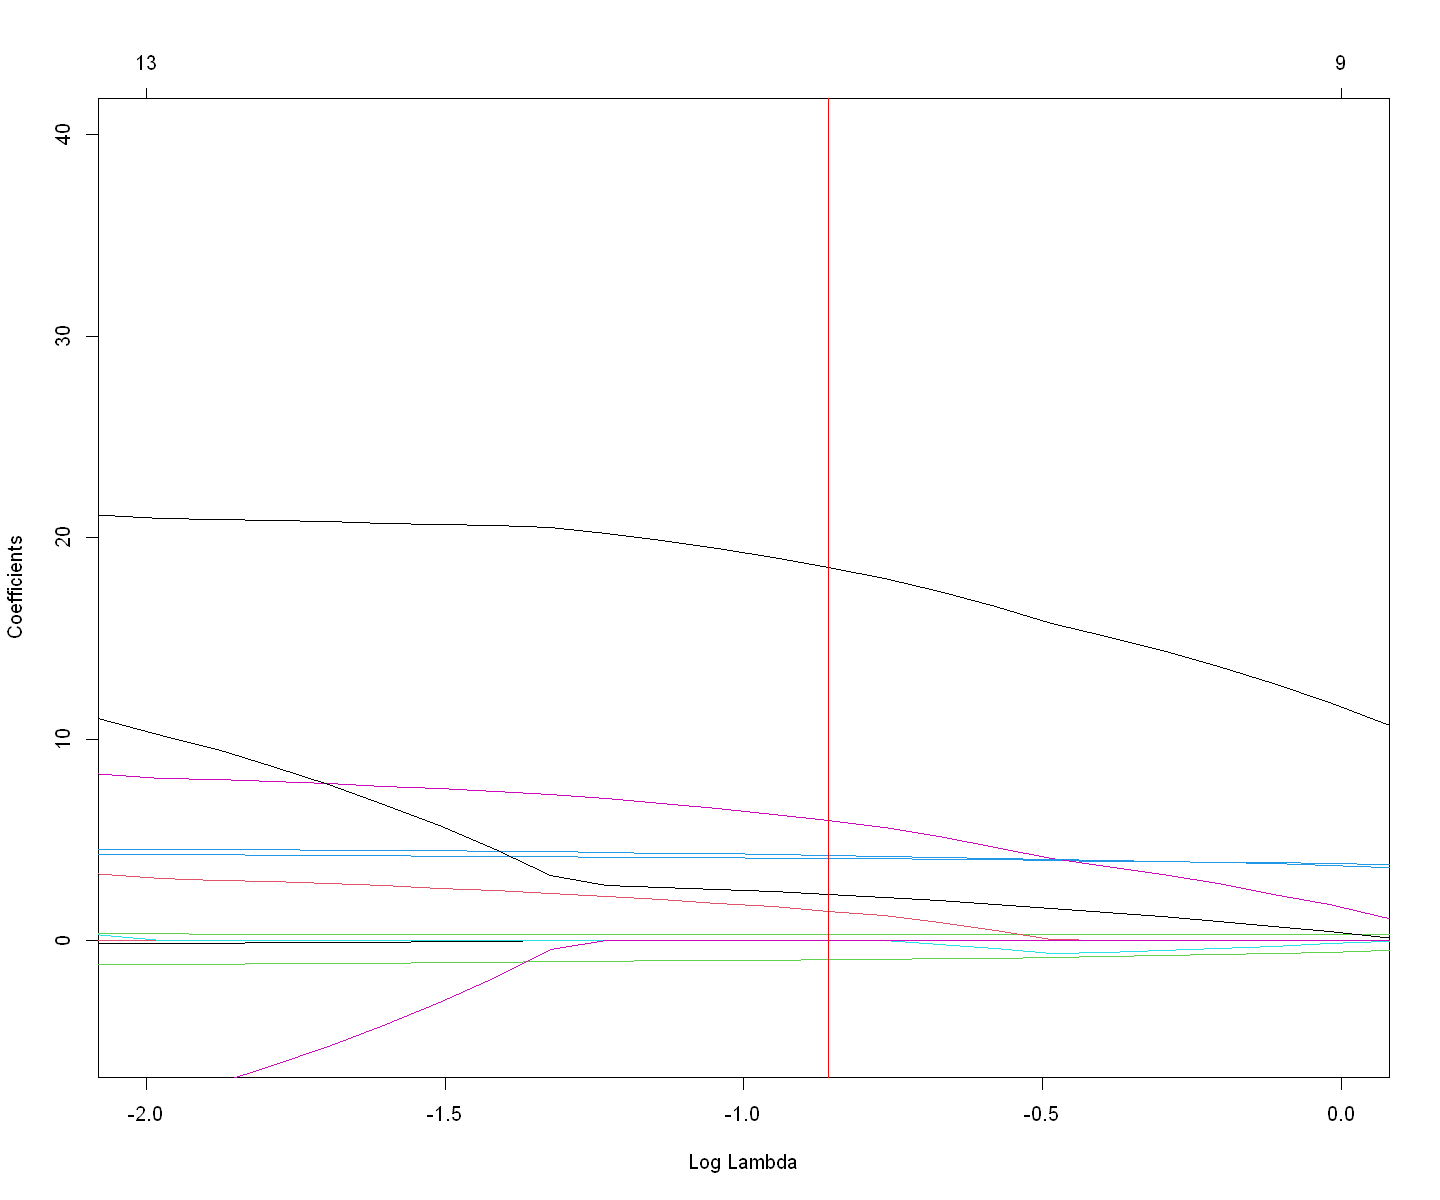

In [35]:

# NEW : 
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.min")

plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(-2,0),ylim=c(-5,40))
abline(v=log(reg.lasso.cv$lambda.min),col="red")

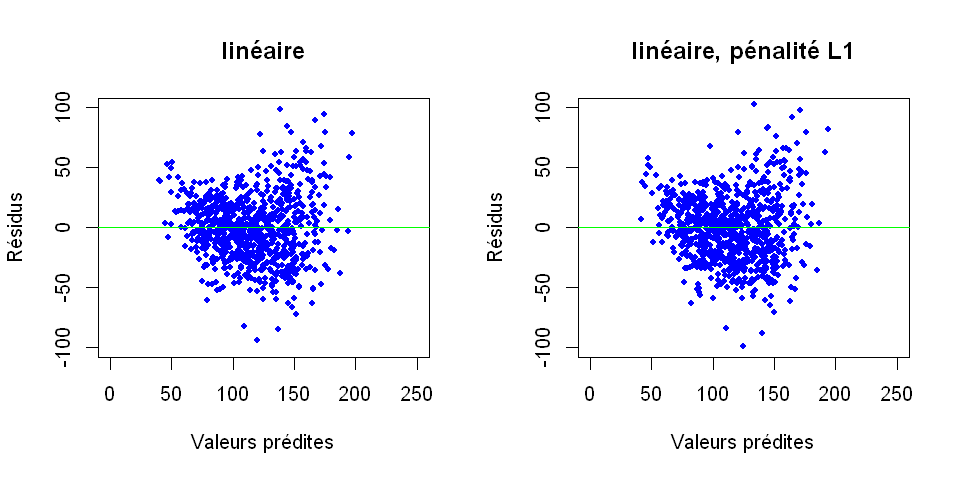

In [36]:
# Extraction des valeurs ajustées et des résidus
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso #résidus obtenus avec le modèle sélectionné par LASSO
# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")

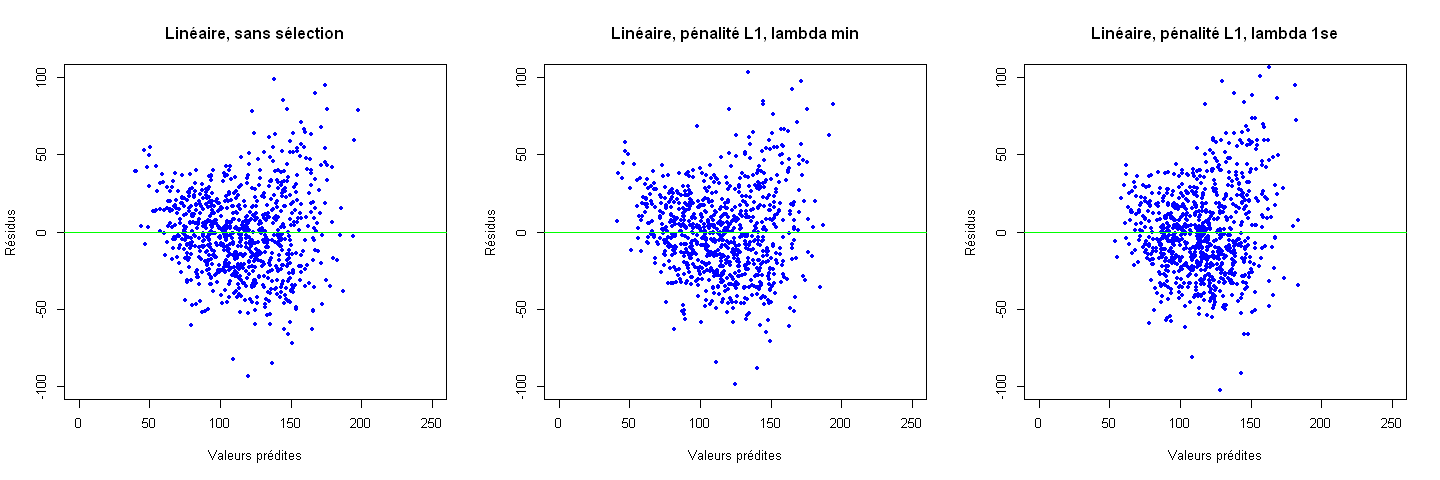

In [37]:
# Extraction des valeurs ajustées et des résidus

fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat) # NEW
res.lasso.1se <- datappr$O3obs - fit.lasso.1se # NEW

# Graphe des résidus
options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
plot.res(fit.lm, res.lm, "Linéaire, sans sélection")
plot.res(fit.lasso, res.lasso, "Linéaire, pénalité L1, lambda min")
plot.res(fit.lasso.1se, res.lasso.1se, "Linéaire, pénalité L1, lambda 1se") # NEW

**Q** Commenter.

<FONT COLOR="blue"> Lasso lambda.min : On obtient un graphe de résidus très similaire à celui du modèle complet. On observe toujours une petite tendance et la variance qui augmente avec les valeurs prédites. 

<FONT COLOR="blue"> Lasso lambda.lse : La tendance est plus faible et la variance augmente toujours mais moins que dans le modèle d'origine. 

**Q** Calculer le critère MSE (moyenne des carrés des résidus) pour les deux modèles. Pourquoi celui obtenu par LASSO est-il moins bon ? Quel critère LASSO minimise t-il ?

<FONT COLOR="blue"> Le critère MSE obtenu par Lasso est moins bon car c'est un sous modèle, donc l'erreur commise est forcément plus grande, mais la question est de savoir si elle reste raisonnable. Lasso minimise le critère de la norme L1.

    MELI : On voit que le MSE est bien le plus faible pour le modèle sans sélection. Ceci est normal car car c'est ce qu'on minimise quand on fait ‖𝑌−𝑋𝛽‖. Utiliser lasso avec lambda_min ou lambda_1se augmente le MSE mais ce n'est pas grave car nous on veut minimiser l'erreur de généralisation (et là on a printé l'erreur d'apprentissage).

**Q** Estimer l'erreur de généralisation du modèle de régression linéaire simple sans sélection de variables par validation croisée. Comparer avec celle du LASSO. Qu'observez-vous?
    
    elle vaut 865 donc elle est bien moins bonne

In [38]:
# NEW : 
paste("Modèle linéaire sans séletion:",mean(res.lm^2))
paste("LASSO avec lambda.min:",mean(res.lasso^2))
paste("LASSO avec lambda.1se:",mean(res.lasso.1se^2))

[1] "Modèle linéaire sans séletion: 791.937834697786"

[1] "LASSO avec lambda.min: 804.237826099315"

[1] "LASSO avec lambda.1se: 871.377748160473"

In [39]:
# NEW
V=10 ; nV=floor(nrow(datappr)/V)
S=sample(1:nrow(datappr),replace=FALSE)
error.CV = c() #initialiser le vecteur d'erreur
for(v in 1:V)
{ # Rq : les deux dernières obs sont tjs dans l'échantillon d'apprentissage...
    datappr.learn=datappr[-c(S[(nV*(v-1)):(nV*v)]),] #on enlève le set de validation du set d'apprentissage
    datappr.valid=datappr[c(S[(nV*(v-1)):(nV*v)]),] #set de validation
    error.CV=c(error.CV,mean((datappr.valid$O3obs-predict(aov(O3obs ~ ., data=datappr.learn),newdata=datappr.valid))^2))
    #error.CV = erreur généralisée calculée sur le set d'entrainement et évalué sur le set de validation qui représente des nouvelles données
}
mean(error.CV)

print(reg.lasso.cv)

[1] 895.964


Call:  cv.glmnet(x = x.mat, y = datappr[, 2]) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.424    45   826.8 56.38       9
1se  3.602    22   878.8 65.41       3


### Modèle quadratique

L'étude suivante met en oeuvre toutes les interactions d'ordre 2 entre les variables. Il s'agit donc d'un modèle de régression quadratique. Il est estimé avec la fonction glm qui permet une sélection automatique de modèle. La méthode descendante est utilisée mais celle pas-à-pas pourrait également l'être. Ce type de procédure n'est pas implémentée en python.

#### Sélection de variables par critère AIC

Sélection descendante: à chaque étape, chaque modèle est comparé à tous les sous-modèles possibles obtenus par suppression d'une des interactions ou une des variables, à condition qu'elle ne soit pas présente dans une interaction. La variable sélectionnée et supprimée est celle qui fait décroîre le critère considéré : AIC ou *Akaïke Information Criterion*. 

**Q** Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisée en régression linéaire? 

<FONT COLOR="blue">Le critère BIC, qui est plus pénalisant que l'AIC


In [40]:
# Estimation du modèle de toute interaction d'ordre 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)  # .^2 = modèle avec interactions
# Recherche du meilleur modèle au sens 
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7804.89
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- JOUR:STATION     4   484061 7797.7
- STATION:VentANG  4   485284 7799.8
- MOCAGE:STATION   4   486860 7802.5
- MOCAGE:TEMPE     1   483568 7802.9
- JOUR:LNO         1   483568 7802.9
- JOUR:SRMH2O      1   483571 7802.9
- MOCAGE:VentANG   1   483582 7802.9
- JOUR:LNO2        1   483588 7802.9
- LNO2:LNO         1   483608 7803.0
- JOUR:VentANG     1   483616 7803.0
- VentMOD:SRMH2O   1   483632 7803.0
- VentANG:SRMH2O   1   483916 7803.5
- VentMOD:LNO2     1   483946 7803.5
- VentMOD:VentANG  1   484044 7803.7
- VentANG:LNO2     1   484118 7803.8
- JOUR:TEMPE       1   484131 7803.9
- JOUR:VentMOD     1   484227 7804.0
- VentMOD:LNO      1   484248 7804.1
- JOUR:MOCAGE      1   484253 7804.1
- MOCAGE:VentMOD   1   484328 7804.2
- TEMPE:VentMOD    1   484538 7804.6
- STATION:VentMOD  4   488049 7804.6
<none>                 483568 7804.9


In [41]:
# Coefficients du modèle
anova(reg.glm.step, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,831,1424839.3,NA,NA
JOUR,1,43.01246,830,1424796.3,0.06821578,7.940204e-01
MOCAGE,1,468728.83153,829,956067.5,743.38224491,5.297655e-116
TEMPE,1,243968.53875,828,712098.9,386.92281725,1.840921e-70
STATION,4,16701.45664,824,695397.5,6.62193442,3.038152e-05
VentMOD,1,11706.14519,823,683691.3,18.56540479,1.847989e-05
VentANG,1,10276.50687,822,673414.8,16.29806454,5.936845e-05
SRMH2O,1,1221.10763,821,672193.7,1.93662021,1.644262e-01
LNO2,1,2430.16147,820,669763.5,3.85412367,4.997297e-02


#### Sélection de variable par régularisation L1 (LASSO)

In [42]:
# Comparer avec un modèle quadratique avec pénalité L1
# Résultat : sélectionne moins de variables qu'AIC => Lasso est plus pénalisant 
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)         24.80626356
JOUR0                .         
JOUR1                .         
MOCAGE               .         
TEMPE                1.34220556
STATIONAls           .         
STATIONCad           .         
STATIONPla           .         
STATIONRam           .         
VentMOD              .         
VentANG              .         
SRMH2O               .         
LNO2                 .         
LNO                  .         
JOUR1:MOCAGE         .         
JOUR1:TEMPE          .         
JOUR1:STATIONAls     .         
JOUR1:STATIONCad     .         
JOUR1:STATIONPla     .         
JOUR1:STATIONRam     .         
JOUR1:VentMOD        .         
JOUR1:VentANG        .         
JOUR1:SRMH2O         .         
JOUR1:LNO2           .         
JOUR1:LNO            .         
MOCAGE:TEMPE         0.01305321
MOCAGE:STATIONAls    .         
MOCAGE:STATIONCad    .         
MOCAGE:STATIONPla    .        

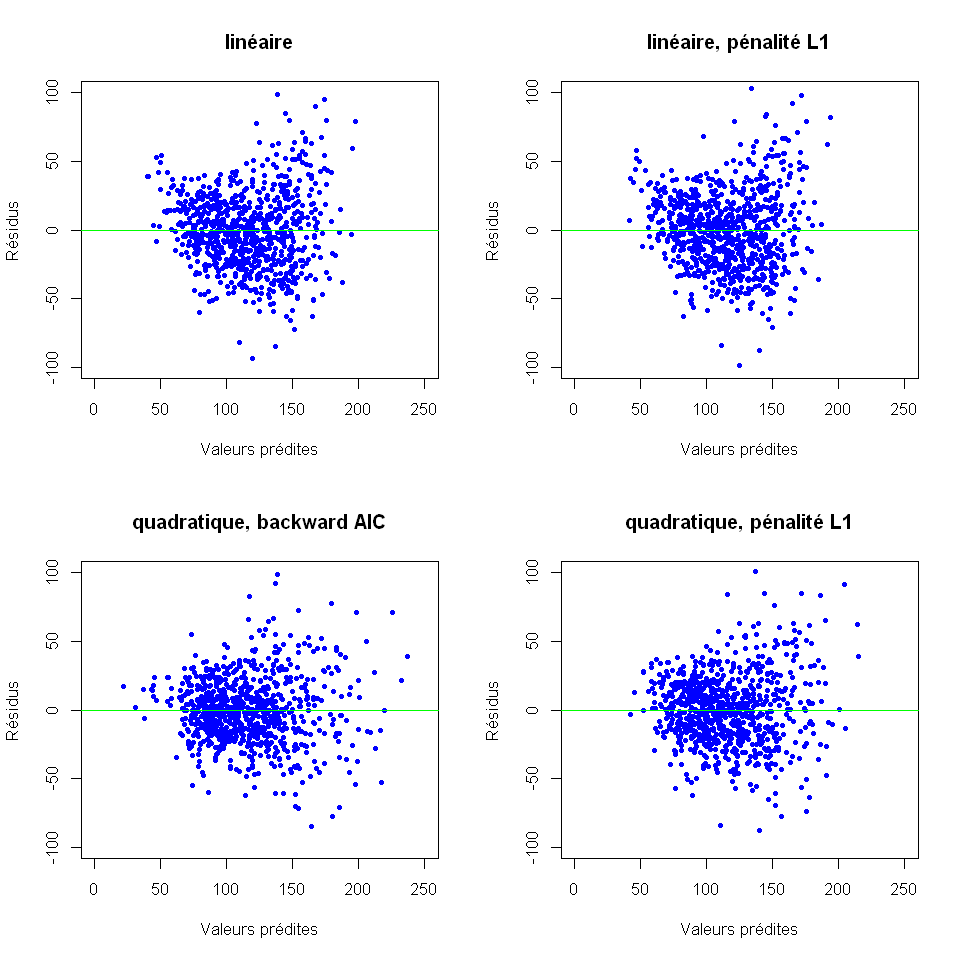

In [43]:
# Extraction des valeurs ajustées et des résidus
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2

# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(2, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
plot.res(fit.glm, res.glm, "quadratique, backward AIC")
plot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")

Le problème d'hétéroscédasticité a été corrigé (la forme de banane est moins présente). 

 On remarque que la présence de certains interactions ou variables sont pertinentes au sens du critère d'Akaïke mais pas significative au sens du test de Fisher. Cette présence dans le modèle pourrait être plus finement analysée en considérant une estimation de l'erreur par validation croisée. L'idée serait de retirer une à une les variables ou interactions les moins significatives pour voir comment se comporte la validation croisée. D'autre part, si la procédure pas-à-pas conduit à un modèle différent, l'estimation de l'erreur par validation croisée permet également d'optimiser le choix.
 
Ces raffinements ne s'avèrent pas efficaces sur ces données. Le modèle obtenu par minimisaiton du critère AIC est conservé.

### Prévision de l'échantillon test

Le modèle "optimal" obtenu par la méthode stepwise est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. Deux erreurs sont estimées ; la première est celle quadratique pour la régression tandis que la deuxième est issue de la matrice de confusion qui croise les dépassements de seuils prédits avec ceux effectivement observés. 

#### Erreur de régression

In [44]:
# Calcul des prévisions pour le nomdèle quadratique backward AIC
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Erreur quadratique moyenne de prévision (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 542.5378

In [45]:
# Erreur quadratique par MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1120.387

#### Erreur de classification (matrice de confusion)

la matrice de confusion contient les true negative, true positive, false positive, false negative

In [46]:
# Matrice de confusion pour la prévision du dépassement de seuil
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   168   19
  TRUE      7   15

In [47]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil par MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   144   15
  TRUE     31   19

Noter ces erreurs pour les comparer avec celles obtenues par les autres méthodes. Noter l'asymétrie des erreurs.

<FONT COLOR="blue">L'erreur de regression commise par le modèle déterministe est beaucoup plus élevée que celle du modèle reg.glm.step.
Cela se constate aussi sur la matrice de confusion où on a plus de false negative et false positive avec le modèle déterministe qu'avec reg.glm.step. 

<FONT COLOR="blue">Interprétation de la matrice de confusion : 

<FONT COLOR="blue">- en colonne : la réalité 
<FONT COLOR="blue">- en ligne la prédiction 
<FONT COLOR="blue">=> Il faut comparer les rapports entre les deux lignes, on observe que : 
<FONT COLOR="blue">- Quand on ne prédit pas de dépassement de seuil (première colonne) notre modèle est très bon car  le true negative rate = 144 >> false negative rate = 31
<FONT COLOR="blue">- Quand on prédit un dépassement (deuxième colonne) notre modèle n'est pas bon, on voit qu'il se trompe une fois sur deux car le true positive rate = 19 est à peu près égal au false positive rate = 19. 

<FONT COLOR="blue">Conclusion : Notre modèle améliore un petit peu le modèle déterministe mais pas énormément, et pas dans le cas d'un dépassement de seuil. Or c'est pouvoir prédire ce dépassement de seuil qui nous interesse, notre modèle n'est donc pas bon. 

## [Prévision par modèle binomial](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

Plutôt que de prévoir la concentration puis le dépassement, on peut se poser la question de savoir s'il ne serait pas pertinent de prévoir directement la présence ou l'absence d'un dépassement. La variable à modéliser étant binaire, c'est la régression logistique qui va être employée. Comme pour la régression, différentes stratégies de choix de modèle peuvent être utilisées et comparées avant d'estimer l'erreur de prévision sur l'échantillon test.

### Régression logistique sans interaction

In [48]:
# estimation du modèle complet
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial) #binomial : regression logistique
# significativité des paramètres
anova(log.lm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,766.6575,NA
JOUR,1,7.810599e-03,830,766.6497,9.295766e-01
MOCAGE,1,1.348923e+02,829,631.7574,3.485766e-31
TEMPE,1,1.605984e+02,828,471.1590,8.373431e-37
STATION,4,3.174517e+01,824,439.4138,2.156780e-06
VentMOD,1,1.328475e+01,823,426.1291,2.675732e-04
VentANG,1,3.103397e-01,822,425.8187,5.774718e-01
SRMH2O,1,9.435540e+00,821,416.3832,2.128204e-03
LNO2,1,6.798280e-02,820,416.3152,7.942968e-01


In [49]:
# Recherche d'un modèle optimal au sens d'Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=437.29
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- VentANG  1   411.50 435.50
- JOUR     1   411.58 435.58
- MOCAGE   1   412.27 436.27
<none>         411.29 437.29
- LNO2     1   416.18 440.18
- LNO      1   416.32 440.32
- VentMOD  1   418.07 442.07
- SRMH2O   1   421.25 445.25
- STATION  4   439.72 457.72
- TEMPE    1   560.44 584.44

Step:  AIC=435.5
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   411.84 433.84
- MOCAGE   1   412.53 434.53
<none>         411.50 435.50
- LNO2     1   416.30 438.30
- LNO      1   416.40 438.40
- VentMOD  1   419.28 441.28
- SRMH2O   1   421.76 443.76
- STATION  4   440.96 456.96
- TEMPE    1   562.99 584.99

Step:  AIC=433.84
DepSeuil ~ MOCAGE + TEMPE + STATION + VentMOD + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
- MOCAGE   1   412.75 432.75
<none>         411.84 433.84
- 

In [50]:
# Modèle obtenu
anova(log.lm.step, test = "Chisq") #test de nullité des paramètres

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,766.6575,NA
TEMPE,1,235.936888,830,530.7206,3.024659e-53
STATION,4,53.632793,826,477.0878,6.281855e-11
VentMOD,1,33.452443,825,443.6354,7.302799e-09
SRMH2O,1,12.310366,824,431.3250,4.504497e-04
LNO2,1,5.280365,823,426.0447,2.156723e-02
LNO,1,13.296238,822,412.7484,2.659392e-04


In [51]:
# matrice de confusion de l'échantillon d'apprentissage et erreur apparente
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   658   66
  TRUE     30   78

<FONT COLOR="blue">Interprétation : 
<FONT COLOR="blue">- Quand on ne prédit pas de dépassement de seuil (première colonne) notre modèle est très bon car  le true negative rate = 658 >> false negative rate = 30
<FONT COLOR="blue">- Quand on prédit un dépassement (deuxième colonne) notre modèle n'est pas bon, on voit qu'il se trompe une fois sur deux car le true positive rate = 78 est à peu près égal au false positive rate = 66.

### Régression logistique avec interactions

Avec autant de variables et d'interactions donc de paramètres, l'estimation du modèle complet de régression logistique  rencontre des soucis et affiche des *warnings* car certaines probabilité trop bien ajustés (0 ou 1) provoquent des divisions par 0. Ici une procédure *forward* ou  mieux *stepwise* de sélection des variables et interactions  conduit à des résultats raisonnables. Une méthode avec pénalisation L1 peut aussi être utilisée.

In [52]:
# régression avec le modèle minimum
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
# algorithme stepwise en précisant le plus grand 
# modèle possible
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial)

# lower-upper : on regarde l'ensemble des modèles qui vont du modèle constant (lower = ~1) jusqu'au modèle
# upper = ~(JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2) avec des intérations

Start:  AIC=768.66
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   530.72 534.72
+ MOCAGE   1   631.95 635.95
+ SRMH2O   1   692.21 696.21
+ VentANG  1   755.67 759.67
+ STATION  4   753.11 763.11
+ LNO2     1   759.37 763.37
+ VentMOD  1   761.23 765.23
+ LNO      1   762.55 766.55
<none>         766.66 768.66
+ JOUR     1   766.65 770.65

Step:  AIC=534.72
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   471.81 477.81
+ STATION  4   477.09 489.09
+ SRMH2O   1   497.28 503.28
+ VentMOD  1   519.90 525.90
+ VentANG  1   523.34 529.34
+ LNO      1   525.81 531.81
<none>         530.72 534.72
+ JOUR     1   530.60 536.60
+ LNO2     1   530.68 536.68
- TEMPE    1   766.66 768.66

Step:  AIC=477.81
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ STATION       4   440.20 454.20
+ SRMH2O        1   453.07 461.07
+ LNO           1   459.96 467.96
+ LNO2          1   461.27 469.27
+ VentMOD       1   467.55 475.55
+ MOCAGE:TEMPE  1   468.55 476.55
+ VentAN

In [53]:
anova(log.qm.step1, test = "Chisq") #modèle sélectionné par step AIC

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,766.6575,NA
TEMPE,1,235.936888,830,530.7206,3.024659e-53
MOCAGE,1,58.912648,829,471.8080,1.648293e-14
STATION,4,31.610575,825,440.1974,2.297718e-06
SRMH2O,1,15.447545,824,424.7499,8.482705e-05
VentMOD,1,7.777390,823,416.9725,5.290418e-03
STATION:SRMH2O,4,15.943484,819,401.0290,3.095945e-03
TEMPE:SRMH2O,1,4.002188,818,397.0268,4.544124e-02
MOCAGE:VentMOD,1,3.069016,817,393.9578,7.979778e-02


### Prévision de l'échantillon test

#### Matrice de confusion

In [54]:
# Prévision du modèle quadratique
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   170   20
  TRUE      5   14

Comparer avec l'approche précédente. Mémoriser les résultats obtenus pour comparer avec les autres méthodes.

Interprétation : 
<FONT COLOR="blue">- Quand on ne prédit pas de dépassement de seuil (première colonne) notre modèle est très bon car  le true negative rate = 170 >> false negative rate = 5
<FONT COLOR="blue">- Quand on prédit un dépassement (deuxième colonne) notre modèle n'est pas bon, on voit qu'il se trompe une fois sur deux car le true positive rate = 14 est à peu près égal au false positive rate = 20. (Il fait même plus de mauvaises prédictions que de bonnes prédictions)

#### [Courbe ROC](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)

Il est également possible de construire une courbe ROC en association de la prévision obtenue à partir d'un modèle gaussien. En effet, la variation du seuil théorique de dépassement (150) va faire varier les proportions respectives des taux de vrais et faux positifs. Cela revient encore à faire varier le seuil d'une "proba" pour les valeurs de prévisions divisées par 300.

Installation du package dans 'C:/Users/coxi/Documents/R/win-library/4.1'
(car 'lib' n'est pas spécifié)



package 'ROCR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\coxi\AppData\Local\Temp\Rtmp2ZS7ZN\downloaded_packages


Warning message:
"le package 'ROCR' a été compilé avec la version R 4.1.3"


AUC pour mocage :  0.807479  | AUC pour logit :  0.8942857  | AUC pour glm 0.8836975

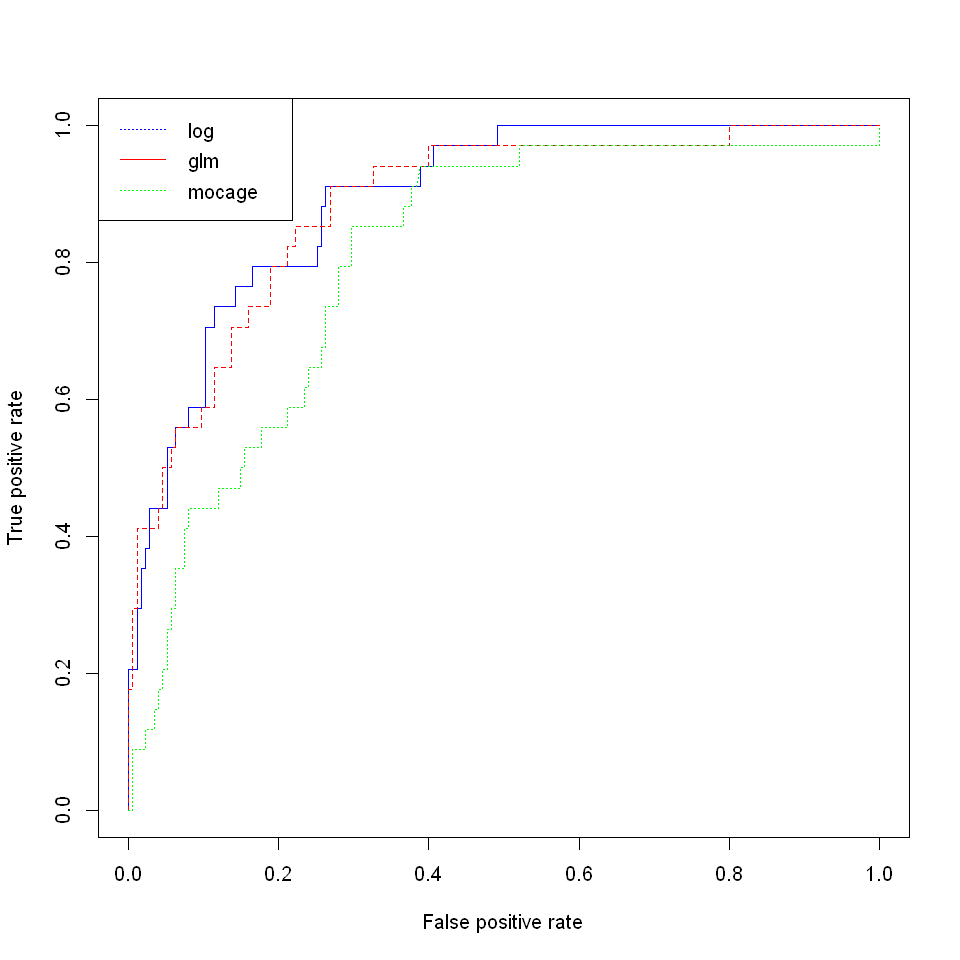

In [55]:
install.packages("ROCR")
library(ROCR)   # Librairie à charger
roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")
# Tracé de la courbe
plot(perflogit, col = "blue")

# Calculs pour la régression
rocglm <- pred.glm / 300
predglm <- prediction(rocglm, datestq[, "DepSeuil"])
perfglm <- performance(predglm, "tpr", "fpr")
# tracé de la courbe et ajout au graphe précédent.
plot(perfglm, col = "red",lty=2, add = TRUE)

detmocage <- datestq[,"MOCAGE"]/300
predmocage <- prediction(detmocage, datestq[, "DepSeuil"])
perfmocage <- performance(predmocage, "tpr", "fpr")
# Tracé de la courbe
plot(perfmocage, col = "green",lty=3,add = TRUE)
legend("topleft",legend=c("log","glm","mocage" ),lty=c(3,1),col=c("blue","red", "green"))


#printer les AUC 
perfmocageauc <- performance(predmocage, measure="auc")
predglmauc<- performance(predglm, measure="auc")
predglogitauc<- performance(predlogit, measure="auc")
cat("AUC pour mocage : ", perfmocageauc@y.values[[1]], " | AUC pour logit : ", predglogitauc@y.values[[1]], " | AUC pour glm", predglmauc@y.values[[1]])

La courbe ROC représente le True positive Rate en fonction du False positive Rate. Plus elle monte vite vers 1, meilleur est notre modèle. 
On trace plusieurs courbes pour différentes valeurs de seuil (s) et ainsi on détermine le meilleur seuil pour déclarer un dépassement de l'ozone : P(Depseuil =1) > s.

**Q** Que sont sensibilité et spécificité d'une courbe ROC?

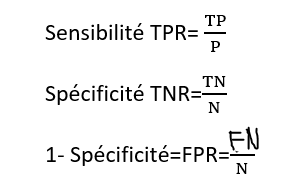

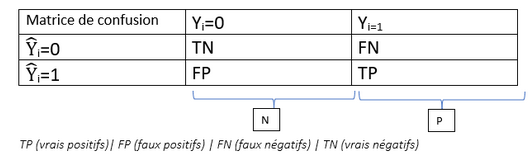

La sensibilité correspond donc au rapport des vrais positifs par le nombre total de positifs. 

La spécificité correspond  au rapport des vrais négatifs par le nombre total de négatifs. 

La courbe ROC représente la sensibilté par rapport à 1- sensibilité c'est à dire le false negative rate. 

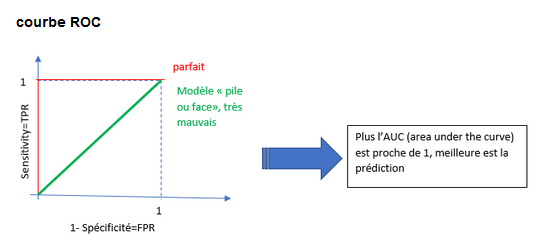

<FONT COLOR="red"> ATTENTION : l'utilisation d'une courbe ROC ne fonctionne que pour du binaire !!!!

Les résultats obtenus dépendent évidemment en plus de l'échantillonnage initial entre apprentissage et test. Dans le cas où les courbes se croisent, cela signifie qu'il n'y a pas de prévision uniformément meilleure de l'occurrence de dépassement. Cela dépend de la sensibilité ou de la spécificité retenue pour le modèle. Ceci souligne l'importance de la bonne définition du critère à utiliser pour le choix d'une "meilleure" méthode. Ce choix dépend directement de celui , "politique" ou "économique" de sensibilité et / ou spécificité du modèle retenu. En d'autres termes, quel taux de fausse alerte, avec des imputations économiques évidentes, est supportable au regard des dépassements non détectés et donc de la dégradation sanitaire de la population à risque ?
 
C'est une fois ce choix arrêté que le statisticien peut opérer une comparaison des méthodes en présence.

**Q** Les performances des deux approches gaussiennes et binomiales sont-elles très différentes?


**Q** Sur le graphe ci-dessus, ajouter la courbe ROC pour le modèle déterministe MOCAGE. Qu'observez-vous?

<FONT COLOR="blue"> En termes de spécificité et de sensibilité les deux approches (logit et glm) ne sont pas si différentes. On ne peut pas vraiment conclure en regardant seulement les courbes roc (car elles se croisent). Cependant l'AUC est légèrement plus important pour la méthode logit que pour la méthode glm, donc logit semble légèrement plus précis. Le modèle déterministe mocage est bien moins bon avec un AUC de 0.83.




# <FONT COLOR="Red">Épisode 2</font>

## [Analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf)

### Introduction

 L'objectif est de comparer les trois méthodes d'analyses discriminantes disponibles dans R: `lda` paramétrique linéaire (homoscédasticité), `qda` paramétrique quadratique (hétéroscédasticité) sous hypothèse gaussienne et celle non-paramétrique des $k$ plus proches voisins.
 
**Q** Quel critère d'affectation est utilisé en `lda`?

**Q** Que signifient les hypothèses d'homo ou d'hétéroscédasticité?

**Q** Quelle fonction est estimée "non paramétriquement" par l'algorithme des $k$ plus proches voisins?
 
*Attention*, ces techniques n'acceptent par principe que des variables explicatives ou prédictives quantitatives. Néanmoins, une variable qualitative à deux modalités, par exemple le type de jour, peut être considérée comme quantitative sous la forme d'une fonction indicatrice prenant ses valeurs dans $\{0, 1\}$ et, de façon plus "abusive", une variable ordinale est considérée comme "réelle". Dans ce dernier cas, il ne faut pas tenter d'interpréter les fonctions de discrimination, juste considérer des erreurs de prévision. La variable *Station* n'est pas prise en compte.

La bibliothèque standard de R (`MASS`) pour l'analyse discriminante ne propose pas de procédure automatique de choix de variable mais, dans cet exemple, les variables sont peu nombreuses.

### Estimation des modèles

In [56]:
library(MASS) # chargement des librairies
library(class) # pour kNN

In [57]:
# analyse discriminante linéaire
disc.lda=lda(DepSeuil~.,data=datappq[,-4]) 
# analyse discriminante quadratique 
disc.qda=qda(DepSeuil~.,data=datappq[,-4]) 
# k plus proches voisins
disc.knn=knn(datappq[,c(-4,-10)],datappq[,c(-4,-10)],datappq$DepSeuil,k=10) 

Noter le manque d'homogénéité des commandes de R issues de librairies différentes. L'indice de colonne négatif ($-10$) permet de retirer la colonne contenant la variable à prédire de type facteur. Celle-ci est mentionnée en troisième paramètre pour les données d'apprentissage. La librairie [caret](http://topepo.github.io/caret/index.html) contourne ces difficultés en englobant toutes les librairies d'apprentissage et en homogénéisant les appels pour l'estimation et la prévision des modèles. 

### Estimation de l'erreur de prévision par validation croisée

In [58]:
# erreur par validation croisée  en analyse discriminante linéaire
disc.lda=lda(DepSeuil~.,data=datappq[,-4],CV=T) 
# estimer le taux d'erreur à partir de la matrice de confusion
table(datappq[,"DepSeuil"],disc.lda$class) 

       
        FALSE TRUE
  FALSE   660   28
  TRUE     70   74

In [59]:
# analyse discriminante quadratique
disc.qda=qda(DepSeuil~.,data=datappq[,-4],CV=T)  
table(datappq[,"DepSeuil"],disc.qda$class) 

       
        FALSE TRUE
  FALSE   651   37
  TRUE     80   64

Pour knn, le choix du nombre de voisins $k$ doit être optimisé par validation croisée mais la procédure proposée par la bibliothèque `class` est celle *leave-one-out*, donc trop coûteuse en calcul pour des gros fichiers. Il serait simple de la programmer mais une autre bibliothèque (`e1071`) propose déjà une batterie de fonctions de validation croisée pour de nombreuses techniques de discrimination. 

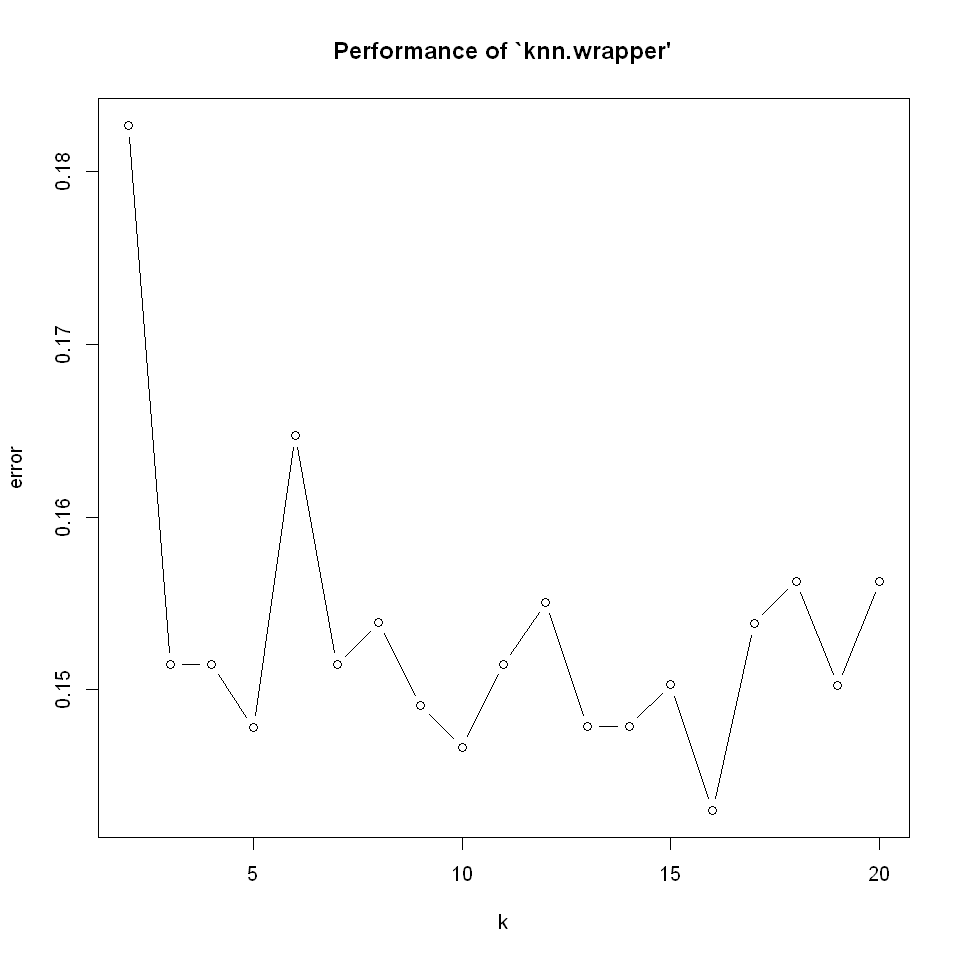

In [60]:
# k plus proches voisins: optimisation de k
library(e1071)
plot(tune.knn(as.matrix(datappq[,c(-4,-10)]),as.factor(datappq[,10]),k=2:20))

**Q** Quelle procédure de validation croisée est exécutée par défaut par la fonction `tune`?

Lancer plusieurs exécutions successives de cette "optimisation".

**Q** Pourquoi la valeur de $k$ optimale diffère à chaque exécution? Comment choisir k ? 

Comparer avec les erreurs précédentes estimées également par validation croisée. 

**Q** Quelle analyse discriminante retenir ? Pourquoi?

### Prévision de l'échantillon test

#### Matices de confusion

Les commandes suivantes calculent la matrice de confusion pour la "meilleure" méthode d'analyse discriminante au sens de la validation croisée. Cette "meilleure" méthode peut être edifférente d'un participant à l'autre.

In [61]:
disc.lda=lda(DepSeuil~.,data=datappq[,-4])  
table(predict(disc.lda,datestq[,-4])$class,datestq[,"DepSeuil"])

       
        FALSE TRUE
  FALSE   168   21
  TRUE      7   13

A titre indicatif, voici l'estimation de l'erreur sur l'échantillon test pour la méthode des $k$ plus proches voisins.

In [62]:
disc.knn=knn(as.matrix(datappq[,c(-4,-10)]),as.matrix(datestq[,c(-4,-10)]),datappq$DepSeuil,k=15)
table(disc.knn,datestq$DepSeuil)

        
disc.knn FALSE TRUE
   FALSE   170   22
   TRUE      5   12

#### Courbes ROC

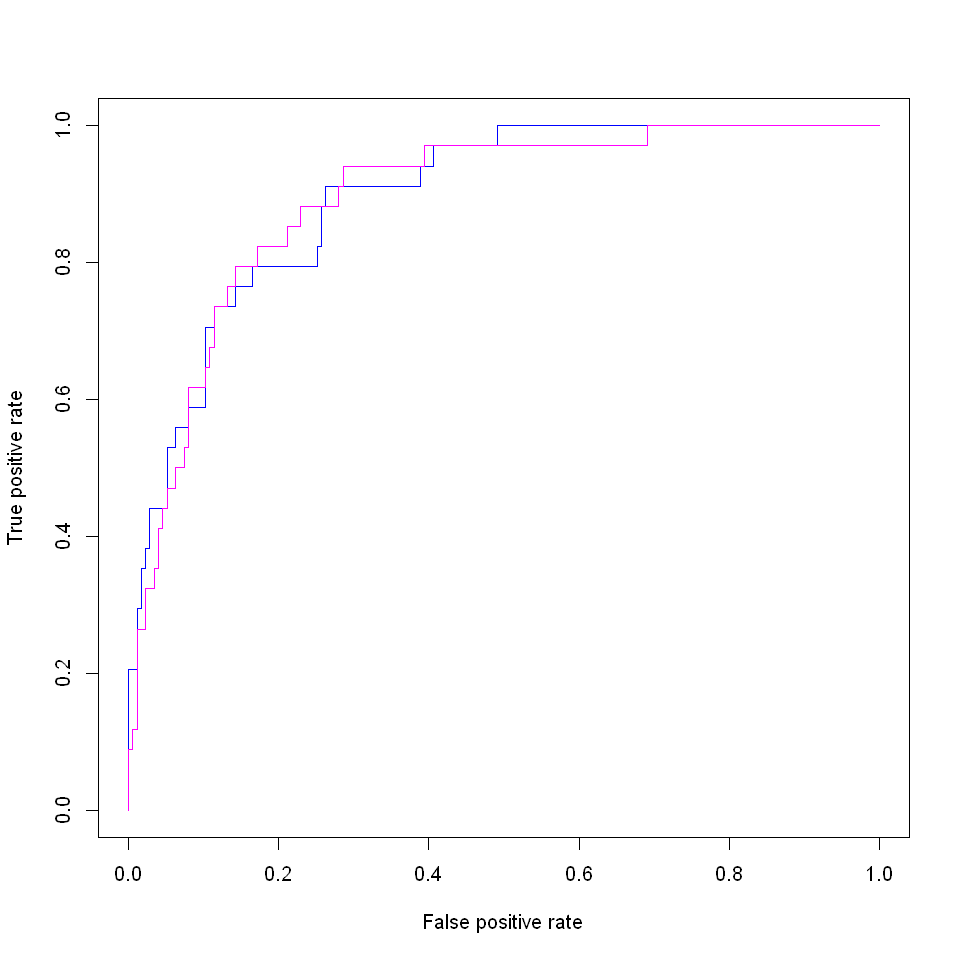

In [63]:
library(ROCR)
ROCdiscrim=predict(disc.lda,datestq[,c(-4)])$posterior[,2]
preddiscrim=prediction(ROCdiscrim,datestq$DepSeuil)
perfdiscrim=performance(preddiscrim,"tpr","fpr")
# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue") 
plot(perfdiscrim,col="magenta",add=TRUE)  

**Q** Une méthode est-elle uniformément meilleure sur cet échantillon test ?

## [Arbre de décision binaire](http://wikistat.fr/pdf/st-m-app-cart.pdf)

La librairie  `rpart` est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbre peuvent être estimer selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres  contrôlent l'exécution de l'algorithme: 
- la pénalisation  minimale (`cp`) pour la construction de l'arbre maximal => complexity parameter : si le split n'entraine pas une décroissance de l'hétérogénéité d'au moins `cp` alors il n'est pas réalisé.
- le nombre minimal d'observation par noeud, 
- le nombre de validations croisées (par défaut 10)... 

cf. l'aide en ligne (?rpart.control) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres, c'est le travers des logiciels "libres".

**NB.** Une séquence de valeurs de la pénalisation `cp` est associée à une séquence d'arbres emboîtés.


### Estimation et élagage de l'arbre de régression
**Q** Quel critère est optimisé lors de la création d'un noeud? de l'arbre?

In [64]:
library(rpart) # chargement de la librairie
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001)) #ici on utilise le set d'apprentissage
# La commande ci-dessous fournit un descriptif de l'arbre obtenu
summary(tree.reg)  
# mais un graphe est  préférable

Warning message:
"le package 'rpart' a été compilé avec la version R 4.1.3"


Call:
rpart(formula = O3obs ~ ., data = datappr, control = rpart.control(cp = 0.001))
  n= 832 

            CP nsplit rel error    xerror       xstd
1  0.290932776      0 1.0000000 1.0021126 0.06613718
2  0.133983949      1 0.7090672 0.7623447 0.05228305
3  0.036925007      2 0.5750833 0.6310261 0.03819738
4  0.034195782      3 0.5381583 0.5848742 0.03505638
5  0.028951364      4 0.5039625 0.5722669 0.03456164
6  0.015685440      5 0.4750111 0.5352240 0.03121465
7  0.013299913      6 0.4593257 0.5252090 0.03124191
8  0.012669219      7 0.4460258 0.5300051 0.03167194
9  0.008641190      8 0.4333565 0.5287138 0.03201547
10 0.008186544      9 0.4247154 0.5351622 0.03244110
11 0.007623662     10 0.4165288 0.5394351 0.03250646
12 0.007085286     11 0.4089052 0.5330609 0.03192154
13 0.006803218     13 0.3947346 0.5390860 0.03212448
14 0.006356112     14 0.3879314 0.5367553 0.03210110
15 0.006088470     15 0.3815753 0.5341551 0.03199024
16 0.005772650     16 0.3754868 0.5278081 0.03138752
17

Léa : Plus gamma est grand plus on pénalise les arbres compliquées avec beaucoup de feuilles. A chaque création d'un noeud, on cherche à minimiser le critère suivant : $Crit(A)=D(A)+gamma\times KA$ avec KA le nombre de feuilles et gamma est la force du terme de pénalisation.
A chaque noeud, on vise à minimiser D(A), et ensuite on cherche au niveau de tout l'arbre à minimiser le critère pénalisé, c'est à dire éviter qu'il y ait trop de feuilles. Donc il faut élaguer. Ici cp=0.001, donc il y a très peu d'élagage. 

Ce qu'il fait en pratique dans ce qu'affiche summary(tree.reg), il y a le calcul de la suite de Briemann qui calcule une suite de gamma (donc de cp). Et ensuite il donne l'arbre pour lequel le cp est le plus proche du cp (0.001 ici). 
Les arbres sont très instables comme modèle. C'est pourquoi, il est mieux de faire des forets aléatoire 

Si gamma=0, on aura l'arbre maximal ! Attention cela ne correspond pas forcément à l'arbre pour lequel il y a une observation par feuille, car si les valeurs d'une feuille est homogène en y (toutes les valeurs de y, ce qu'on cherche à prédire, sont identiques), on n'élague alors pas. 

- **primary split :** le split selon MOCAGE  < 123.65 va vers la branche gauche et donc MOCAGE  >= 123.65 vavers la branche droite. Ce split entraine une décroissance d'hétérogénéité de 0.29093280.
- **surrogate split :** variables de substitution dans le cas où on a des données manquantes. 

<font color = "purple"> Lila : cp : complexity parameter. Tout split dont la dércoissance en hétérogénéité n'est pas d'au moins la valeur cp, n'est pas réalisé (donc élagué). Donc su cp est très petit, on élague peu, plus cp est grand plus on élague l'arbre donc moins l'arbre est complexe.

In [65]:
library(rpart)
help(rpart)

In [66]:
help(rpart.control)

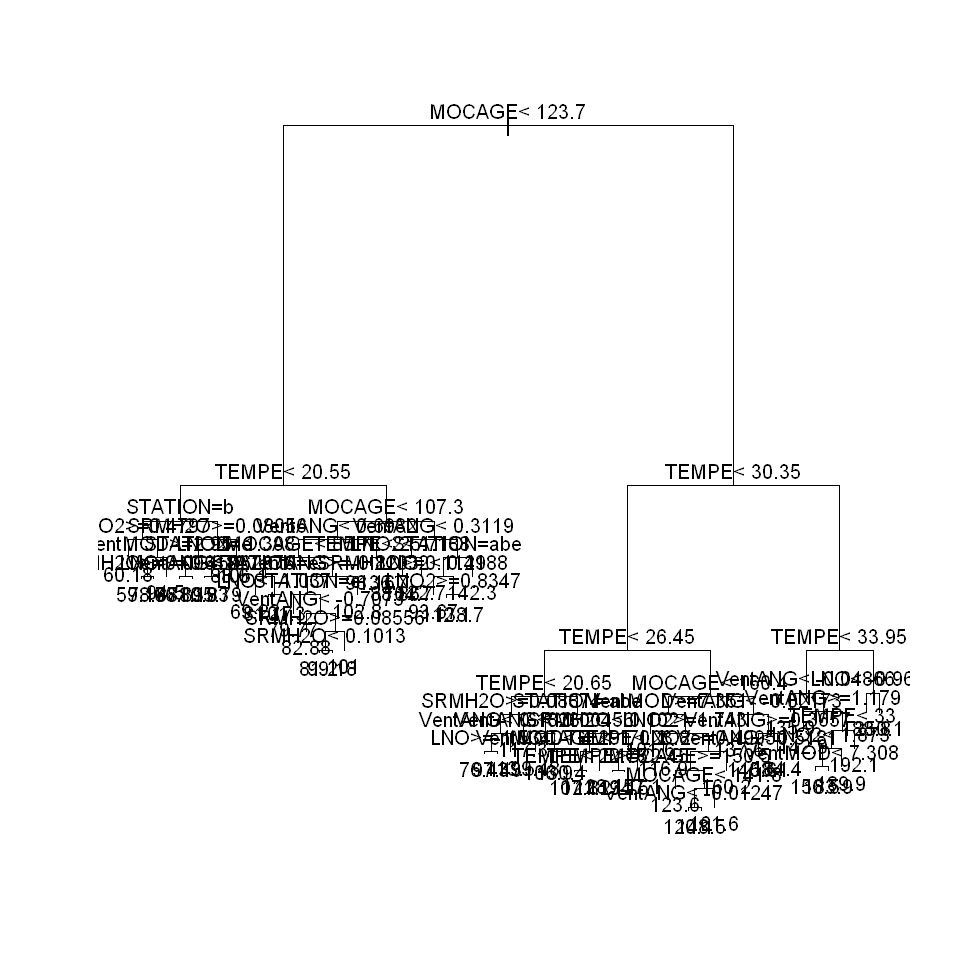

In [67]:
plot(tree.reg)
text(tree.reg)

Léa : **Algo de Breiman (p 74)**
- FIRST STEP : on calcule l'arbre maximal (TOUJOURS !!!!). A chaque noeud, on divise selon une variable et un seuil qui est choisi tel qu'il minimise le critère. On veut minimiser l'hétérogénéité à chaque noeud. 
- SECOND STEP : Au niveau de l'arbre complet/maximal, on minimise D(A) c'est à dire la somme de l'hétérogénéité dans tout l'arbre, pour toutes les feuilles et pénalisant avec le nombre de feuilles. Cela permet d'élaguer l'arbre, et l'objectif principal est de découper en deux groupes homogènes en terme de classfication à chaque noeud, et de trouver un compromis entre maximal tree et l'arbre constant. 

IL y a toujours ces deux étapes !!!!!

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par  validation croisée *10-fold* pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`. 

In [68]:
xmat=xpred.rpart(tree.reg)
xerr=(xmat-datappr[,"O3obs"])^2
CVerr=apply(xerr,2,sum) #on applique la somme (FUN=sum) sur les colonnes (MARGIN=2) de la matrice xerr
CVerr  #    CP           erreur

0.645466388 0.197434349 0.070337460 0.035534202 0.031464497 0.021309972 
  1429131.2   1090776.7    919592.3    852231.9    820173.9    772386.8 
0.014443511 0.012980736 0.010463131 0.008410796 0.007900091 0.007349546 
   778915.2    773230.5    760227.1    765240.3    758023.1    752969.9 
0.006942820 0.006575866 0.006220852 0.005928458 0.005580853 0.005123652 
   746666.1    744718.6    745961.4    748692.2    747939.4    743115.5 
0.004612659 0.004020135 0.003666312 0.003561882 0.003362354 0.003197891 
   747960.8    753850.8    766989.1    762098.9    765316.0    768451.9 
0.002946843 0.002735804 0.002700619 0.002569335 0.002444577 0.002409282 
   772466.3    774508.1    774914.3    786807.5    786710.7    784503.5 
0.002300546 0.002004809 0.001814850 0.001733106 0.001618300 0.001511391 
   782950.2    779704.0    781300.5    777219.9    777247.2    777382.5 
0.001370199 0.001279734 0.001206143 0.001150535 0.001145170 0.001131980 
   777957.0    776967.1    778303.5    782199.6    781647.9    781469.3 
0.001117318 0.001061037 0.001005077 
   781040.0    782643.5    783669.7

<font color = "purple"> Lila : Pour une valeur du coefficient de complexité on a l'erreur de validation croisée (CV) associée. Ex : 0.645466388 (=cp
) associée à 1428700.87465326 (erreur de CV) pour le premier élément de CVerr

Léa : Pour chaque valeur de cp, on a l'erreur associée c'est à dire l'erreur quadratique entre les valeurs prédites et les valeurs observées, obtenues par cross validation 10 folds

In [69]:
help(xpred.rpart)

Chercher la valeur de `cp` correspondant à la plus petite erreur puis l'utiliser la construction del'arbre.

In [70]:
as.numeric(attributes(which.min(CVerr))$names) #parmi la cellule suivante, on cherche la valeur de cp qui donne l'erreru minimale. 

[1] 0.005123652

In [71]:
which.min(CVerr) #attributes permet de récupérer "la clé" du dictionnaire

0.005123652 
         18

In [72]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))
#on construit l'arbre avec le cp qui minimise l'erreur

La librairie `partykit` propose une construction graphique de l'arbre:

Installation du package dans 'C:/Users/coxi/Documents/R/win-library/4.1'
(car 'lib' n'est pas spécifié)



package 'partykit' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'partykit'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problème lors de la copie de C:\Users\coxi\Documents\R\win-library\4.1\00LOCK\partykit\libs\x64\partykit.dll vers C:\Users\coxi\Documents\R\win-library\4.1\partykit\libs\x64\partykit.dll: Permission denied"
Warning message:
"restored 'partykit'"



The downloaded binary packages are in
	C:\Users\coxi\AppData\Local\Temp\Rtmp2ZS7ZN\downloaded_packages


Warning message:
"le package 'partykit' a été compilé avec la version R 4.1.3"
Le chargement a nécessité le package : grid

Le chargement a nécessité le package : libcoin

Warning message:
"le package 'libcoin' a été compilé avec la version R 4.1.3"
Le chargement a nécessité le package : mvtnorm



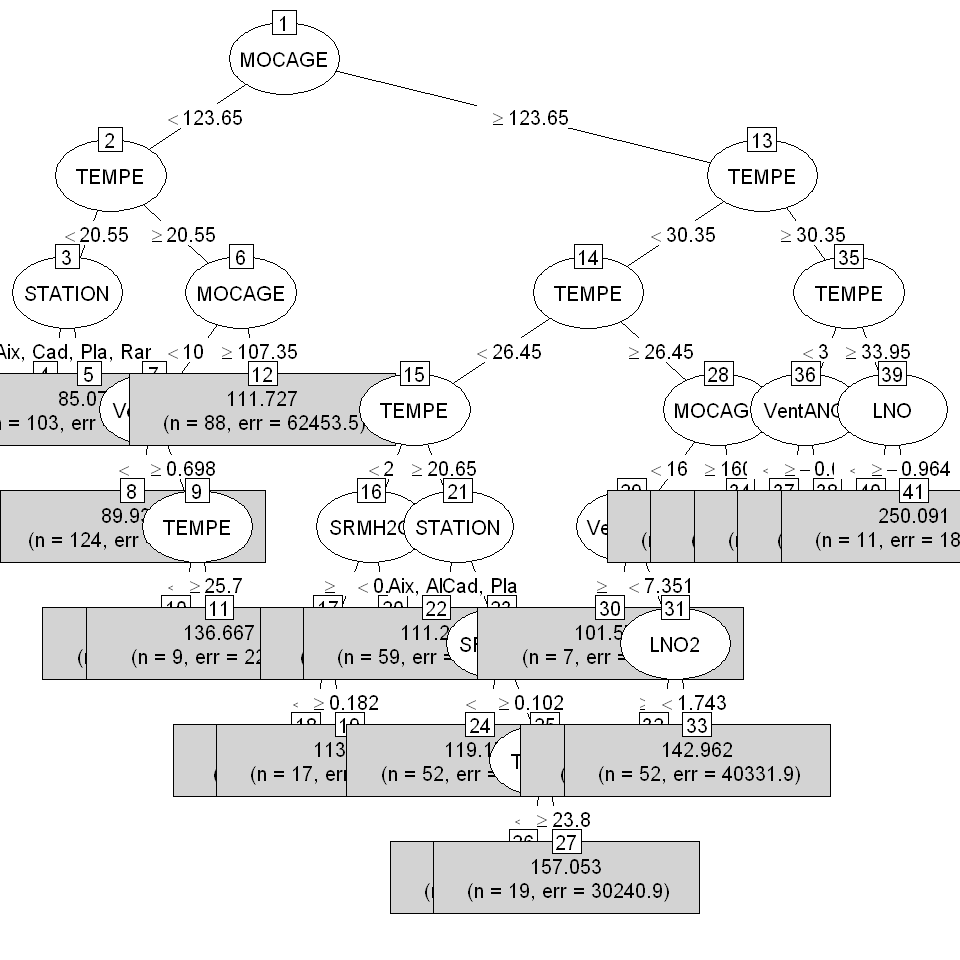

In [73]:
install.packages("partykit")
library(partykit)
plot(as.party(tree.reg), type="simple")

<font color = "purple"> On voit qu'avec une valeur de cp (cp = 0.010463131) qui minimise l'erreur de validation croisée, l'arbre optenu est + élagué que l'abre précédent (cp = 0.001)

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille. 

**Q** Quelle est la variable qui contribue le plus à l'interprétation?

Léa : Il s'agit de mocage, car elle permet de diminuer au maximum l'hétérogénéité (elle apparait au début de l'arbre). ATTENTION : ce n'est DONC pas la variable qui apparait le plus :)

Graphe des résidus

Léa : 

dans chaque case on a n=... qui correspond à avoir le nombre d'observations qui est tombée dans la feuille donnée. La valeur au dessus est la valeur de concentration d'ozone qui sera prédite dans par l'arbre (on l'obtient en faisant la moyenne des différentes valeurs de concentration de toutes les observations qui sont tombées dans cet arbre (car on est en régression). on a aussi l'erreur qui est une erreur d'apprentissage pour chaque feuilles. 

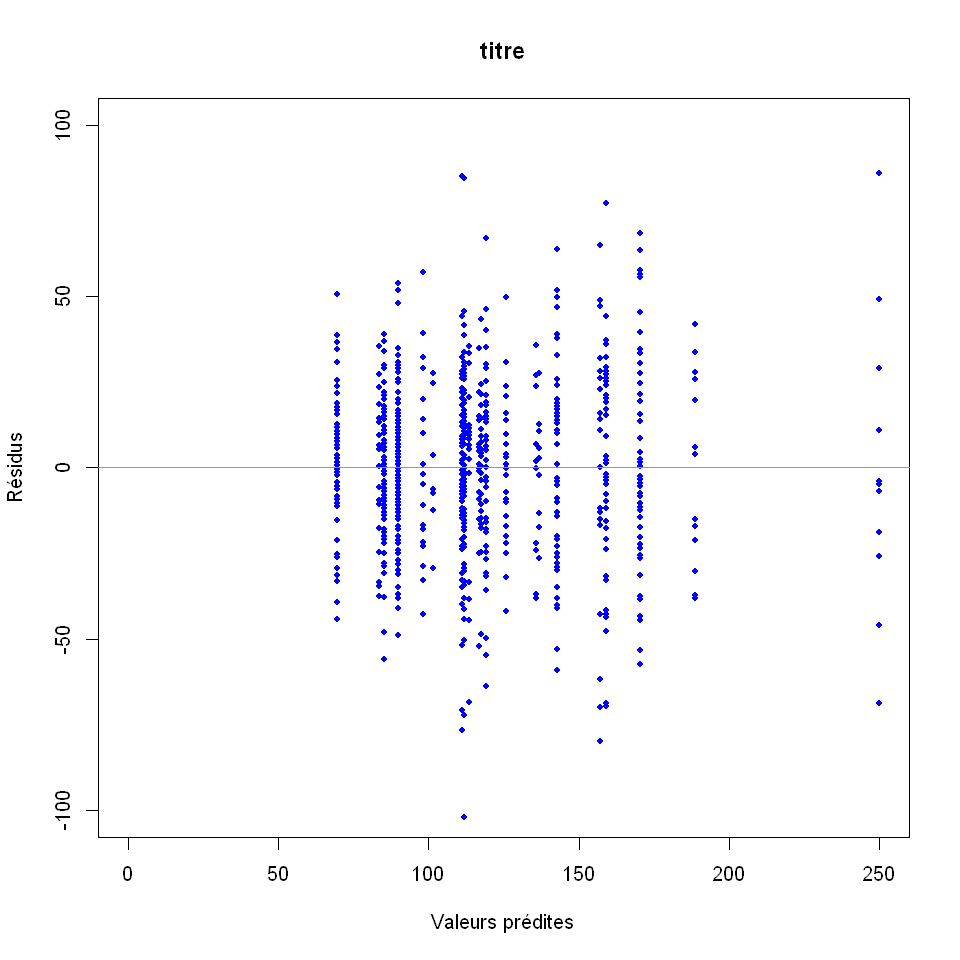

In [74]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
plot.res(fit.tree,res.tree)

**Q** A quoi est due la structure particulière de ce graphe?

Léa : La structure ^particulière du graphe est due au fait que les prédictions sont constantes par morceaux. Il y a autant de prédictions que de feuilles de l'arbre. D'où la forme striée du graphe (en abscisse chaque valeur correspond à la valeur d'un noeud)

### Estimation et élagage d'un arbre de discrimination

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités *a priori* (?rpart pour plus de détails).

**Q** Quel autre critère d'hétérogénéité est utilisé?

léa : un autre critère qui peut etre utilisé est la cross entropy. Cette valeur est minimale si seule une classe de Y est présente et maximale si toutes les classes sont présentes. On vise donc à minimiser ce critère dans le cas de la classification

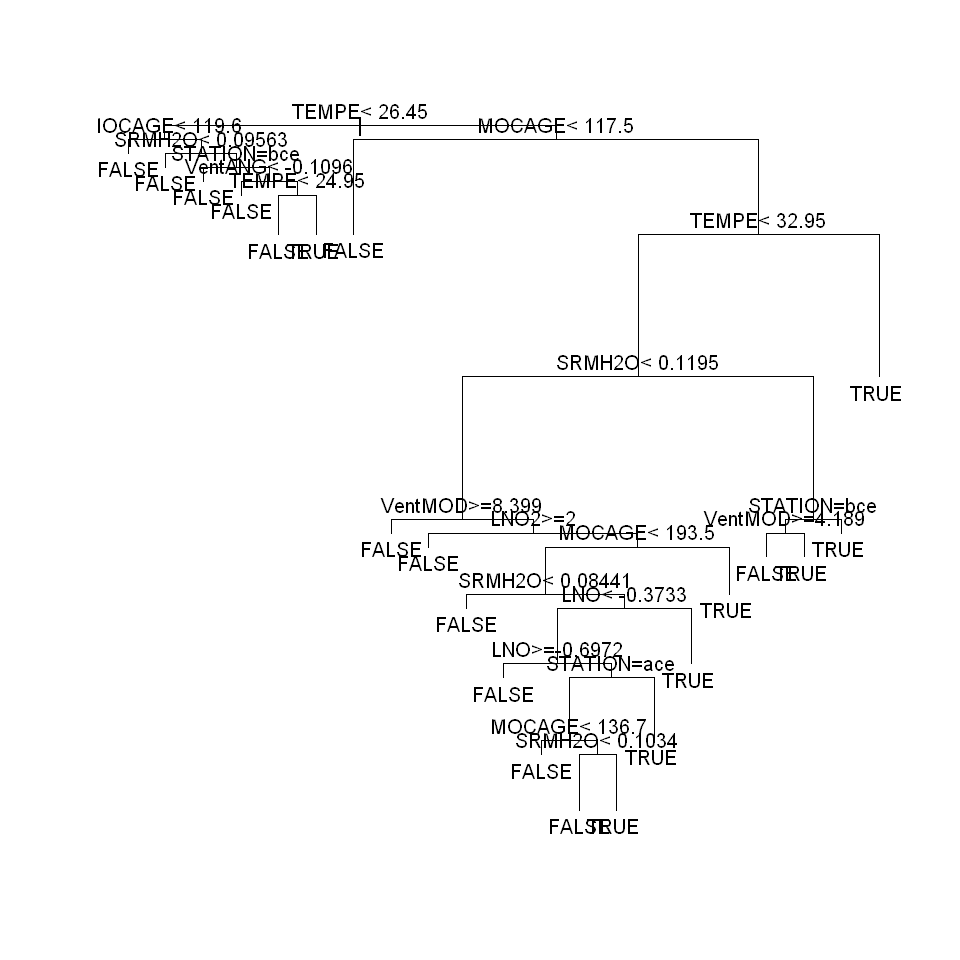

In [75]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
plot(tree.dis) 
text(tree.dis)  

La même procédure d'élagage par validation croisée est mise en place mais avec un expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [76]:
xmat = xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr=datappq$DepSeuil!= (xmat>1.5) 
# Calcul  des estimations des taux d'erreur
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

0.541666667 0.034020691 0.012028131 0.008505173 0.002635231 
  0.1730769   0.1394231   0.1430288   0.1418269   0.1454327

In [77]:
as.numeric(attributes(which.min(CVerr))$names)

[1] 0.03402069

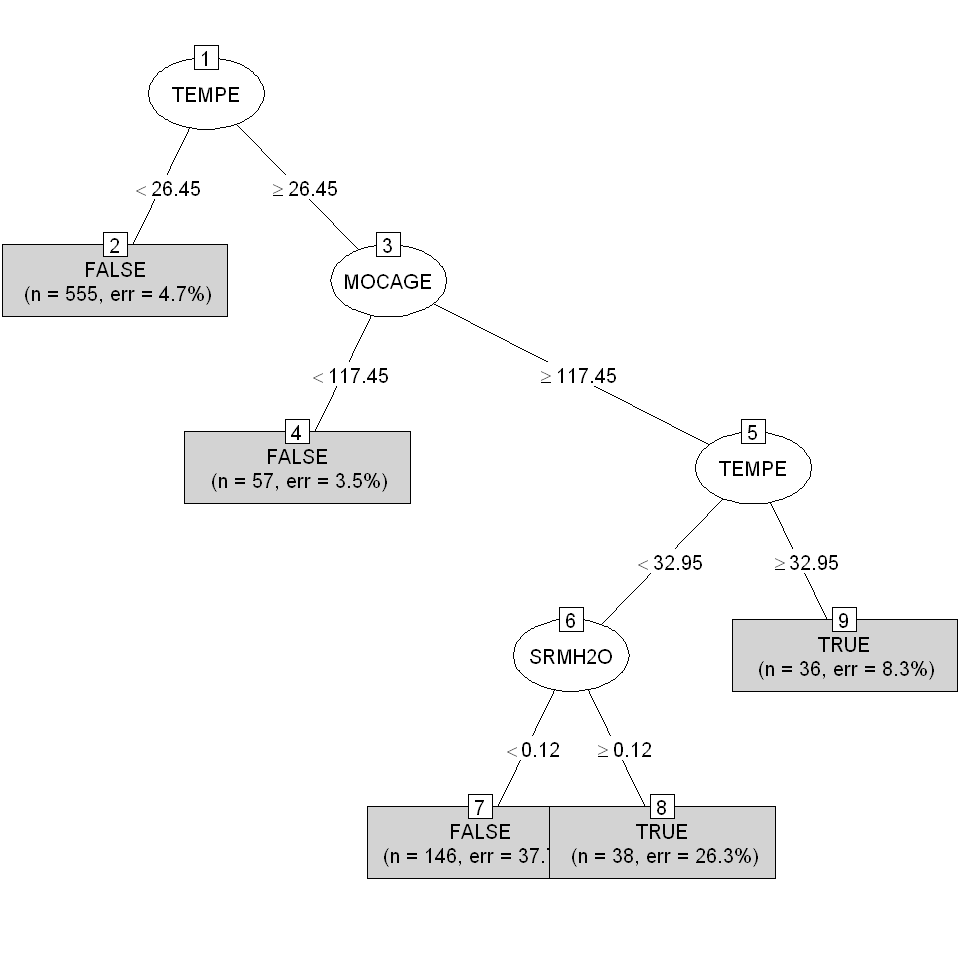

In [78]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),
               cp=as.numeric(attributes(which.min(CVerr))$names))
plot(as.party(tree.dis), type="simple")

- On prend la valeur de cp qu'on a repéré juste avant et qui nous permet de minimiser l'erreur et on construit notre arbre selon cette valeur. En comparaison avec ce qu'on avait avant, on constate qu'on a léagué toute la partie gauche de l'arbre, et tout le sous-argre sous la variables SRMH20.
- Dans chaque feuille, n est le nombre d'observations du set d'entrainement qui sont tombés dans la feuille. Par exemple dans la dernière feuille on a n=38, et on a err=26.3%. Cela signifie que parmi les observations, 26.3% n'ont pas la modalité de Y qui est prédite par **vote à la majorité** sur cette feuille. 

Léa : On est ici dans le cas de **classification binaire**. Pour chaque noeud, on met en place un vote de majorité (c'est à dire qu'on prédit la valeur au niveau d'une feuille en prenant la classe avec le plus grand effectif de valeurs observée dans une même feuille). Exemple dans le noeud prédit par TRUE avec n=38, on en déduit qu'il y a au moins 19 valeurs de l'arbre avec comme Y obs=TRUE

### Prévision de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 

#### Erreur de régression

In [79]:
# Calcul des prévisions
pred.treer=predict(tree.reg,newdata=datestr) #on prédit le set de test datestr (regression)
pred.treeq=predict(tree.dis,newdata=datestq,type="class") #on prédit le set de test datestq (classification -> seuil de dépassement)
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 711.7869

Léa : L'erreur ici est en régression : on calcule l'erreur quadratique entre les obs de Y de l'échatillon test et les valeurs prédites pour l'échantillon test avec l'arbre prédit (c'est à dire qu'on fait passer les observations dans l'arbre et on regarde dans quelle feuille il tombe et on donne la valeur prédite de la feuille à l'individu de l'échantillon test (cette valeur prédite est la moyenne des Y). 

#### Erreur de classification (matrice de confusion)

In [80]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.treer>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   161   16
  TRUE     14   18

Ici on a construit la matrice de confusion pour le set d'entrainement de la **regression**. On obtient pour chaque Y la valeur de la pluie (qui est la moyenne des valeurs des Y dans la feuille obtenue par le set d'entrainement) et on la compare avec le seuil 150 au dessus du quel on prédit un dépassement de la concentration maximal de l'ozone. 

Léa : On contruit une matrice de confusion entre les valeurs obs de Y de l'échatillon test et les valeurs prédites de classe pour l'échantillon test avec l'arbre prédit (c'est à dire qu'on fait passer les observations dans l'arbre et on regarde dans quelle feuille il tombe et on donne la valeur prédite de la feuille selon si elle est supérieure ou inférieure à 150 à l'individu de l'échantillon test. 

In [81]:
# Même chose pour l'arbre de discrimination
table(pred.treeq,datestq[,"DepSeuil"])

          
pred.treeq FALSE TRUE
     FALSE   169   22
     TRUE      6   12

Léa : L'erreur ici est en **classification** se voit en construisant une matrice de confusion entre les valeurs obs de Y de l'échatillon test et les valeurs prédites de classe pour l'échantillon test avec l'arbre prédit (c'est à dire qu'on fait passer les observations dans l'arbre et on regarde dans quelle feuille il tombe et on donne la classe prédite de la feuille à l'individu de l'échantillon test. 

**Q** Quelle stratégie semble meilleure à ce niveau?

Les résultats obtenus sur les deux tables sont très proches, il n'est pas posssible de dire si une stratégie est meilleure que l'autre. 

#### Courbes ROC

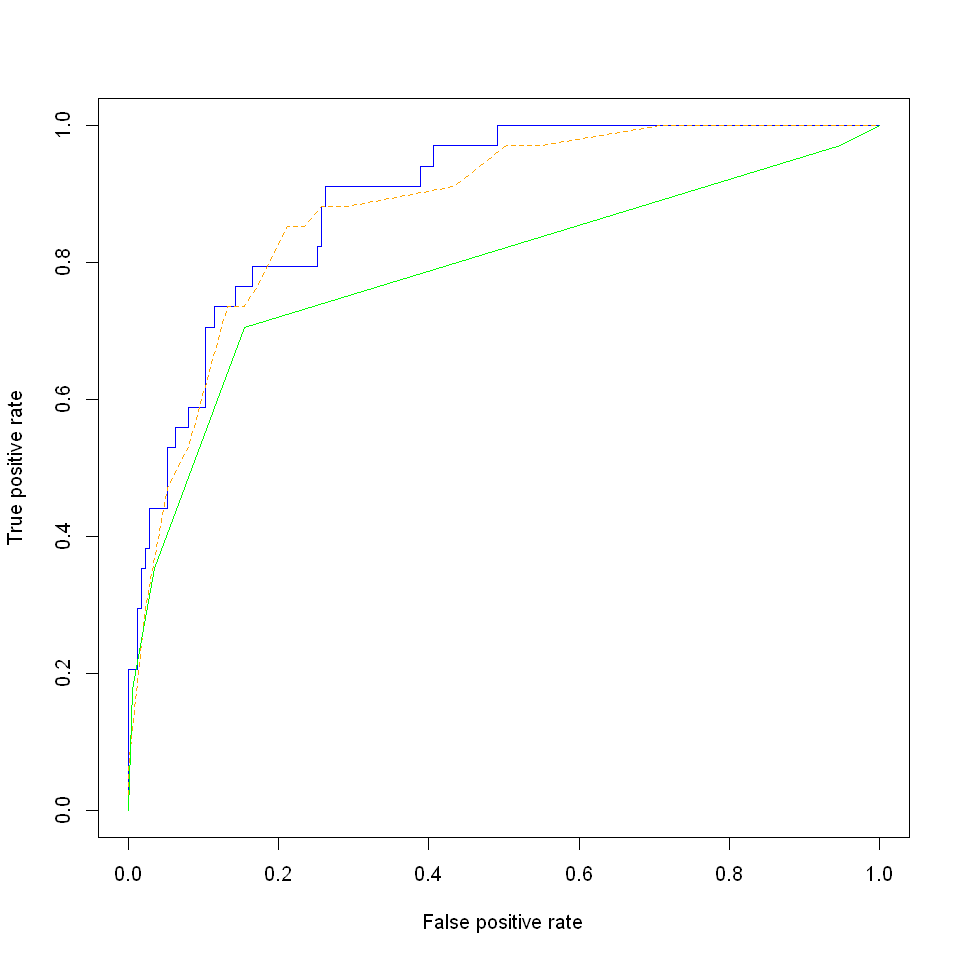

In [82]:
# pour la regression : 
ROCregtree=pred.treer/300 #remarque : diviser par 300 ne sert à rien (ne change rien au résultat)
predregtree=prediction(ROCregtree,datestq$DepSeuil) # la fonction performance doit prendre un paramètre de type prediction (rend notre objet compatible pour les ROC curves)
perfregtree=performance(predregtree,"tpr","fpr")
# pour la classification : 
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant 
# pour mieux comparer
plot(perflogit,col="blue") #rappel : perflogit <- performance(predlogit, "tpr", "fpr")
plot(perfregtree,col="orange",lty=2,add=TRUE) 
plot(perfdistree,col="green",add=TRUE)

help(prediction)

Comparer les qualités  de prévision.

**Q** Une meilleure méthode se dégage-t-elle?

On regarde la méthode pour laquelle l'AUC est la plus grande. Ici il s'agit de la regression logistique. On ne peut pas trop différencier les performances des arbres construit sur l'échantillon de regression ou de classification. Pour pouvoir établir lequel est le meilleur, on se fixe un seuil donné, par exemple $s=0.9$ et on regarde quelle courbe franchit ce seuil en premier. 

# <FONT COLOR="Red">Épisode 3</font>

## [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

<font color = "purple"> violet = notes lila :)
<font color = "black"> noir = notes juju :)   
 

### Introduction

Il s'agit d'estimer un modèle de type *perceptron* avec en entrée les variables qualitatives ou quantitatives et en sortie la variable à prévoir. Des fonctions R pour l'apprentissage d'un perceptron élémentaire ont été réalisées par différents auteurs et sont accessibles sur le réseau. La librairie `nnet` de (Ripley, 1999), est limitée au perceptron à une couche. Ce n'est pas de l'*apprentissage profond* ! mais suffisant dans bien des cas. Une librairie R associée au logiciel éponyme H2O propose des réseaux à plusieurs couches et "convolutionnels".

Comme pour les arbres, la variable à expliquer est soit quantitative soit qualitative ; la fonction de transfert du neurone de sortie d'un réseau doit être adaptée en conséquence. 

**Q** Quelle fonction de transfert pour le dernier neurone en régression ?

En regression : $\Psi = Identité$ (pas de fonction d'activation appliquée) </font> (p.94 poly)

**Q** Quelle fonction de transfert pour le dernier neuronne en discrimination binaire?

En classification binaire : fonction sigmoïde $\Psi (x) = \frac{1}{1+e^{-x}} $

**Q** Quid de la discrimination avec plusieurs classes?

En classification multiclasse : fonction softmax multidimensionnelle : ième composante du softmax : $\Psi (x) = \frac{exp(z_i)}{\sum_j{exp(z_j)}} $

**Q** Quel est le choix par défaut pour les neurones de la couche cachée?

La fonction d'activation par défaut sur les couches cachées est la fonction sigmoid : $\phi (x) = \frac{1}{1+e^{-x}}$ (sur les réseaux de neurones historiques des années 80). 

Sur les CNN(convolution neural network) c'est RELU.

Remarque : sur le deep learning avec python c'est RELU. 

Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première conciste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage (832) est modeste pour une application raisonnable du perceptron. Seuls des nombres restreints de neurones peuvent être considérés et sur une seule couche cachée. 

**Q** Quel est le paramètre `decay` de la fonction `nnet`?

`decay` : parameter for weight decay. Default 0. C'est un paramètre de régularisation pour éviter l'over-fitting. C'est le terme de pénalisation $\Omega(\theta)$ dans la formule p95 : $L_n(\theta) = \frac{1}{n}\sum_{i=1}^n {l(Y_i,f(X_i,\theta))} +\lambda \Omega(\theta)$
<font color = "purple"> le paramètres $\lambda$ qui permet de pénaliser la compléxité du modèle </font> 

**Q** Indiquer une autre façon déviter le sur-apprentissage.

Aujourd'hui, on utilise le **drop-out** qui consiste à mettre à 0 certains poids du réseau pour une certaine probabilité p et indépendemment des autres (p101).

In [83]:
help(decay)

### Cas de la régression

In [84]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  71
initial  value 12573999.475708 
iter  10 value 1479414.021144
iter  20 value 1158582.410600
iter  30 value 1108293.549263
iter  40 value 1011108.413533
iter  50 value 875790.022461
iter  60 value 811177.956537
iter  70 value 753990.223616
iter  80 value 693798.245032
iter  90 value 679461.732065
iter 100 value 653182.654383
iter 110 value 628265.229651
iter 120 value 623169.126622
iter 130 value 616467.197666
iter 140 value 600619.351106
iter 150 value 591885.959221
iter 160 value 582033.428283
iter 170 value 574601.777248
iter 180 value 570368.943219
iter 190 value 565887.106292
iter 200 value 558405.808818
iter 210 value 535208.468239
iter 220 value 522314.967740
iter 230 value 518407.246483
iter 240 value 515385.183367
iter 250 value 510547.505649
iter 260 value 508338.958730
iter 270 value 497870.479509
iter 280 value 485626.871338
iter 290 value 477320.962599
iter 300 value 474444.167219
iter 310 value 473111.206522
iter 320 value 470031.814068
iter 330 value 469176

a 12-5-1 network with 71 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  25.40   -0.50    0.03   -0.55   -2.05   -0.61   -3.96   -1.63   -0.12    0.12 
i10->h1 i11->h1 i12->h1 
 -25.61   -4.08    3.24 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  23.69   -9.48    0.44   -1.74   15.41  -21.90    0.76  -18.85   -1.54   -3.03 
i10->h2 i11->h2 i12->h2 
  13.03    0.61    3.24 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  -0.50   -0.07    0.01    0.11   -1.34    1.35    0.35    0.58    0.00    0.38 
i10->h3 i11->h3 i12->h3 
 -12.62   -0.83    0.52 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
   2.89    1.86    0.17    0.92    4.22    4.68    2.61   -5.59   -1.60   -0.80 
i10->h4 i11->h4 i12->h4 
  20.19  -25.74   26.32 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9

La commande donne la "trace" de l'exécution avec le comportement de la convergence mais le détail des poids de chaque entrée de chaque neurone ne constituent pas des résultats très explicites ! Contrôler le nombre de poids estimés.

L'optimisation des paramètres nécessite encore le passage par la validation croisée. Il n'y a pas de fonction dans la librairie `nnet` permettant de le faire mais la fonction ` tune.nnet` de la librairie `e1071` est adaptée à cette démarche.

`tune.nnet` consiste à faire une grille de test : on fait varier 
- size (c'est le nombre de neurones par couche) sur une plage de valeur
- decay sur 1,2,3

Puis on choisit les deux valeurs qui nous permettent de minimiser l'erreur (là où le graphe est le plus foncé). Ici c'est size = 3 et decay = 2 (attention il faut prendre desvaleurs entières !)

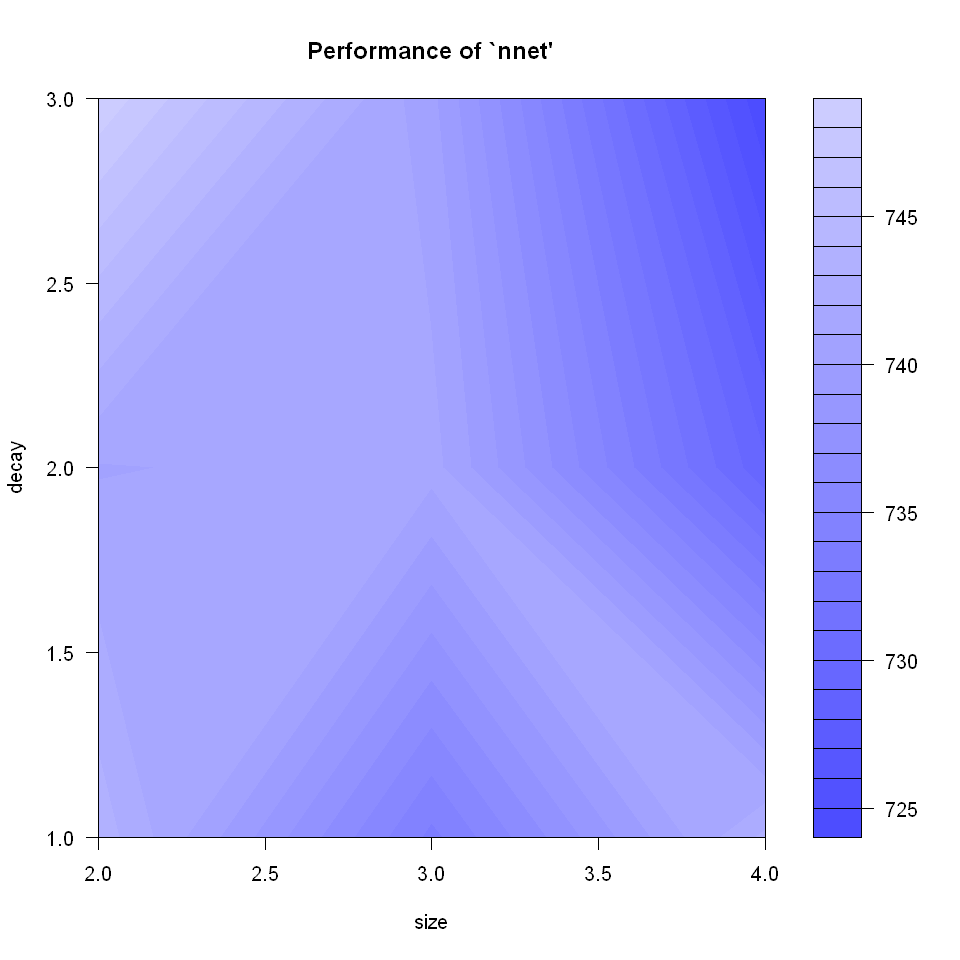

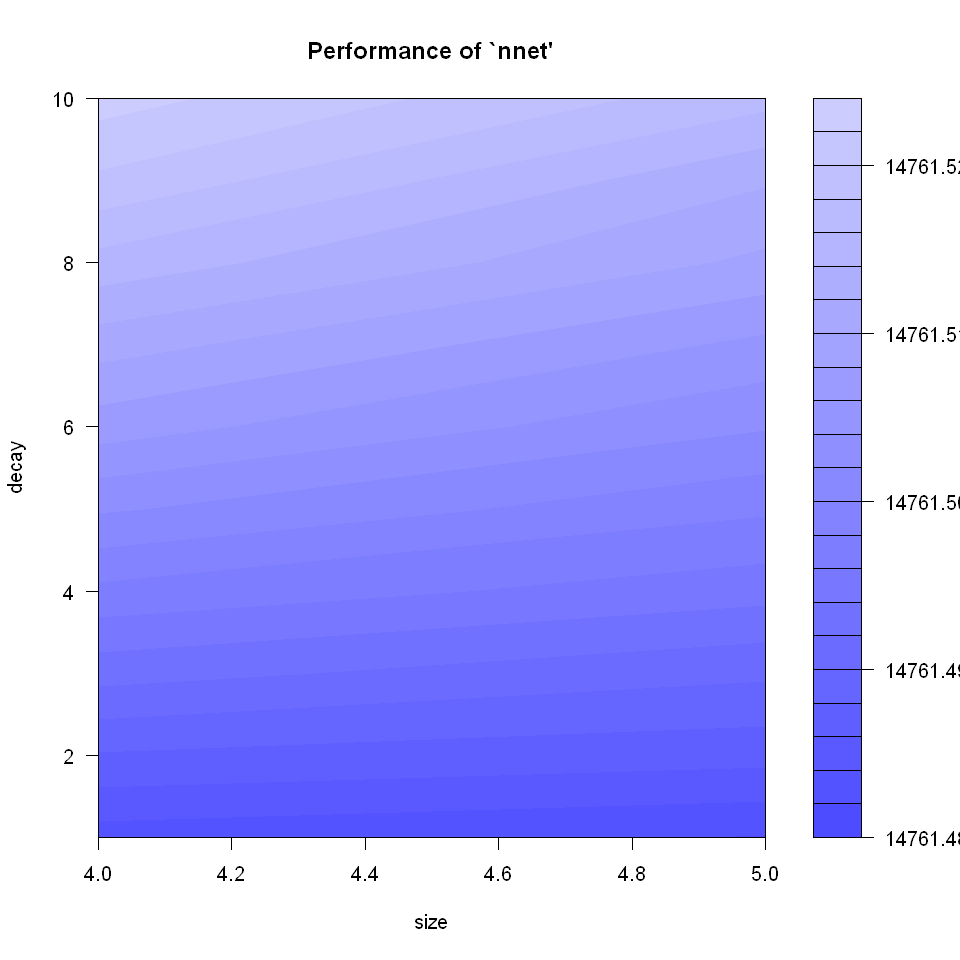

In [85]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

<font color = "purple"> Le paramètre size est le nombre de neurons contenu dans chaque couche de neurone. Ici les graphes correspondent à l'erreur que l'on cherche à minimiser. On prendra les paramètres pour lesquels le graphe est le plus bleu. </font>

Faire éventuellement varier la grille des paramètres (zoom), noter la taille et le `decay` optimaux. Il faudrait aussi  faire varier le nombre total d'itérations. Cela risque de prendre un peu de temps ! Noter également que chaque exécution donne des résultats différents... il n'est donc pas très utile d'y passer beaucoup de temps !

Ré-estimer le modèle supposé optimal avant de tracer le graphe des résidus. 

# weights:  43
initial  value 12486933.663557 
iter  10 value 1423173.742401
iter  20 value 1378923.498224
iter  30 value 1268640.317091
iter  40 value 1036389.986766
iter  50 value 932397.281885
iter  60 value 904896.190602
iter  70 value 832089.784865
iter  80 value 799446.312945
iter  90 value 765907.596908
iter 100 value 712487.981767
iter 110 value 604665.037702
iter 120 value 590210.344681
iter 130 value 579616.148939
iter 140 value 578446.270159
iter 150 value 578336.636482
iter 160 value 578332.309194
iter 170 value 578322.992060
iter 180 value 578180.487321
iter 190 value 578063.749500
iter 200 value 578015.215628
final  value 578015.215628 
stopped after 200 iterations


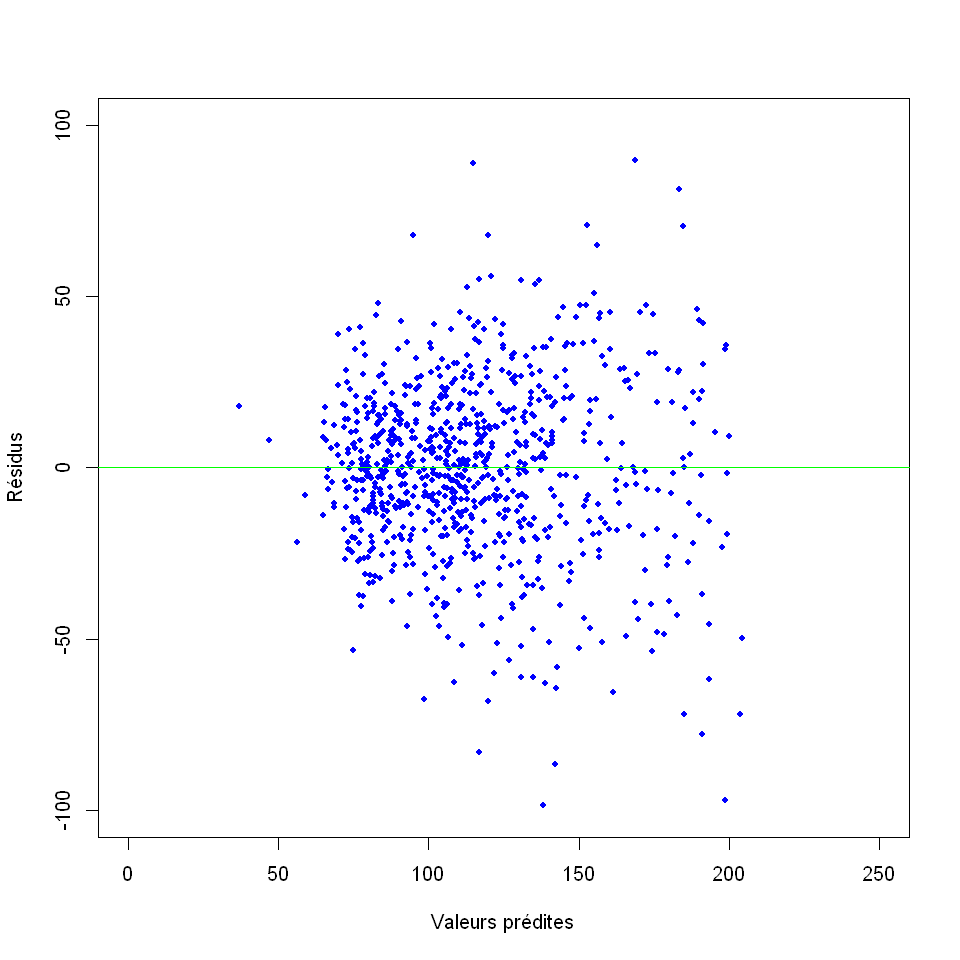

In [86]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
plot.res(fit.nnetr,res.nnetr,titre="")

**Remarque :** Ici on a mis la valeur optimale qu'on avait trouvé pour decay et size. On voit qu'on n'a plus que 43 poids, on a donc réduit le nombre de paramètres à évaluer. 

### Cas de la discrimination

On refait la même chose dans le cas de la classification 

In [87]:
# apprentissage
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0) 
summary(nnet.reg)

# weights:  71
initial  value 678.746750 
iter  10 value 371.755167
iter  20 value 357.163755
iter  30 value 352.670356
iter  40 value 322.993065
iter  50 value 267.214886
iter  60 value 229.379472
iter  70 value 211.446836
iter  80 value 204.623313
iter  90 value 202.874101
iter 100 value 201.396930
final  value 201.396930 
stopped after 100 iterations


a 12-3-1 network with 43 weights
options were - linear output units  decay=2
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
 -12.09    0.33    0.02    0.37    1.29    0.93    1.99    0.30   -0.10    0.03 
i10->h1 i11->h1 i12->h1 
  21.17   -1.97    2.41 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.37   -0.34    0.03    0.09   -1.42   -0.31    0.68   -0.55   -0.14    0.47 
i10->h2 i11->h2 i12->h2 
 -23.02   -0.89    0.58 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  -1.30    2.06    0.38   -0.50   -1.34   -0.15   -0.04   -0.17   -0.63   -1.00 
i10->h3 i11->h3 i12->h3 
  -0.07   -3.29   -1.46 
  b->o  h1->o  h2->o  h3->o 
 26.43  96.71  54.16  35.32 

La validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence : 
- nombre de neurones, 
- `decay` 
- et éventuellement le nombre max d'itérations. 

L'initialisation de l'apprentissage d'un réseau de neurone comme celle de l'estimation de l'erreur par validation croisée sont aléatoires. Chaque exécution donne donc des résultats différents. À ce niveau, il serait intéressant de construire un plan d'expérience à deux facteurs (ici, les paramètres de taille et `decay`) de chacun trois niveaux. Plusieurs réalisations pour chaque combinaison des niveaux suivies d'un test classique d'anova permettraient de se faire une idée plus juste de l'influence de ces facteurs sur l'erreur. 

Noter la taille et le `decay` optimaux et ré-estimer le modèle pour ces valeurs : 
- decay = 1
- size = 4

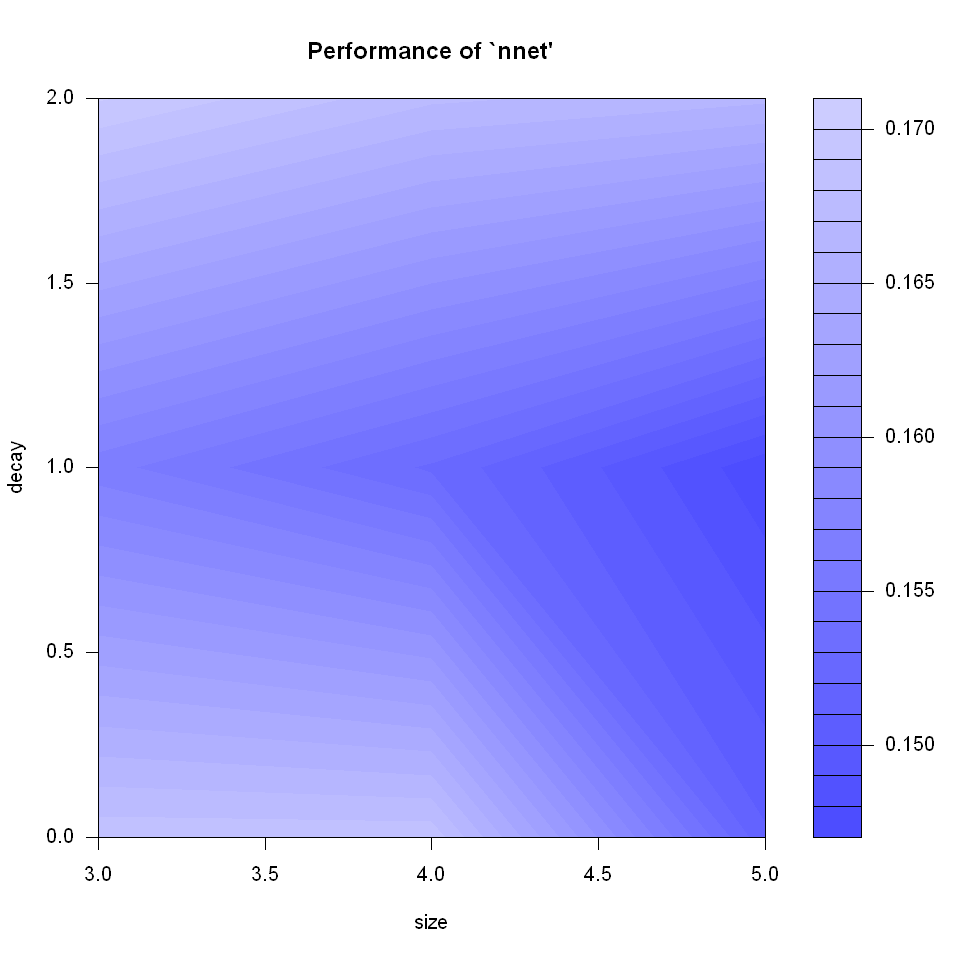

In [88]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

In [89]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=4,decay=1) 

# weights:  57
initial  value 446.955282 
iter  10 value 384.357666
iter  20 value 384.013416
iter  30 value 383.879886
final  value 383.878843 
converged


**Remarque :** Ici on a mis la valeur optimale qu'on avait trouvé pour decay et size. On voit qu'on n'a plus que 57 poids (au lieu de 71), on a donc réduit le nombre de paramètres à évaluer. 

### Prévisions de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 


#### Erreur de régression

In [90]:
# Calcul des prévisions
pred.nnetr=predict(nnet.reg,newdata=datestr) #regression
pred.nnetq=predict(nnet.dis,newdata=datestq) #classification
# Erreur quadratique moyenne de prévision
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr) #dans le cas de la regression

[1] 599.1917

#### Erreur de classification (matrice de confusion)

In [91]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   166   20
  TRUE      9   14

In [92]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])

       
        FALSE TRUE
  FALSE   175   34

#### Courbes ROC

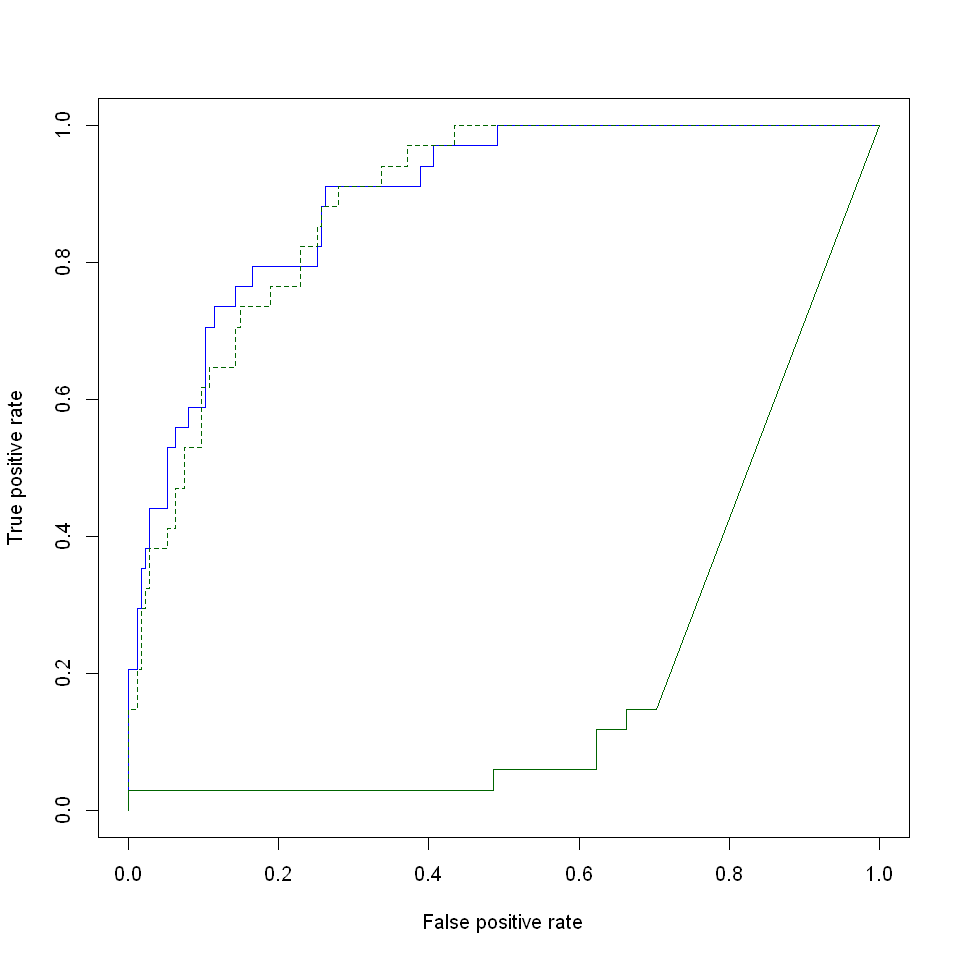

In [93]:
library(ROCR)
rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")

rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")

# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue")
plot(perfnnetr,col="darkgreen",lty=2,add=TRUE) 
plot(perfnnetq,col="darkgreen",add=TRUE)  

**Q** Une méthode semble-t-elle significativement meilleure?

Les 3 courbes se croisent beacoup, on ne peut pas dire qu'une méthode est meilleure que l'autre.

## [Agrégation de modèles](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

**Remarque** : Prédiction avec une forêt : on fait passer une observation dans chaque arbre de la forêt et pour chaque arbre on obtient une prédiction. 
- Dans le cas de la classification, la prédiction renvoyée par la forêt sera faite par vote majoritaire des résultats renvoyés par chaque arbre. 
- Dans le cas de la regression, la prédiction renvoyée par la forêt sera faite par moyenne des valeurs prédites par chaque arbre. 

### Introduction

Les sections précédentes ont permis d'expérimenter les constructions d'un modèle de prévision assorties du problème récurrent lié à l'optimisation de la complexité d'un modèle. Cette section aborde d'autres stratégies dont l'objectif est de s'affranchir de ce problème de choix, par des méthodes se montrant pas ou très peu sensibles au sur-apprentissage ; c'est le cas des algorithmes d'agrégation de modèles.

Cette section propose de mettre en évidence la plus ou moins grande influence des paramètres de ces méthodes. 
* *Random forest*: nombre d'arbres et `mtry` et intérêt des critères de Breiman permettant de mesurer l'influence des variables au sein d'une famille agrégée de modèles. 
* Le *bagging*, cas particulier de forêt aléatoire, n'est pas traité;
* *Boosting*: profondeur d'arbre, nombre d'itérations ou d'arbres et coefficient de *shrinkage*.

**Q** Quel est le paramètre `mtry` de la fonction `randomForest`?

`mtry` : nombre de variables qui sont choisies aléatoirement comme candidat possible à chaque split. Les valeurs par défaut de m sont :
- $ m = \frac{p}{3}$ dans le cas de la regression
- $ m = \sqrt{p} $ dans le cas de la classification

avec p = nombre de variables total

**Q** En quoi le bagging est un cas particulier des forêts aléatoires?

Léa : Cela permet à partir d'un seuil ensemble de datas, de créer plusieurs échantillons (obtenus par tirage avec remise à partir du jeu de données original). C'est un cas particulier par rapport à l'algorithme de random forest, car dans ce cas on ne ferait pas de sélection aléatoire de m variables à chaque noeud. 

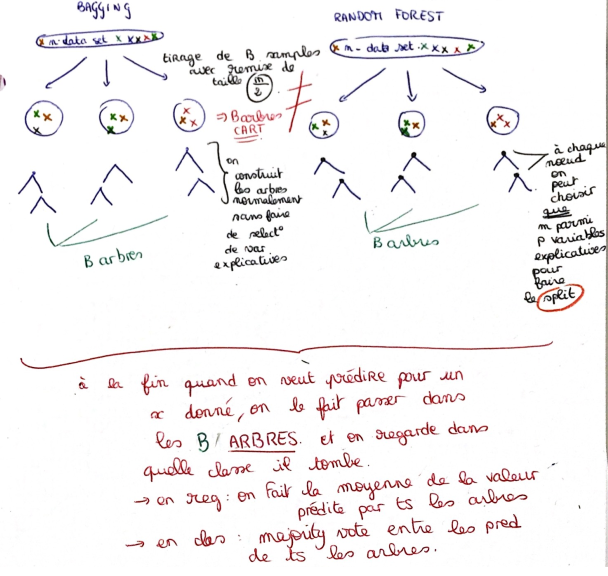

### Forêts aléatoires

Le programme est disponible dans la librairie *randomForest*. Il est écrit en fortran, donc en principe efficace en terme de rapidité d'exécution, et facile à utiliser grâce à une interface avec R. La comparaison avec Python montre qu'il n'est finalement pas très efficace sans doute à cause de l'interface avec R. Les paramètres et sorties sont explicités dans l'aide en ligne.

En R et pour des gros fichiers, privilégier la librairie `ranger` à la place de `ranfomForest`. 

In [94]:
library(randomForest)
help(randomForest)

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.



#### Régression

- `ntree` : Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times. 
- `importance` : importance des prédicteurs

In [95]:
library(randomForest)
rf.reg=randomForest(O3obs~., data=datappr,xtest=datestr[,-2],ytest=datestr[,"O3obs"], #datestr[,-2] : on enlève O3obs qui est à prédire
   ntree=500,do.trace=50,importance=TRUE)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |    696.3    40.66 |      604    39.05 |
 100 |    697.1    40.70 |    581.1    37.57 |
 150 |    696.3    40.66 |    570.4    36.88 |
 200 |    691.3    40.37 |    575.6    37.22 |
 250 |    690.6    40.32 |    572.7    37.03 |
 300 |    683.8    39.93 |    570.7    36.90 |
 350 |      678    39.59 |      576    37.25 |
 400 |    681.3    39.78 |    572.2    37.00 |
 450 |    683.8    39.93 |    571.5    36.96 |
 500 |      684    39.94 |    573.3    37.07 |


**Remarque : ce que fait le test ci-dessus**
- Au début du TP on avait isolé un échantillon de test (colonne de droite ici). Cet échantillon est totalement indépendant de l'échantillon d'entraînement. Pour prédire son MSE et sa vériance on le prédit sur toute la forêt. Dans la réalité, on a souvent pas assez de données pour pouvoir isoler cet échantillon de test sasn impacter négativement les résultats que l'on obtient. 
- Ici on compare l'erreur qu'on a sur cet échantillon de test avec celui qu'onb a sur les données Out-Of-Bag. Quand on fait du bootstrap sampling, on observe qu'on ne pioche jamais un certain pourcentage de données. Ces données servent alors d'échantillon de test (c'est les données out-of-bag). Pour les prédire, on prédit chaque arbre sur ses propres données Out-Of-Bag puis on fait la moyenne de ses valeurs sur tous les arbres, et c'est cette prédiction que renverra la forêt. 

Ainsi on constate que faire un test ou l'autre est différent au niveau du concept, on peut s'attendre à des différences au niveau des résultats. Notamment, dans le cas des données Out-Of-Bag, les échantillons ne sont pas indépendants entre eux, donc la réduction de variance obtenue sera plus faible que dans le cas d'un échantillon de test totalement indépendant

Léa : 
**Rappel principe de random forest :**
- on construit ici 500 arbres CART (où pour chacun à chaque noeud, on autorise que de choisir parmi m variables explicatives (m<p)). Cela permet de choisir des variables de séparation au niveau des noeuds qui n'auraient pas été choisies car il y en aurait eu des meilleures sinon. 
- Ensuite on fait une étape d'agrégation c'est à dire qu'en classifcation on prédit pour chaque arbre la valeur $\hat{Y}$ d'un x_0 qu'on souhaite prédire, puis on fait un vote de majorité parmi tous les $\hat{Y}$. Sinon, si on est en régression on fait la moyenne entre tous les $\hat{Y}$ prédits par les 500 arbres. 

**Rappel sur les out of bag :**
ici les out of bag permettent pour chaque noeuds, d'avoir des échantillons tests c'est à dire qui n'ont pas été tirés dans 'étape de bootstrapping. On calcule l'erreur grace à cela 

In [96]:
attributes(rf.reg)
rf.reg$mtry

$names
 [1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

[1] 3

**Q** Quelles est la valeur par défaut de `mtry`?

la valeur par défaut : $mtry = 3$ car on a au total $p=9$ variables (on le voit qd on fait un head(datestr) sans compter la variable à prédire O3obs.

Relancer en faisant varier les paramètres `mtry` et `ntree` pour expérimenter leur peu d'influence sur les erreurs.

Calcul et graphe des résidus.

In [97]:
#modifier mtry :
rf.reg2=randomForest(O3obs~., data=datappr,xtest=datestr[,-2],ytest=datestr[,"O3obs"], #datestr[,-2] : on enlève O3obs qui est à prédire
   ntree=500,mtry = 8, do.trace=50,importance=TRUE)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |    724.1    42.28 |    583.5    37.73 |
 100 |    709.2    41.41 |    583.6    37.74 |
 150 |      707    41.28 |    579.8    37.49 |
 200 |    702.2    41.00 |    580.7    37.55 |
 250 |      701    40.93 |    583.9    37.76 |
 300 |    701.4    40.96 |    585.2    37.84 |
 350 |    698.2    40.77 |    585.7    37.88 |
 400 |    698.2    40.77 |    585.6    37.86 |
 450 |    696.5    40.67 |      586    37.89 |
 500 |    696.7    40.68 |    587.1    37.96 |


Quand `mtry` augmente :
- MSE et Var(y) du Out-of-Bag diminuent 
- MSE et Var(y) du test set augmentent

Quand `mtry` diminue : sur les deux set :
- Le MSE augmente 
- La variance diminue 

In [98]:
#modifier ntree :
rf.reg2=randomForest(O3obs~., data=datappr,xtest=datestr[,-2],ytest=datestr[,"O3obs"], #datestr[,-2] : on enlève O3obs qui est à prédire
   ntree=800, do.trace=50,importance=TRUE)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |    720.2    42.05 |    576.3    37.27 |
 100 |    700.1    40.88 |      566    36.60 |
 150 |    686.7    40.10 |    563.9    36.46 |
 200 |    692.5    40.44 |    571.6    36.96 |
 250 |    687.3    40.13 |    572.3    37.00 |
 300 |      688    40.17 |    571.3    36.94 |
 350 |    686.6    40.09 |    569.2    36.81 |
 400 |    685.6    40.03 |    566.4    36.62 |
 450 |    684.2    39.95 |    566.1    36.61 |
 500 |    683.1    39.89 |    567.5    36.70 |
 550 |    683.1    39.89 |    568.2    36.74 |
 600 |    681.6    39.80 |    570.1    36.86 |
 650 |    682.5    39.85 |    570.6    36.90 |
 700 |    682.9    39.87 |    569.6    36.83 |
 750 |    683.4    39.90 |    568.6    36.77 |
 800 |    683.3    39.90 |      567    36.67 |


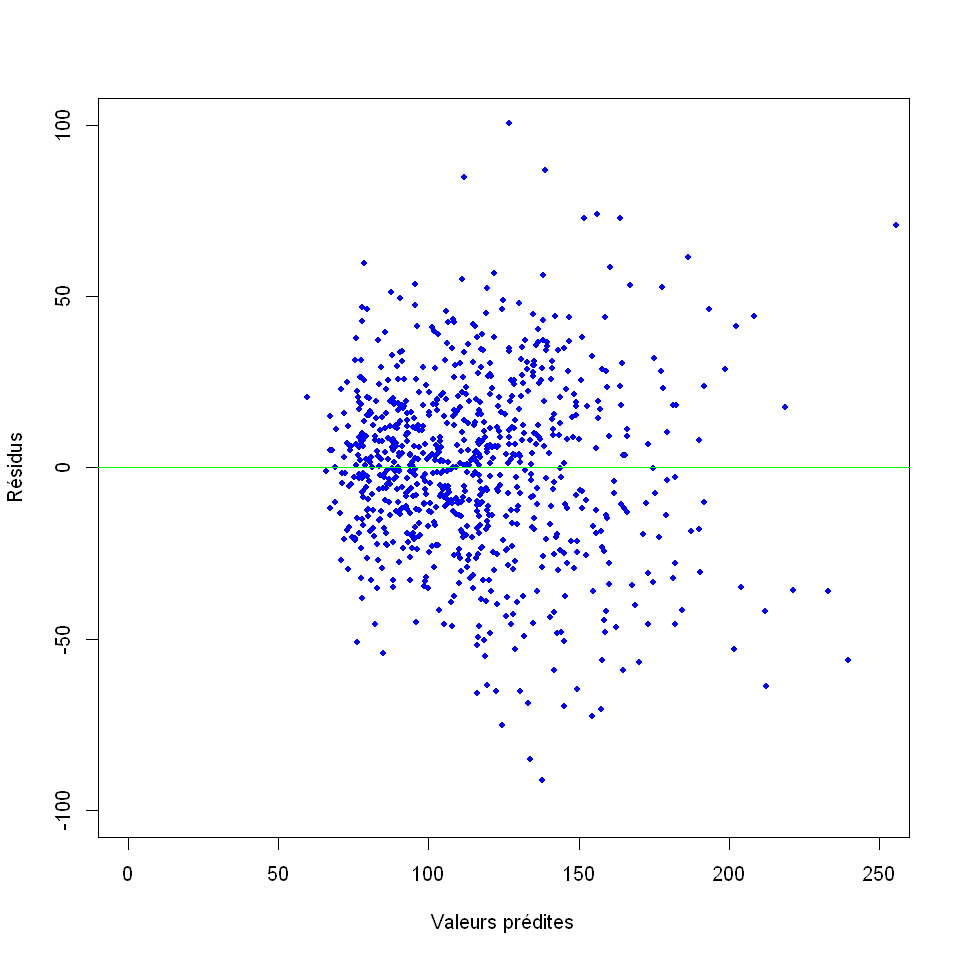

In [99]:
# calcul des résidus :
fit.rfr=rf.reg$predicted
res.rfr=fit.rfr-datappr[,"O3obs"]
plot.res(fit.rfr,res.rfr,titre="")

#### Discrimination
**Q** Quelle est la valeur par défaut de `mtry`?

$ m = \sqrt{p} $ dans le cas de la classification

Donc ici $m=\sqrt{9}=3$

In [100]:
rf.dis=randomForest(DepSeuil~.,data=datappq,xtest=datestq[,-10],ytest=datestq[,
   "DepSeuil"],ntree=500,do.trace=50,importance=TRUE)

ntree      OOB      1      2|    Test      1      2
   50:  13.22%  5.23% 51.39%|  10.53%  1.14% 58.82%
  100:  12.02%  4.65% 47.22%|  11.48%  1.71% 61.76%
  150:  11.66%  4.22% 47.22%|  11.00%  1.14% 61.76%
  200:  11.30%  3.92% 46.53%|  11.00%  1.14% 61.76%
  250:  11.18%  3.63% 47.22%|  11.00%  1.14% 61.76%
  300:  10.94%  3.49% 46.53%|  11.00%  1.14% 61.76%
  350:  10.94%  3.49% 46.53%|  11.00%  1.14% 61.76%
  400:  10.94%  3.49% 46.53%|  11.00%  1.14% 61.76%
  450:  10.70%  3.34% 45.83%|  11.00%  1.14% 61.76%
  500:  10.58%  3.49% 44.44%|  11.48%  1.71% 61.76%


In [101]:
rf.dis$importance

,FALSE,TRUE,MeanDecreaseAccuracy,MeanDecreaseGini
JOUR,-0.0001469635,-0.001611962,-0.0004135539,1.573505
MOCAGE,0.0053293181,0.113007480,0.0241741453,41.968124
TEMPE,0.0271366894,0.222677273,0.0610107667,73.724937
STATION,0.0095775849,0.026640612,0.0124988345,11.754967
VentMOD,0.0058189991,0.007635979,0.0061380984,18.816076
VentANG,0.0054475601,0.048192767,0.0129239366,25.177034
SRMH2O,0.0023977860,0.059499901,0.0123150677,28.475196
LNO2,0.0100927423,0.007082368,0.0094912152,18.197147
LNO,0.0095480617,0.006017608,0.0089199474,17.869923


Il y a deux critères d'importance MDI et MDA. Ils sont calculés après avoir construit notre foret (car on ne peut pas comme pour les arbres prendre la variable le plus en haut car on a plusieurs arbres). On prend la variable qui la plus grand importance.

In [102]:
summary(rf.reg$importance)

    %IncMSE       IncNodePurity   
 Min.   :  1.36   Min.   : 10673  
 1st Qu.: 78.97   1st Qu.: 76597  
 Median :109.06   Median : 95939  
 Mean   :223.40   Mean   :152068  
 3rd Qu.:164.12   3rd Qu.:121149  
 Max.   :836.35   Max.   :431977  

In [103]:
help(randomForest)

In [104]:
rf.dis$mtry 

[1] 3

Léa : on est en classfication, donc on a m (le nombre de variables choisies aléatoirement à chaque noeud)= racine de p par défaut avec p le nombre de variables explicatives (ici 9, donc m=3). Remarque : on peut aussi choisir m par cross validation

Commenter les erreurs, tester d'autres exécutions avec d'autres valeurs des paramètres.

#### Importance des variables

Le modèle obtenu est ininterprétable mais des coefficients estiment les contributions des variables dans leur participation à la discrimination. Comparer avec les variables sélectionnées par les autres modèles. deux critères d'importance sont proposés.

**Q** Quelles sont les deux mesures d'importance des variables?

Léa La première est le MDI (IncNodePurity) pour la régression et pour la classfication ici c'est la MeanDecreaseGini (surement MDA mais à véfier !!!!) 

In [105]:
round(importance(rf.reg), 2)

,%IncMSE,IncNodePurity
JOUR,0.76,10673.27
MOCAGE,36.46,358548.18
TEMPE,54.68,431976.75
STATION,22.64,74845.47
VentMOD,13.00,95938.88
VentANG,14.72,121148.78
SRMH2O,16.12,114021.18
LNO2,14.89,84861.97
LNO,13.04,76596.58


In [106]:
round(importance(rf.dis), 2)

,FALSE,TRUE,MeanDecreaseAccuracy,MeanDecreaseGini
JOUR,-0.90,-2.43,-2.55,1.57
MOCAGE,5.05,28.96,22.36,41.97
TEMPE,22.55,57.06,48.56,73.72
STATION,12.01,12.27,16.51,11.75
VentMOD,9.14,3.60,9.88,18.82
VentANG,6.69,17.20,14.95,25.18
SRMH2O,3.35,21.60,16.19,28.48
LNO2,11.32,2.80,11.88,18.20
LNO,10.23,2.78,11.07,17.87


In [107]:
sort(round(importance(rf.reg), 2)[,1], decreasing=TRUE) #cas de la regression: [,1] sélectionne %IncMSE
sort(round(importance(rf.dis), 2)[,4], decreasing=TRUE) #cas de la classification : [,4] sélectionne MDA
print(importance(rf.reg)[,0])#trie les noms des variables par ordre d'importance
as.vector(importance(rf.reg)[,0]) 

TEMPE  MOCAGE STATION  SRMH2O    LNO2 VentANG     LNO VentMOD    JOUR 
  54.68   36.46   22.64   16.12   14.89   14.72   13.04   13.00    0.76

TEMPE  MOCAGE  SRMH2O VentANG VentMOD    LNO2     LNO STATION    JOUR 
  73.72   41.97   28.48   25.18   18.82   18.20   17.87   11.75    1.57

       
JOUR   
MOCAGE 
TEMPE  
STATION
VentMOD
VentANG
SRMH2O 
LNO2   
LNO    


numeric(0)

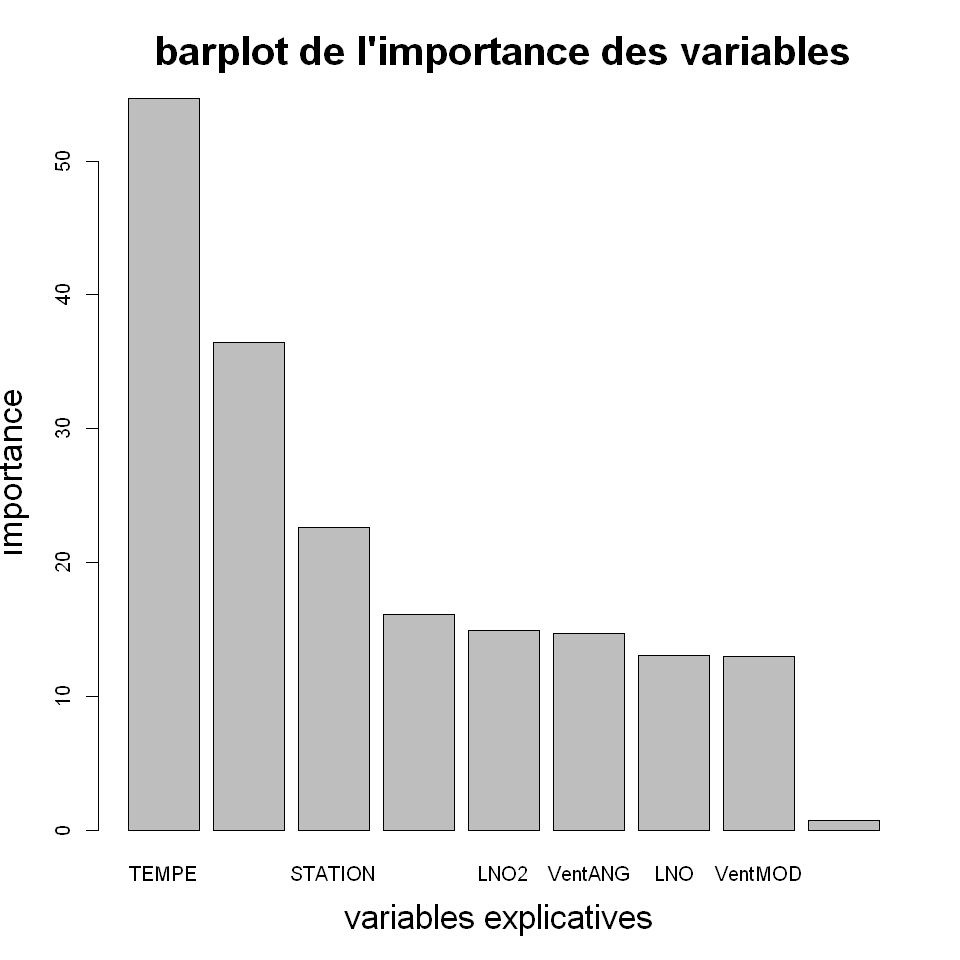

In [108]:
barplot(sort(round(importance(rf.reg), 2)[,1], decreasing=TRUE), main="barplot de l'importance des variables",
        xlab="variables explicatives ",
        ylab="importance ",
        cex.main=2, cex.lab=1.7, cex.sub=1.2)

In [109]:
help(barplot)

### Boosting

Deux librairies proposent des versions relativement  sophistiquées des algorithmes de *boosting* dans R. La librairie *boost* propose 4 approches : *adaboost, bagboost* et deux *logitboost*. Développées pour une problématique particulière : l'analyse des données d'expression génomique, elle n'est peut-être pas complètement adaptée aux données étudiées ; elles se limitent à des prédicteurs quantitatifs et peut fournir des résultats étranges. La librairie *gbm* lui est préférée ; elle offre aussi plusieurs versions dépendant de la fonction coût choisie. Une librairie plus récente `xgboost` intègre des fonctionnalités de parallélisation (pas sous Windows) et fait intervenir plusieurs autres paramètres.

La variable à prévoir doit être codée numériquement (0,1) pour cette implémentation. Le nombre d'itérations, ou nombre d'arbres, est paramétré ainsi qu'un coefficient de rétrécissement (*shrinkage*).

**Q** Comment intervient le *schrinkage* en *boosting*? 

**Q** Pour quel boosting? Ou que signifie `gbm`?

*Attention*, par défaut, ce paramètre a une valeur très faible (0.001) et il faut un nombre important d'itérations (d'arbres) pour atteindre une estimation raisonnable. La qualité est visualisée par un graphe représentant l'évolution de l'erreur d'apprentissage. D'autre part, une procédure de validation croisée est incorporée afin d'optimiser le nombre d'arbres car la version de *boosting* considérée est (légèrement) sujette au sur-apprentissage.

#### Régression

In [110]:
class(ozone$STATION)

[1] "factor"

Warning message:
"le package 'gbm' a été compilé avec la version R 4.1.3"
Loaded gbm 2.1.8



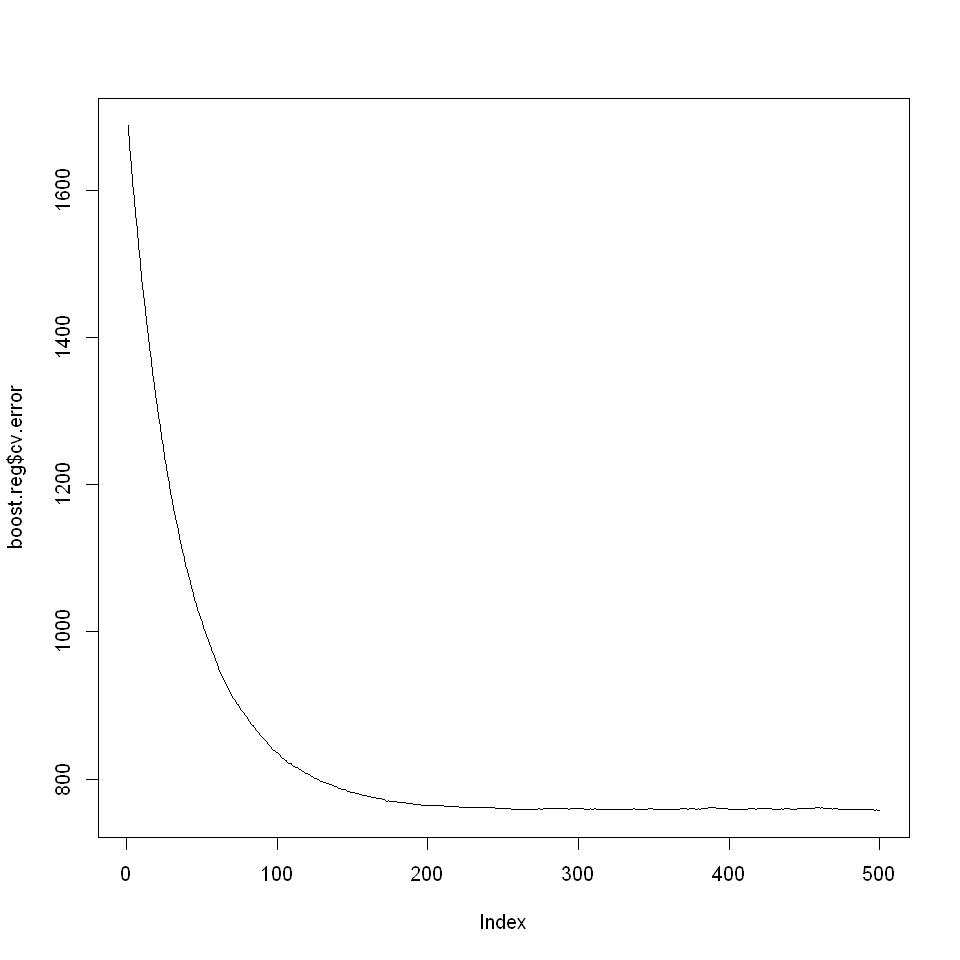

In [111]:
library(gbm)
boost.reg = gbm(O3obs ~ ., data = datappr, distribution = "gaussian", n.trees = 500, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error, type = "l")

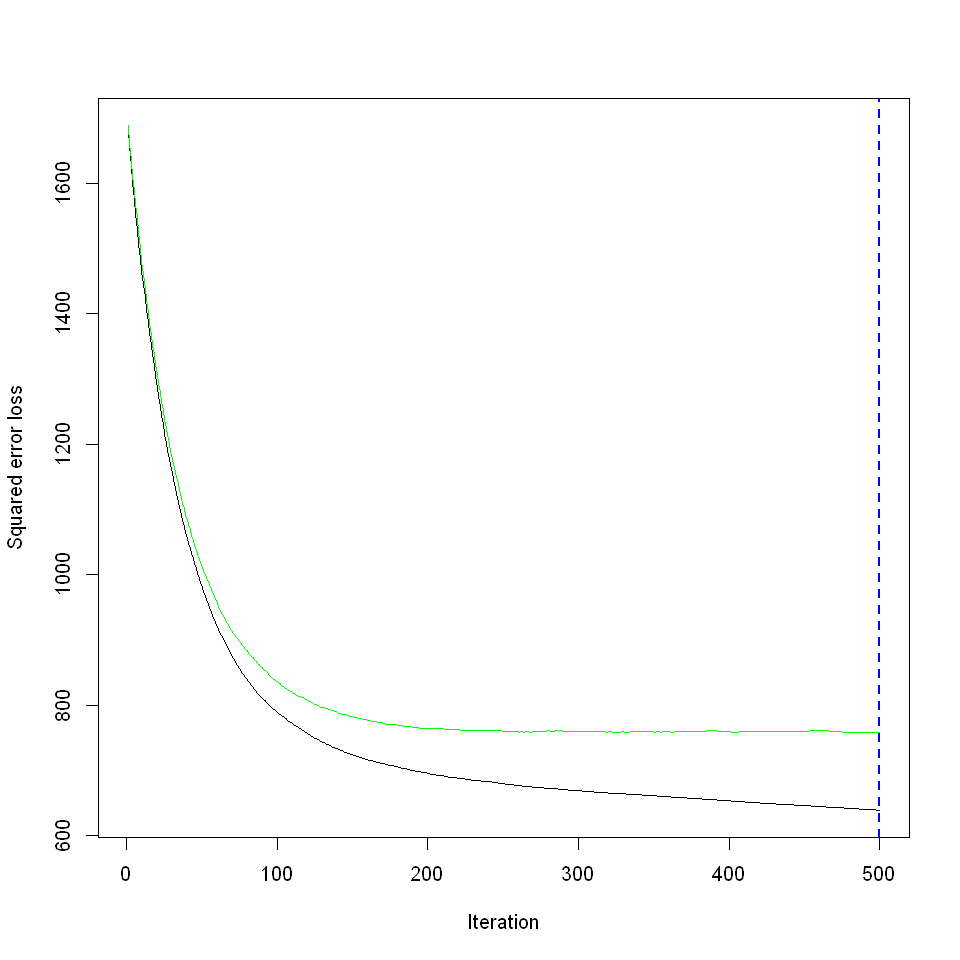

In [112]:
# nombre optimal d'itérations par valiation croisée
best.iter=gbm.perf(boost.reg,method="cv")

On peut s'assurer de l'absence d'un phénomène de sur-apprentissage critique en calculant puis traçant l'évolution de l'erreur sur l'échantillon test en fonction du nombre d'arbre dans le modèle. L'erreur reste stable autour du nombre d'arbres sélectionné et matérialisé par la ligne verticale. 

**Q** Tester ces fonctions en faisant varier le coefficient de rétrécissement.


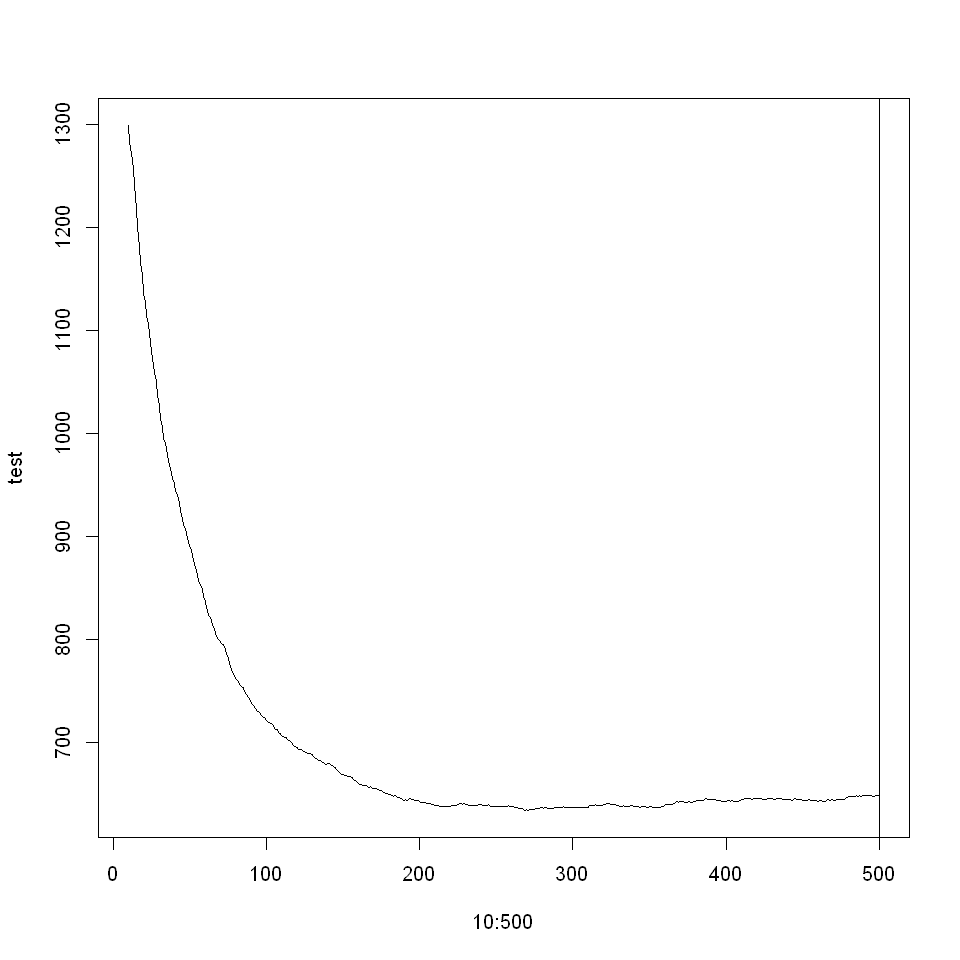

In [113]:
test=numeric()
for (i in 10:500){
pred.test=predict(boost.reg,newdata=datestr,n.trees=i)
err=sum((pred.test-datestr[,"O3obs"])^2)/nrow(datestr)
test=c(test,err)}
plot(10:500,test,type="l")
abline(v=best.iter)

#### Discrimination

Attention, la variable à modéliser doit être codée $(0, 1)$ et il faut préciser un autre paramètre de distribution pour considérer le bon terme d'erreur.

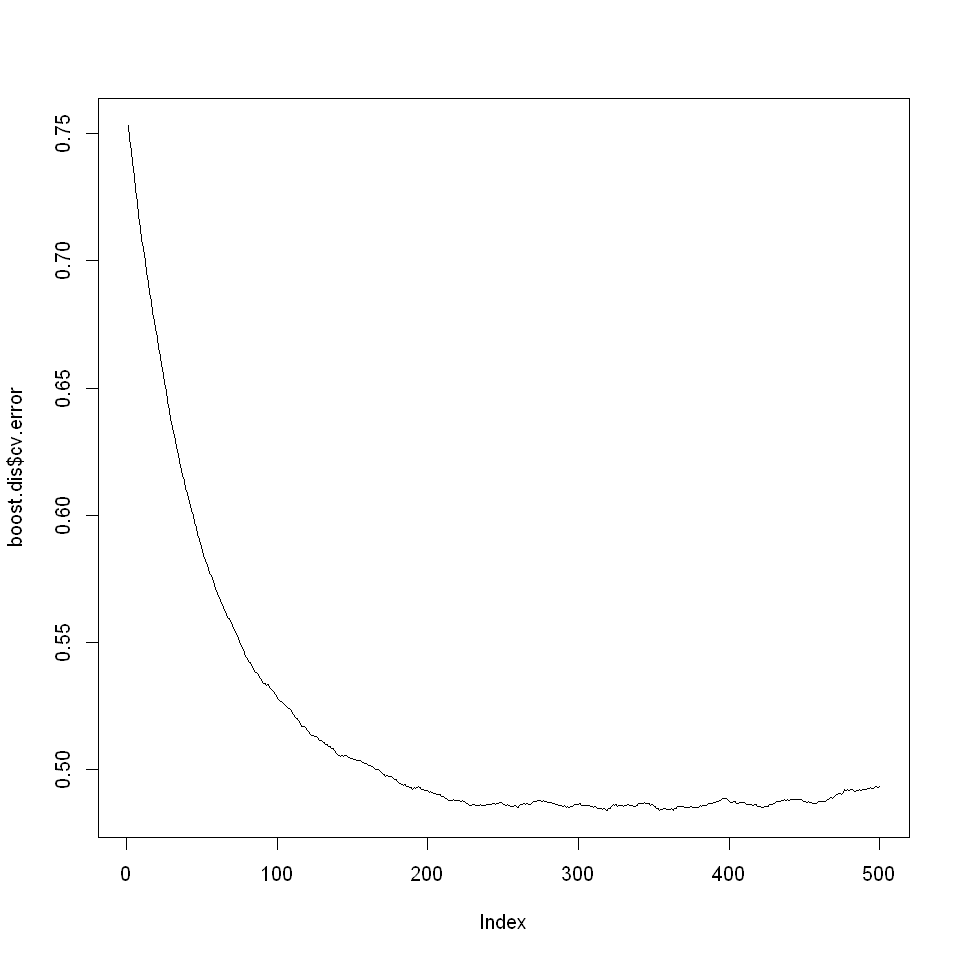

In [114]:
datappq2=datappq
datappq2[,"DepSeuil"]=as.numeric(datappq[,"DepSeuil"])-1
boost.dis=gbm(DepSeuil~.,data=datappq2,distribution="adaboost",n.trees=500, cv.folds=10,
              n.minobsinnode = 5,shrinkage=0.03,verbose=FALSE)
plot(boost.dis$cv.error,type="l")

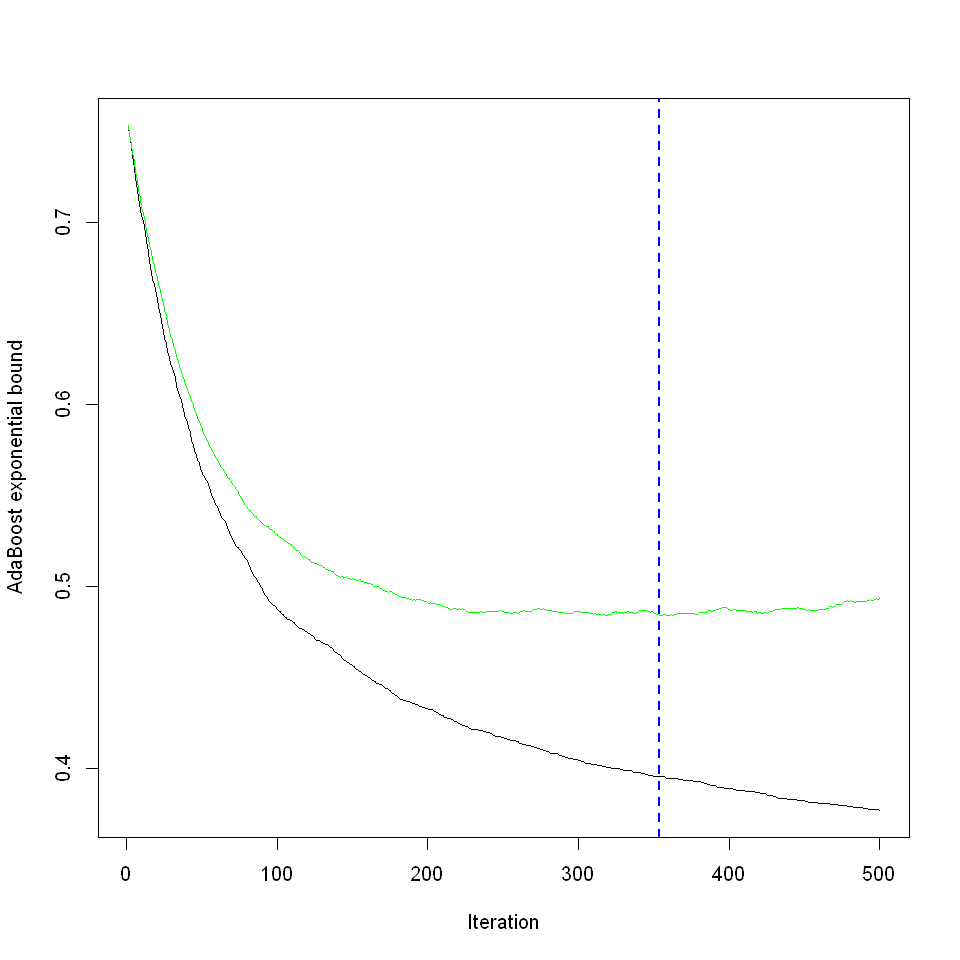

In [115]:
# nombre optimal d'itérations 
best.ited=gbm.perf(boost.dis,method="cv")

Comme pour la régression, il est possible de faire varier le coefficient de rétrécissement en l'associant au nombre d'arbres dans le modèle.

Calcul des résidus et graphe.

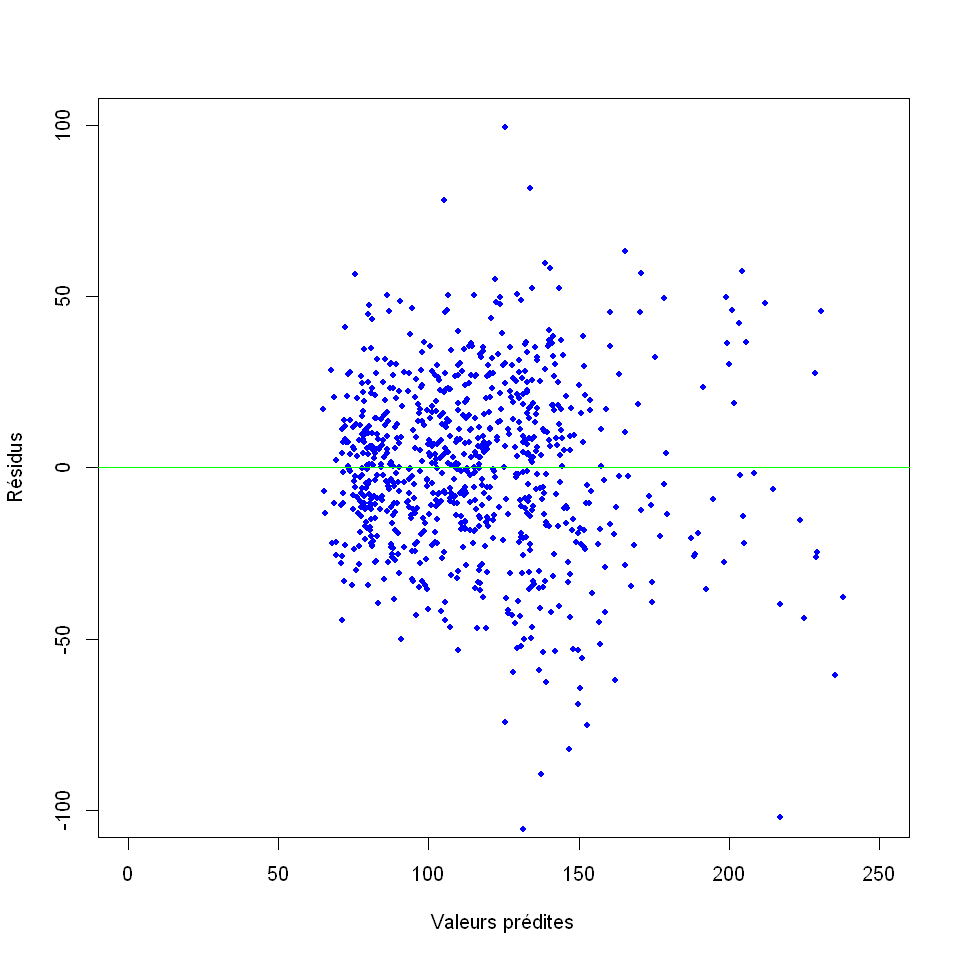

In [116]:
fit.boostr=boost.reg$fit
res.boostr=fit.boostr-datappr[,"O3obs"]
plot.res(fit.boostr,res.boostr,titre="")

### Prévision de l'échantillon test

#### Erreur de régression

In [117]:
# Forêts aléatoires
pred.rfr=rf.reg$test$predicted
pred.rfq=rf.dis$test$predicted
# Erreur quadratique moyenne de prévision
sum((pred.rfr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 573.3102

In [118]:
# Boosting 
pred.boostr=predict(boost.reg,newdata=datestr,n.trees=best.iter)
# Erreur quadratique moyenne de prévision
sum((pred.boostr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 649.0781

#### Erreur de classification (matrices de confusion)

In [119]:
# Forêts aléatoires
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.rfr>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   169   19
  TRUE      6   15

In [120]:
# Forêts aléatoires
# Même chose pour la discrimination
table(pred.rfq,datestq[,"DepSeuil"])

        
pred.rfq FALSE TRUE
   FALSE   172   21
   TRUE      3   13

In [121]:
# Boosting 
# Matrice de confusion pour la prévision 
# du dépassement de seuil (régression)
table(pred.boostr>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   169   23
  TRUE      6   11

In [122]:
# Boosting 
# Même chose pour la discrimination
pred.boostd=predict(boost.dis,newdata=datestq,n.trees=best.ited)
table(as.factor(sign(pred.boostd)),datestq[,"DepSeuil"])

    
     FALSE TRUE
  -1   167   19
  1      8   15

**Q** Quelle  stratégie d'agrégation de modèles vous semble fournir le meilleur résultat de prévision? 

**Q** Est-elle, sur ce jeu de données, plus efficace que les modèles classiques expérimentés auparavant ?

#### Courbes ROC

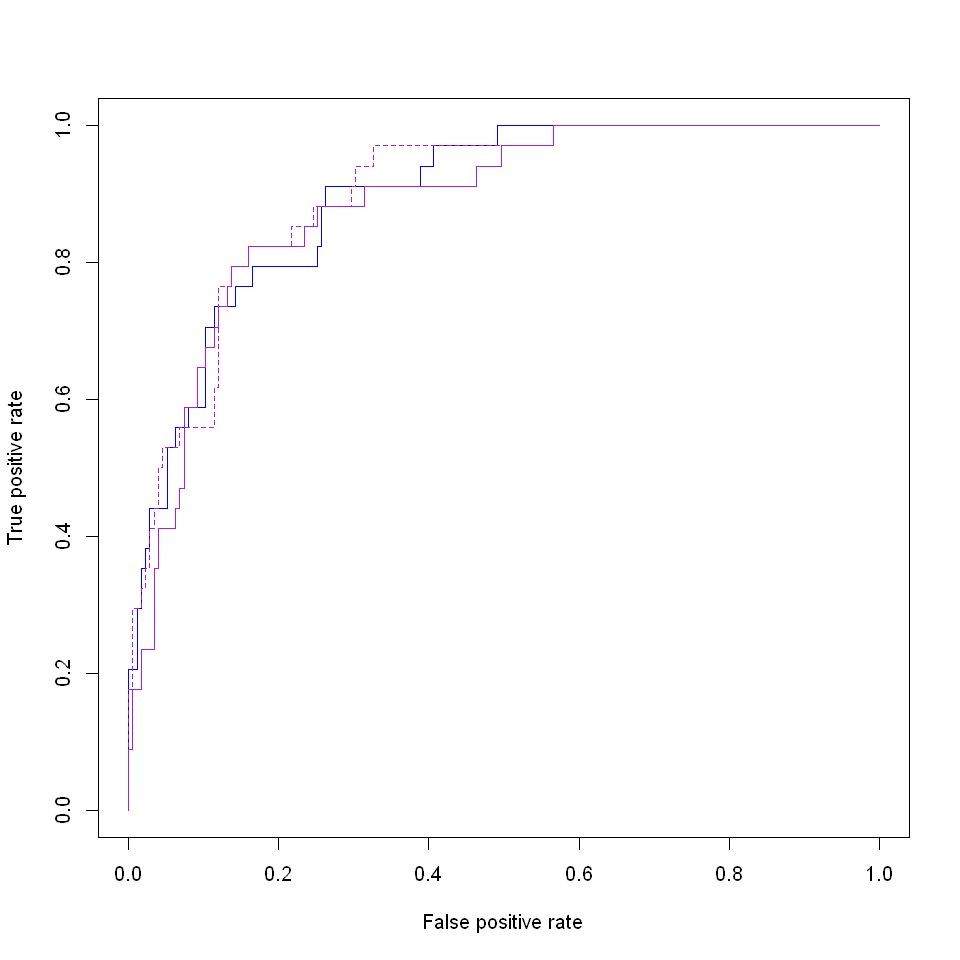

In [123]:
# Forêts aléatoires
rocrfr=pred.rfr/300
predrfr=prediction(rocrfr,datestq$DepSeuil)
perfrfr=performance(predrfr,"tpr","fpr")

# Boosting
rocbstr=pred.boostr/300
predbstr=prediction(rocbstr,datestq$DepSeuil)
perfbstr=performance(predbstr,"tpr","fpr")

# tracer les courbes ROC en les superposant 
# pour mieux comparer
plot(perflogit,col="blue")
plot(perfrfr,col="purple",lty=2,add=TRUE)  
plot(perfbstr,col="purple",add=TRUE)  

**Q** Qu'indique la comparaison des coubes ROC?

# <FONT COLOR="Red">Épisode 4</font>

## [Séparateur à Vaste Marge (SVM)](http://wikistat.fr/pdf/st-m-app-svm.pdf)

### Introduction

Malgré les assurances théoriques concernant ce type d'algorithme, les résultats dépendant fortement du choix des paramètres. Nous nous limiterons d'abord au noyau gaussien (choix par défaut) ; la fonction `tune.svm` permet de tester facilement plusieurs situations en estimant la qualité de prévision par validation croisée sur une grille. Le temps d'exécution en R est un peu long... 

**Q** Le temps d'exécution pour les SVM est-il plus sensible au nombre d'observations ou au nombre de varaibles ? Pourquoi ?

(à vérifier) : plus sensible au nombre de observations (joue sur les vecteurs support) que par les variable

### Régression

Bien qu'initialement développés dans le cas d'une variable binaire, les SVM ont été étendus aux problèmes de régression. L'estimation et l'optimisation du coefficient de pénalisation sont obtenues par les commandes suivantes.  


In [124]:
library(e1071)
svm.reg0 = svm(O3obs ~ ., data = datappr)
summary(svm.reg0)


Call:
svm(formula = O3obs ~ ., data = datappr)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.07692308 
    epsilon:  0.1 


Number of Support Vectors:  702






In [125]:
library(e1071)
help(svm)

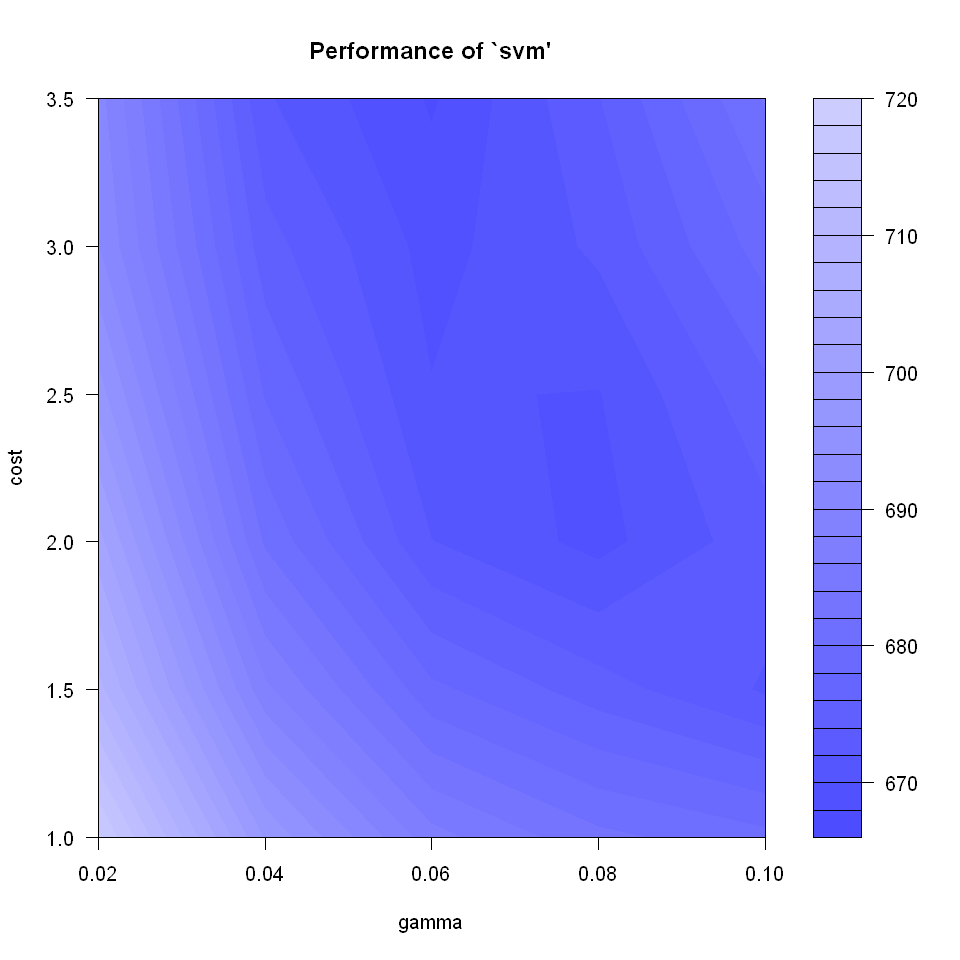

In [126]:
#set.seed(2021)
svm.reg.tune = tune.svm(O3obs ~ ., data = datappr, cost = c(1, 1.5, 2, 2.5, 3, 3.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

#le epsilon donne la taille du tube, par défaut vaut 0.1.
#le cost donne si les points sont sur la bordure 
#gamma est un paramètre propre au noyau radial

In [127]:
MAPE=$\frac{100}{n}  \sum_{i=1}^{n} \frac{Y_i-\hat{Y}_i}{Y_i+1}
On utilise la norme utilisée par météo france, et plus la norme $L^2$.
Il faudrait chercher à optimiser nos modèles avec cette fonction perte 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: '$' inattendu(e)
1: MAPE=$
         ^


On représente ici les courbes de niveau avec la performance. On cherche le paramètre cost et gamma qui maximise la performance. Graphiquement, on a bien que les best parameters sont gamma=0,04 et cost=3,5. Plus le cost augmente, plus on autorise des points à être en dehors du tube. Plus il risque d'y avoir de l'overfitting. 

In [ ]:
summary(svm.reg.tune)

Par défaut la pénalisation (cost) vaut 1. Noter la pénalisation optimale pour le noyau considéré (gaussien). Ré-estimer le modèle supposé optimal avant de tracer le graphe des résidus. Comme précédemment, observer que plusieurs exécutions conduisent à des résultats différents et donc que l'optimisaiton de ce paramètre est pour le moins délicate.

**Q** Quels autres noyaux sont dispnibles dans cette implémentation des SVM?

Il existe aussi poly, rbf, linear...

In [ ]:
svm.reg = svm(O3obs ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)

In [ ]:
summary(svm.reg)
help(svm)

In [ ]:
svm.reg = svm(O3obs ~ ., data = datappr, cost = 10000, epsilon=1,
    gamma = svm.reg.tune$best.parameters$gamma)

In [ ]:
# calcul et graphe des résidus
fit.svmr=fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"O3obs"]
plot.res(fit.svmr,res.svmr,titre="")


Observer l'effet ''couloir'' sur les résidus. 

**Q** Qu'est-ce qui cause le rapprochement des résidus dans un "couloir"? Qu'observez-vous lorsque vous faîtes varier les paramètres cost et epsilon?

Plus le cost augmente, plus on a que les résidus sont dans un tube ( plus il y a un risque d'overfitting)


### Discrimination

In [ ]:
# optimisation
svm.dis.tune = tune.svm(DepSeuil ~ ., data = datappq, cost = c(1,1.25,1.5,1.75,2), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.dis.tune)

In [ ]:
# apprentissage
svm.dis.tune$best.parameters
svm.dis=svm(DepSeuil~.,data=datappq,cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)

### Prévision de l'échantillon test

#### Erreur de régression

In [ ]:
pred.svmr=predict(svm.reg,newdata=datestr)
# Erreur quadratique moyenne de prévision
sum((pred.svmr-datestr[,"O3obs"])^2)/nrow(datestr)

#### Erreur de classification (matrices de confusion)

In [ ]:
# Matrice de confusion pour la prévision du dépassement de seuil (régression)
table(pred.svmr>150,datestr[,"O3obs"]>150)

In [ ]:
# Même chose pour la discrimination
pred.svmq=predict(svm.dis,newdata=datestq)
table(pred.svmq,datestq[,"DepSeuil"])

#### Courbes ROC

In [ ]:
rocsvmr = pred.svmr/300
predsvmr = prediction(rocsvmr, datestq$DepSeuil)
perfsvmr = performance(predsvmr, "tpr", "fpr")
# re-estimer le modèle pour obtenir des probabilités de classe plutôt que des
# classes
svm.dis = svm(DepSeuil ~ ., data = datappq, cost = 1.25, probability = TRUE)
pred.svmq = predict(svm.dis, newdata = datestq, probability = TRUE)
rocsvmq = attributes(pred.svmq)$probabilities[, 2]
predsvmq = prediction(rocsvmq, datestq$DepSeuil)
perfsvmq = performance(predsvmq, "tpr", "fpr")
# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit, col = "blue")
plot(perfsvmr, col = "red", lty = 2, add = TRUE)
plot(perfsvmq, col = "red", add = TRUE)

**Q** Les SVM apportent-ils une amélioration?

## Industrialisation de l'apprentissage
Un avantage de R est le nombre considérables d'utilisateurs qui participent au développement des librairies. cet avantage a un revers: le manque d'homogénéité de celles-ci. Pour y remédier dans les applications d'apprentissage machine, la (méta)librairie [`caret`](https://topepo.github.io/caret/) de [Max Kuhn (2008)](https://www.jstatsoft.org/article/view/v028i05) intègre dans un même usage, une même syntaxe, l'ensemble des fonctionnalités d'apprentissage et propose une approche unifiée des procédures d'optimisation des paramètres.

Les instructions suivantes reprennent rapidement les étapes précédentes afin d'introduire l'usage de `caret`. Elles se limitent à l'objectif de prévision de dépassement du seuil (classification). Le code pour modéliser la concentration par régression s'en déduit facilement.

### Calcul parallèle
Par ailleurs, même sous windows, `caret` offre simplement des possibilités de parallèlisation en utilisant la package `doParallel`. Même si les algorithmes des différentes méthodes d'apprentissage ne sont pas parallélisés, les itérations des calculs de validations croiser pour l'optimisation des paramètres sont effectivement parallélisés avec un gain de temps très appréciable fonciton du nombre de processeurs. Ceci est obtenu en exécutant les commandes suivantes en supposant que 4 processeurs sont disponibles.

In [130]:
library(doParallel)

In [131]:
cl <- makeCluster(4)
registerDoParallel(cl) 

### Préparation des données
Les données sont celles initiales et la stratégie adoptée pour optimiser les modèles est la validation croisée. D’autres choix sont possibles (bootstrap). La librairie `caret` intègre des fonctions d’échantillonnage et de normalisation des données.

In [132]:
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

In [136]:
library(caret)
library(FactoMineR)

In [137]:
# extraction des données
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
# Transformation des facteurs en indicatrices pour utiliser certains algorithmes
# notamment xgboost
X=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
summary(Y);summary(X)

FALSE  TRUE 
  863   178

       X0               X1              Aix              Als        
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :1.0000   Median :0.0000   Median :0.0000   Median :0.0000  
 Mean   :0.6955   Mean   :0.3045   Mean   :0.1912   Mean   :0.2133  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      Cad             Pla              Ram             MOCAGE     
 Min.   :0.000   Min.   :0.0000   Min.   :0.0000   Min.   : 46.4  
 1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 97.5  
 Median :0.000   Median :0.0000   Median :0.0000   Median :125.6  
 Mean   :0.194   Mean   :0.1998   Mean   :0.2017   Mean   :127.2  
 3rd Qu.:0.000   3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.:153.6  
 Max.   :1.000   Max.   :1.0000   Max.   :1.0000   Max.   :284.7  
     TEMPE          VentMOD           VentANG   

In [144]:
head(ozone)
head(X)

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,91,93.2,21.5,Aix,9.5000,-0.64350,0.09203260,0.4712528,-0.8580218,FALSE
2,1,100,104.6,20.2,Aix,8.0100,-0.04996,0.09386160,0.7518877,-0.6329933,FALSE
3,0,82,103.6,17.4,Aix,9.3771,-0.12832,0.09751923,0.5050087,-0.7614260,FALSE
4,0,94,94.8,18.8,Aix,9.4578,-0.34516,0.09246621,0.8544153,-0.3552474,FALSE
5,0,107,99.0,23.7,Aix,7.8791,-0.41822,0.08549854,0.5025918,-0.7940731,FALSE
6,0,150,114.3,23.6,Aix,6.3127,0.06341,0.10871982,1.6707211,0.2949059,FALSE


,X0,X1,Aix,Als,Cad,Pla,Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.09203260,0.4712528,-0.8580218
2,0,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.09386160,0.7518877,-0.6329933
3,1,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.09751923,0.5050087,-0.7614260
4,1,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.09246621,0.8544153,-0.3552474
5,1,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.08549854,0.5025918,-0.7940731
6,1,0,1,0,0,0,0,114.3,23.6,6.3127,0.06341,0.10871982,1.6707211,0.2949059


In [140]:
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]

Certaines méthodes sont sensibles à des effets de variance ou d'unité des variables. Il est préférable d'introduire une normalisation.

In [145]:
# Normalisation calculée sur les paramètres de l'échantillon d'apprentissage
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
# Puis appliquée également à l'échantillon test
testDescr=predict(xTrans,testDescr)
# Choix de la validation croisée
cvControl=trainControl(method="cv",number=10)

### Estimation des modèles
La librairie intègre beaucoup de modèles ou méthodes (233!) et celles sélectionnées ci-dessous font partie des plus utilisées. Consulter   la   [liste   des   méthodes](http://topepo.github.io/caret/available-models.html)   disponibles   en option   de   la   fonction: `train`.  Le choix est en principe limité également aux méthodes acceptant des variables quantitatives et qualitatives mais, en transformant préalablement les variables qualitatives en paquets d'indicatrices (*dummies*) les autres méthodes sont accessibles. Exécuter chaque blocs de commandes pour tracer séparamment chacun des graphes afin de contrôler le bon comportement
de l’optimisation du paramètre de complexité de chaque modèle.

L'automatisation  de l'optimisation  de  certaines méthodes comme  la régression logistique est moins flexible qu’en utilisation  "manuelle"; en particulier pour le choix de l’algorithme de sélection de variables. Il faut se montrer (très) patient pour certaines optimisations alors que d'autres sont immédiates, voire inutiles. 

Le paramètre `tuneLength` caractérise  un "effort" d'optimisation, c'est en gros le nombre de valeurs de paramètres testées sur une grille fixée automatiquement. En prenant plus de soin et aussi plus de temps, il est possible de fixer précisément des grilles pour les valeurs du ou des paramètres optimisés pour chaque méthode. Néanmoins, comme expérimenté précédemment, il n'est pas toujours utile de passer beaucoup de temps à optimiser un paramètre. L'approche sommaire de `caret` s'avère souvent suffisante et l'optimisation d'un modèle, de sa complexité, peut être affinée après sélection de la méthode.

**Q** Dans chaque cas, identifier la méthode, préciser les paramètres associés et noter celui ou ceux optimisés par défaut par `caret`.

In [ ]:
#1 Régression logistique
# Attention, la régression logistique sans interaction (linéaire) est estimée ci-dessous
set.seed(2)
rlogFit = train(trainDescr, trainY,method = "glmStepAIC", tuneLength = 10,
                trControl = cvControl, trace=FALSE)
rlogFit

In [ ]:
#2 Arbre de décision
set.seed(2)
rpartFit = train(trainDescr, trainY, method = "rpart", tuneLength = 10,
    trControl = cvControl)
rpartFit
plot(rpartFit)

In [ ]:
#3 Réseau de neurones
set.seed(2)
nnetFit = train(trainDescr, trainY, method = "nnet", tuneLength = 6,
                trControl = cvControl, trace=FALSE)
nnetFit
plot(nnetFit)

In [ ]:
#4 Random forest
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)
rfFit
plot(rfFit)

In [ ]:
#5 Boosting 
set.seed(2)
gbmFit = train(trainDescr, trainY,method = "gbm", tuneLength = 8,
               trControl = cvControl)
gbmFit
plot(gbmFit)

Comme l'algoritme *extreme gradient boosting* (approximation du gradient par décoposition de taylor et parallélisation des codes) est très présent dans les solutions des concours *Kaggle* celui-ci est testé. *Attention*, les bons résultats des concours sont obtenus au prix d'une lourde et complexe procédure d'optimisation des nombreux paramètres de cette approche; procédure rendue possible par la parallélisation avancée de la librairie [`xgboost`](https://xgboost.readthedocs.io/en/latest/) et l'utilisation de cartes graphiques (GPU). Si cet environnement n'est pas disponible l'optimisation est assez longue, même avec la parallélisation sur 4 processeurs...

In [ ]:
#6 Extrême boosting
library(xgboost)
set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)
xgbFit
plot(xgbFit)

### Prévision et erreur de test
Les méthodes sélectionnées et optimisées sont ensuite appliquées à la prévision de l’échantillon test. Estimation du taux de bien classés:

In [ ]:
models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

Tracer  les  courbes  ROC  pour  analyser  spécificité  et  sensibilité  des  différentes  méthodes.  

In [ ]:
library(ROCR)
models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testProb=predict(models, newdata = testDescr,type="prob")
predroc=lapply(testProb,function(x)prediction(x[,1],testY==FALSE))
perfroc=lapply(predroc,
function(x)performance(x, "tpr", "fpr"))
plot(perfroc$logit,col=1)
plot(perfroc$cart,col=2,add=TRUE)
plot(perfroc$nnet,col=3,add=TRUE)
plot(perfroc$rf,col=4,add=TRUE)
plot(perfroc$gbm,col=5,add=TRUE)
plot(perfroc$xgb,col=6,add=TRUE)
legend("bottomright",legend=c("logit","CART","nnet","RF","boost","xgBoost"),col=c(1:6),pch="_")

### [Validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)
L'échantillon est de faible taille (#200), et les estimations des taux de bien classés comme le tracé des courbes ROC sont très dépendants de l’échantillon test; on peut s’interroger sur l’identité du modèle le plus performant ainsi que sur la significativité des différences observées entre les méthodes. Il est donc important d’itérer le processus (validation croisée *Monte Carlo*) sur plusieurs échantillons tests. Exécuter la fonction en annexe en choisissant les méthodes semblant les plus performantes. Attention au temps de calcul ! CART peut performant est supprimé.

In [ ]:
# Choisir la liste des méthodes et l’effort d’optimisation
models=c("gbm","rf","nnet","glmStepAIC","xgbTree")
noptim=c(6,6,6,6,6)
# Initialiser le générateur et fixer le nombre d’itérations
# Changer ces valeurs. Attention au temps de calcul! Être patient!
Niter=10 ; Init=11  
# Appel de la fonction définie en annexe
pred.ozone=pred.autom(X,Y,methodes=models,N=Niter,xinit=Init,size=noptim,type="prob")

In [ ]:
# Calcul des taux de bien classés
obs=pred.ozone$obs
prev.ozone=pred.ozone$pred
res.ozone=lapply(prev.ozone,function(x)apply((x>0.5)==(obs==1),2,mean))
# Moyennes des taux de bien classés par méthode
lapply(res.ozone,mean)
# distributions des taux de bien classés
boxplot(data.frame(res.ozone))

Les commandes suivandes tracent les courbes ROC moyennes.

In [ ]:
## Comparaison des méthodes par le
# tracer des courbes ROC moyennes
# Problème pas identifié avec rlogit!
predroc.ozone=lapply(prev.ozone,function(x)prediction(x,obs==1))
perfroc.ozone=lapply(predroc.ozone,function(x)performance(x,"tpr","fpr"))
plot(perfroc.ozone$gbm,col=1,lwd=2,avg="vertical")
plot(perfroc.ozone$rf,col=2,add=TRUE,lwd=2,avg="vertical")
plot(perfroc.ozone$nnet,add=TRUE,col=3,lwd=1.5,avg="vertical")
plot(perfroc.ozone$xgbTree,add=TRUE,col=4,lwd=1.5,avg="vertical")
plot(perfroc.ozone$glmStepAIC,add=TRUE,col=5,lwd=1.5,avg="vertical")
legend("bottomright",legend=c("boost","RF", "nnet","xgBoost","logit"),col=c(1:5),pch="_")

**Q** Quelle méthode retenir, en fonction du taux de faux positif acceptable, pour prévoir le dépassement du seuil? Et si le comanditaire veut une solution explicable?

La même démarche réalisée sur la prévision de concentration avant de prédire le dépassement du seuil conduit à des résutlats similaire. 

*N.B.* 
* Ce n'est pas la régression logistique avec interactions (quadratique) qui a été testée dans cette dernière comparaison
* L'algorithme xgboost nécessiterait des efforts plus important d'optimisation des paramètres mais le coût de calcul s'en ressent. A tester en Python avec un accès à une carte GPU.

# <FONT COLOR="Red">Épisode 5</font>
**Remarque** Il est possible d'exécuter directement l'*épisode 5* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter les *sections 2 et 3* de l'*épisode 1*, phase exploratoire, afin de construire les données utilisées dans les sections 13 et 14 d'imputation des données manquantes et de détection d'atypiques.

## [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)

Les vraies données sont le plus souvent mitées par l'absence de données, conséquences d'erreurs de saisie, de pannes de capteurs... Les librairies de R offrent de très nombreux choix pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire. 

Plusieurs stratégies sont exécutées et comparées après avoir généré aléatoirement un pourcentage de défaillances (trous) dans les valeurs des variables explicatives.

**Q.** Pourquoi la structure des variables explicatives incite-t-elle à exécuter l'algorithme missForest de la librairie éponyme? 

<font color = "blue" >'missForest' is used to impute missing values particularly in the case of mixed-type data. Or ici, nous avons des variables à la fois quantitatuves et qualitatives donc missForest est bien adapté. En effet, missForest est basé sur des arbres qui s'appliquent à la fois en regression et en classification

**Dans un premier temps**, nous allons comparer quelques méthodes d'imputation sur les données explicatives quantitatives : LOCF, imputation par la moyenne ou la médiane, kNN, MissForest et Amelia II.


**Dans un deuxième temps**, nous nous concentrerons sur la méthode Missforest et l'objectif sera d'étudier l'impact de l'imputation des données sur les performances de classification pour prédire la variable "depassement de seuil" en comparant deux stratégies :


La **première stratégie** commence par imputer les données manquantes en les prévoyant par l'algorithme MissForest. 

Une fois les données manquantes imputées, différentes méthodes de prévision sont utilisables comme précédemment. Deux sont exécutées: forêts aléatoires et *extrem gradient boosting*.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu le fond, c'est le cas de `XGBoost`.

Attention, les commandes ci-dessous font appel à de nombreux fichiers qu'il est facile de mélanger.
- `X` données complètes initiales et `Xd` la version où les variables qualitatives sont remplacées par des indicatrices, 
- `Xna` les données avec des trous, `Xdna` la version avec indicatrices,

- `XnaImp` les données avec imputations et `XdnaImp` la version avec indicatrices.

Le remplacement des variables qualitatives par des variables indicatrices est imposé par l'utilisation de la librairie `XGBoost` et cela ne change en rien les résultats des forêts aléatoires.

### Préparation des trous dans `ozone`
Les données initiales de la base `ozone` sont reprises. Seule la variable à expliquer de dépassement de seuil est conservée. La librairie `missForest`propose une fonction pour générer un pourcentage fixé a priori de données manquantes dans une base.

In [146]:
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
n=nrow(X); p=ncol(X)
summary(Y); summary(X)

FALSE  TRUE 
  863   178

 JOUR        MOCAGE          TEMPE       STATION      VentMOD       
 0:724   Min.   : 46.4   Min.   :10.40   Aix:199   Min.   : 0.1414  
 1:317   1st Qu.: 97.5   1st Qu.:20.20   Als:222   1st Qu.: 3.9623  
         Median :125.6   Median :23.80   Cad:202   Median : 5.5973  
         Mean   :127.2   Mean   :23.88   Pla:208   Mean   : 5.9072  
         3rd Qu.:153.6   3rd Qu.:27.60   Ram:210   3rd Qu.: 7.1063  
         Max.   :284.7   Max.   :38.00             Max.   :19.8910  
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215   1st Qu.:-1.4439  
 Median : 0.2783   Median :0.09925   Median : 0.7462   Median :-0.9467  
 Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440   Mean   :-0.8399  
 3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017   3rd Qu.:-0.2957  
 Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931   Max.   : 2.2438  

In [149]:
library(missForest)

In [158]:
# faire une proportion tauxNA de trous aléatoires dans X
# Données missing at random
tauxNa=0.2
set.seed(11)
Xna=prodNA(X,tauxNa)
summary(Xna)

   JOUR         MOCAGE          TEMPE       STATION       VentMOD       
 0   :571   Min.   : 46.4   Min.   :10.40   Aix :160   Min.   : 0.1414  
 1   :262   1st Qu.: 97.7   1st Qu.:20.10   Als :183   1st Qu.: 4.0311  
 NA's:208   Median :125.5   Median :23.75   Cad :163   Median : 5.6727  
            Mean   :127.2   Mean   :23.93   Pla :162   Mean   : 5.9702  
            3rd Qu.:153.5   3rd Qu.:27.62   Ram :173   3rd Qu.: 7.1028  
            Max.   :284.7   Max.   :38.00   NA's:200   Max.   :19.8910  
            NA's   :233     NA's   :209                NA's   :204      
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.4068   1st Qu.:0.08798   1st Qu.: 0.2343   1st Qu.:-1.4643  
 Median : 0.2736   Median :0.09982   Median : 0.7701   Median :-0.9519  
 Mean   : 0.1502   Mean   :0.10015   Mean   : 0.8458   Mean   :-0.8488  
 3rd Qu.: 0.6812   3rd Qu.:0.11221   3rd Qu.: 1.383

**Q** Quel est en moyenne le nombre de données manquantes par colonne?

<font color = "blue"> En moyenne, on a 200 données maquantes par colonne.


### Comparaison de méthodes d'imputation sur données quantitatives ###

On conserve seulement les variables quantitatives pour comparer diverses méthodes d'imputation.

In [160]:
#Tableau des données quantitatives
#On compare les différentes méthodes de complétion sur la variable Temperature
Xnaquanti=Xna[,-c(1,4)]
Xquanti=X[,-c(1,4)]
ind.na=which(is.na(Xnaquanti),arr.ind=TRUE)
ind.na.Temp=which(is.na(Xnaquanti[,2]),arr.ind=TRUE)

#### Complétion par la dernière valeur connue (LOCF) ####

In [165]:
library(zoo) # chargement de la bibliothèque

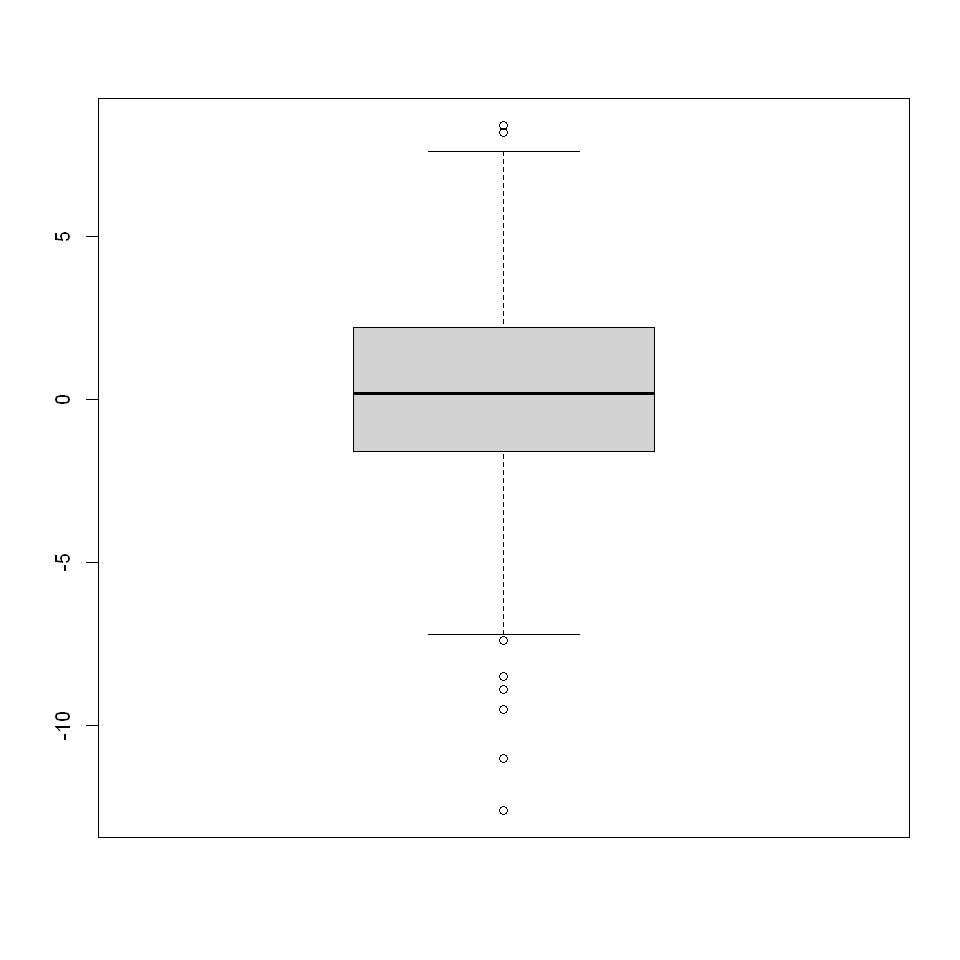

In [173]:
# parcourt le tableau et pour chaque valeur manquante remplit par la valeur précédente
# cependant, si la première valeur est manquante, il n'y a pas de valeur précédente c'est pour 
# cela que l'on complète dans un sens puis dans l'autre.
X.locf=na.locf(Xnaquanti,na.rm=FALSE)
X.locf=na.locf(X.locf,na.rm=FALSE,fromLast=TRUE) # dans l'autre sens
err.locf=(Xquanti-X.locf)[ind.na.Temp,2]
boxplot(err.locf) #erreur générée par la complétion
# si on veut compléter les données mais que l'erreur que génère la complétion est plus importante 
# que l'erreur sans complétion, il vaut mieux supprimer la donnée.

#### Complétion par la moyenne ####

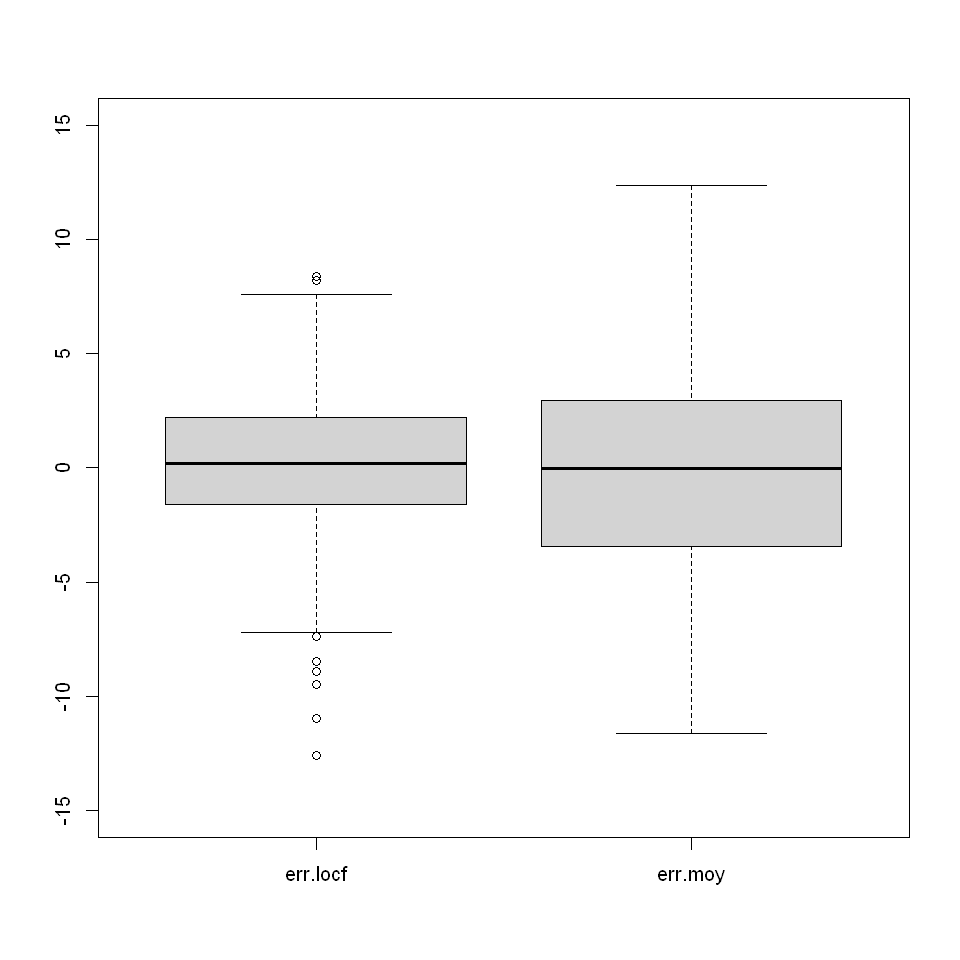

In [164]:
moy=apply(Xnaquanti,2,mean,na.rm=TRUE) #calcule la moyenne de toutes les colonnes
X.moy=Xnaquanti
ind.na=which(is.na(X.moy),arr.ind=TRUE) #repère les coordonnées des données manquantes
X.moy[ind.na]=moy[ind.na[,2]] #remplace les données manquantes par leur moyenne 
err.moy=(Xquanti-X.moy)[ind.na.Temp,2] #calcule l'erreur sur les données manquantes
boxplot(data.frame(err.locf,err.moy),ylim=c(-15,15))

#### Complétion par la mediane ####

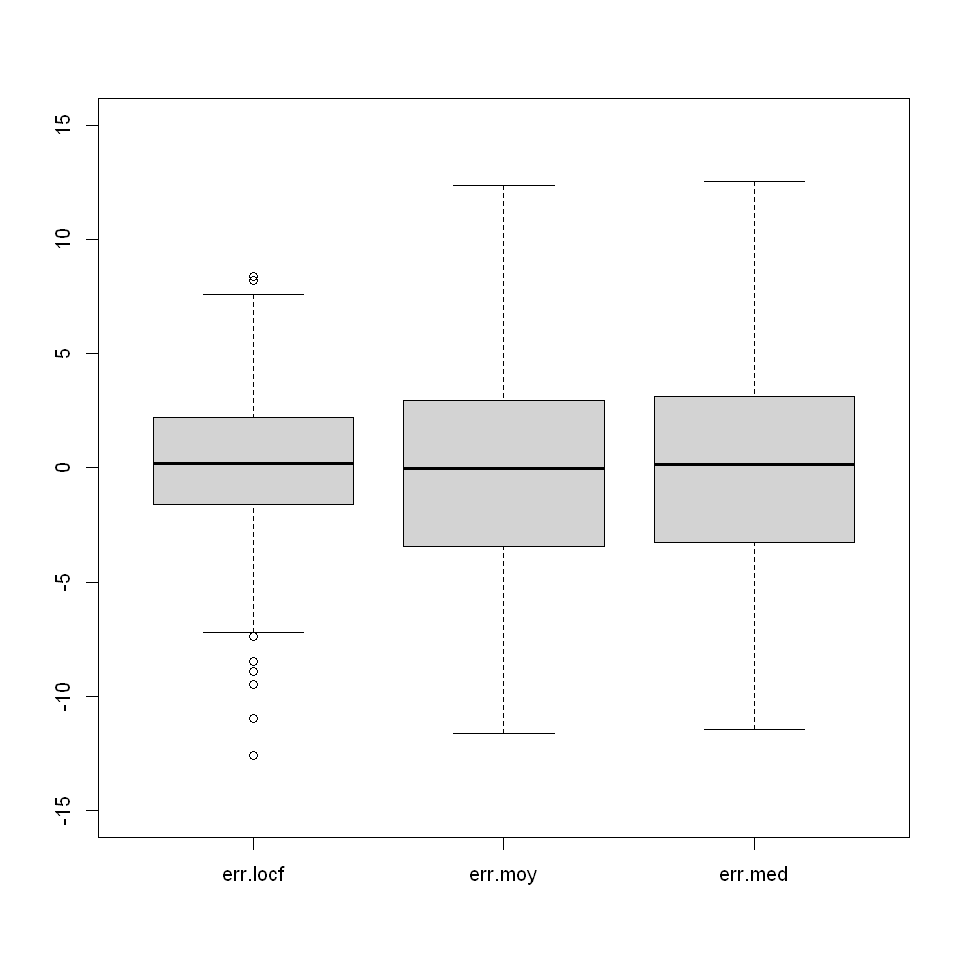

In [174]:

med=apply(Xnaquanti,2,median,na.rm=TRUE)
X.med=Xnaquanti
ind.na=which(is.na(X.med),arr.ind=TRUE)
X.med[ind.na]=med[ind.na[,2]]
err.med=(Xquanti-X.med)[ind.na.Temp,2]

boxplot(data.frame(err.locf,err.moy,err.med),ylim=c(-15,15))


#### Complétion par k plus proches voisins (kNN) ####

In [171]:
library(VIM) # chargement de la bibliothèque

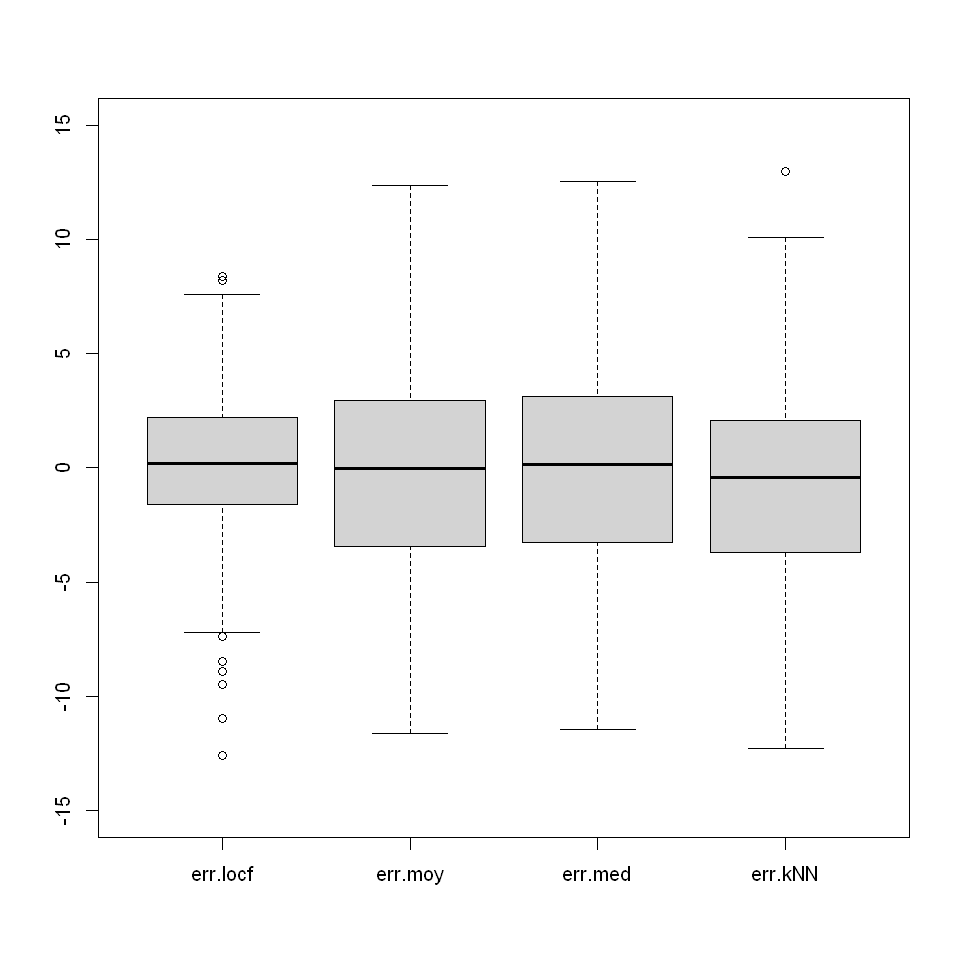

In [175]:
X.kNN=kNN(Xnaquanti, k=5, imp_var=FALSE)
err.kNN=(Xquanti-X.kNN)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN),ylim=c(-15,15))

#### Complétion avec Missforest ####

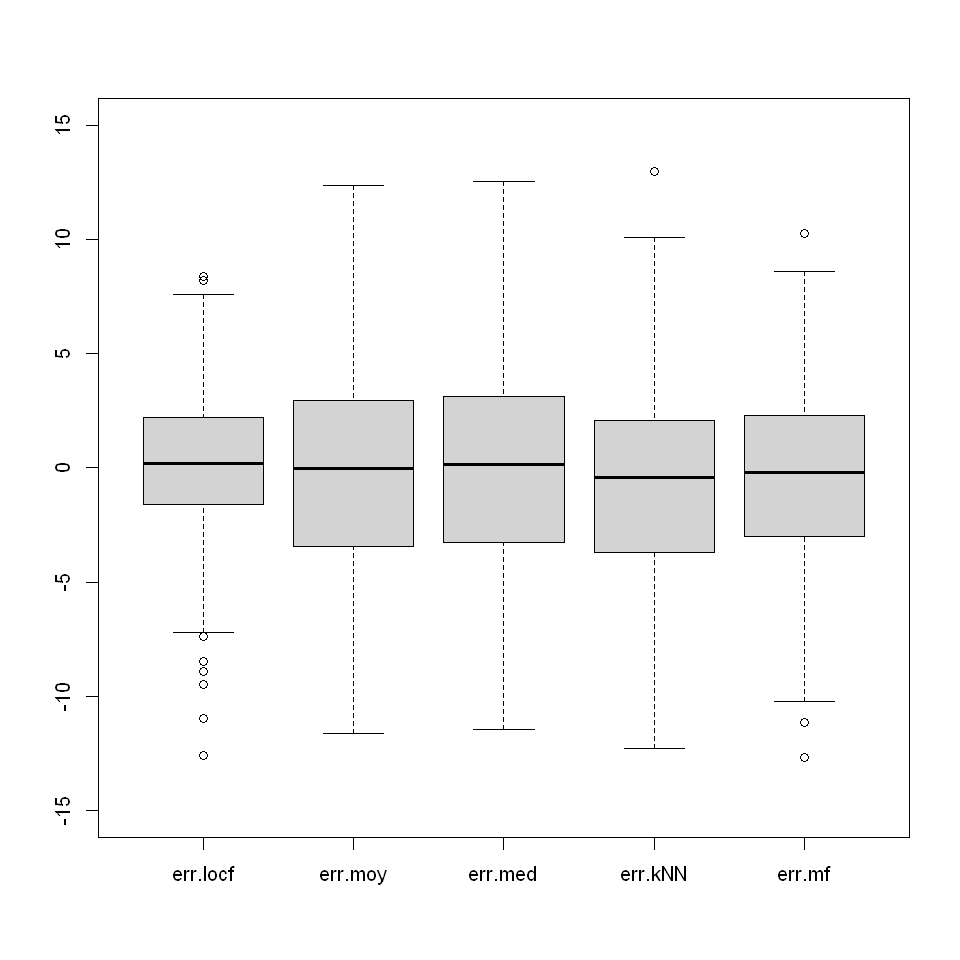

In [176]:

X.mf=missForest(Xnaquanti,xtrue=Xquanti)
err.mf=(Xquanti-X.mf$ximp)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf),ylim=c(-15,15))


#### Completion avec Amelia II ####

In [179]:
library(Amelia) # chargement de la bibliothèque

-- Imputation 1 --

  1  2  3  4  5  6  7  8  9



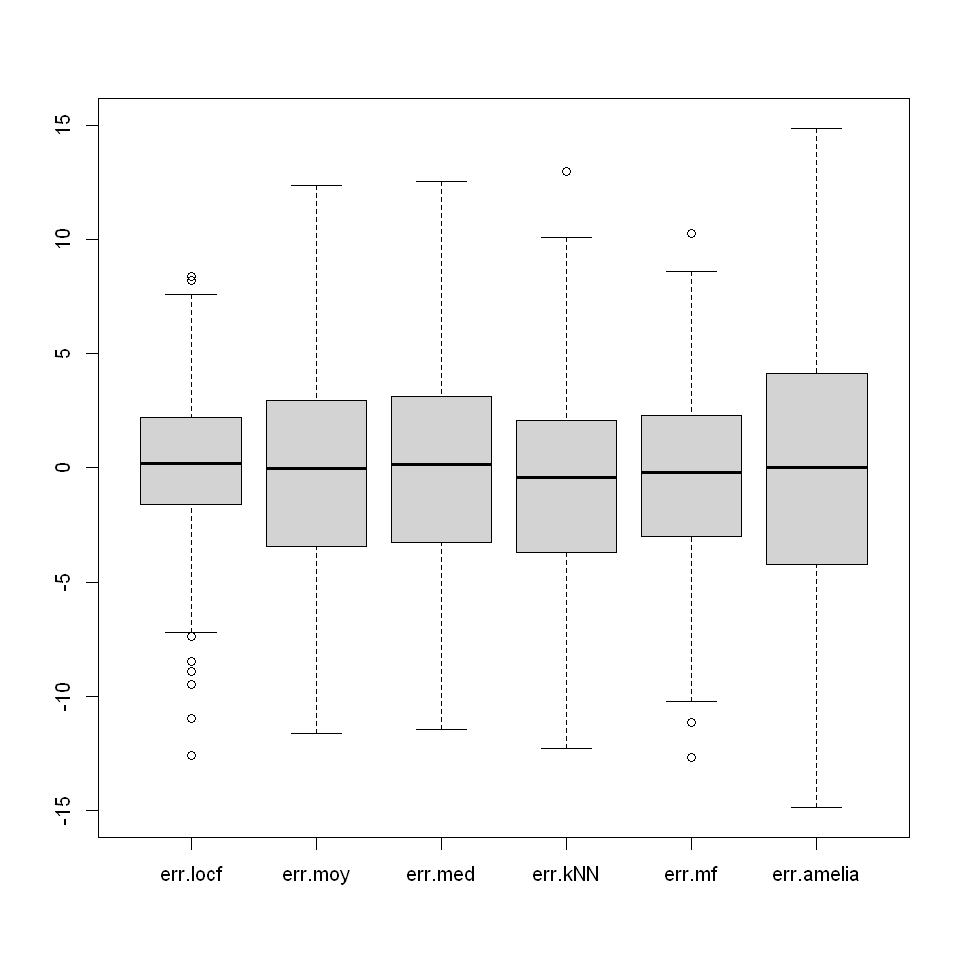

In [180]:
X.amelia=amelia(Xnaquanti,m=1)$imputations$imp1
err.amelia=(Xquanti-X.amelia)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf,err.amelia),ylim=c(-15,15))


**Q.** Que concluez vous ? Quelle méthode vous semble la plus pertinente sur ces données ? 

<font color = "blue"> Sur ces données, la méthode la plus pertinente est err.locf

### Imputation avec MissForest et impact sur la classification ###

On reprend ici le jeu de données complet, incluant les variables explicatives quantitatives. 

Connaissant les "vraies" données initiales, il est possible, dans ce cas de calculer des erreurs d'imputation de `missForest`.

**Q** Quelles sont elles? Quelle estimation de l'erreur est fournie quand les données manquantes le sont vraiment?

In [181]:
help(missForest)

In [182]:
XnaImp=missForest(Xna,xtrue=X) #données imputées (complétées) par missForest

In [183]:
XnaImp$OOBerror;XnaImp$error

NRMSE       PFC 
0.1870217 0.2959369

NRMSE       PFC 
0.2107057 0.3504902

Vérifier que les imputations sont réalisées.

In [184]:
summary(XnaImp$ximp)

 JOUR        MOCAGE          TEMPE       STATION      VentMOD       
 0:739   Min.   : 46.4   Min.   :10.40   Aix:202   Min.   : 0.1414  
 1:302   1st Qu.: 98.3   1st Qu.:20.40   Als:211   1st Qu.: 4.1110  
         Median :126.1   Median :23.90   Cad:199   Median : 5.5227  
         Mean   :127.0   Mean   :23.95   Pla:209   Mean   : 5.9421  
         3rd Qu.:151.5   3rd Qu.:27.50   Ram:220   3rd Qu.: 7.0178  
         Max.   :284.7   Max.   :38.00             Max.   :19.8910  
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.3326   1st Qu.:0.08933   1st Qu.: 0.2599   1st Qu.:-1.4355  
 Median : 0.2450   Median :0.09978   Median : 0.7405   Median :-0.9600  
 Mean   : 0.1550   Mean   :0.10004   Mean   : 0.8411   Mean   :-0.8491  
 3rd Qu.: 0.6328   3rd Qu.:0.11009   3rd Qu.: 1.3835   3rd Qu.:-0.3133  
 Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931   Max.   : 2.2438  

Comme précédemment, l'utilisation de `XGBoost` impose de transformer les facteurs en indicatrices.

In [187]:
library(FactoMineR)
# données complètes
Xd=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
# données avec trous
Xdna=data.frame(tab.disjonctif(Xna[,c(1,4)]),Xna[,-c(1,4)]) 
# données avec imputations
XdnaImp=data.frame(tab.disjonctif(XnaImp$ximp[,c(1,4)]),XnaImp$ximp[,-c(1,4)]) 

La librairie `caret` facilite beaucoup la syntaxe pour l'exécution de `xgboost`. elle est reprise. Il faudrait sinon transformer les données sous un autre format. C'est intégré par `caret`.

Construction des mêmes échantillons d'apprentissage et de test dans les trois cas: données initiales, manquantes, imputées.

In [188]:
library(caret)
# parallélisation
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=Xd[inTrain,]
testDescr=Xd[-inTrain,]
# Les mêmes avec trous
trainDescrNA=Xdna[inTrain,]
testDescrNA=Xdna[-inTrain,]
# Les mêmes avec données manquantes imputées
trainDescrNAimp=XdnaImp[inTrain,]
testDescrNAimp=XdnaImp[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]
cvControl=trainControl(method="cv",number=10)

In [189]:
# prévision avec random forest sur données initiales
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
# Prévision avec XGBoost sur données initiales

#set.seed(2)
#xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
 #              trControl = cvControl)

**Q** Pendant que `XGBoost` tourne, réviser les [principes de cet algorithme](http://wikistat.fr/pdf/st-m-app-agreg.pdf).

In [190]:
# erreur de prévision sur le test avec données initiales
#models=list(rf=rfFit,xgb=xgbFit)
models=list(rf=rfFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

$rf
[1] 0.8888889

In [192]:
# Prévision avec random forest sur données imputées
set.seed(2)
rfFitNAimp = train(trainDescrNAimp, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
# Prévision avec XGBoost sur données imputées

#xgbFitNAimp = train(trainDescrNAimp, trainY,method = "xgbTree", tuneLength = 6,
#               trControl = cvControl)

**Q** Pendant que `XGBoost` tourne, réviser les [principes de missForest](http://wikistat.fr/pdf/st-m-app-idm.pdf).

In [193]:
# erreur de prévision sur le test avec données imputées

#models=list(rfNAimp=rfFitNAimp,xgbNAimp=xgbFitNAimp)

models=list(rfNAimp=rfFitNAimp)
testPred=predict(models, newdata = testDescrNAimp)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

$rfNAimp
[1] 0.8695652

**Q.** Qu'en déduisez vous sur la qualité des résultats après imputation ? Augmenter le taux de données manquantes pour voir l'impact de ce taux sur la qualité de prédiction. 

**FIN DU TP**


### Prévision sans imputation 

La phase d'imputation est rendue obligatoire par l'usage de nombreuses méthodes qui n'acceptent pas les données manquantes. Il peut être intéressant de s'en passer car les informations reconstruites ne sont pas utilisables à d'autres fins; `XGBoost` offre cette oppotunité. Pendant qu'il tourne, [essayer de comprendre](https://arxiv.org/abs/1603.02754) les astuces mises en oeuvre pour tolérer des données manquanres.

In [ ]:
# Prévision avec XGBoost avec données manquantes

#xgbFitNA = train(trainDescrNA, trainY,method = "xgbTree", tuneLength = 6,
 #              trControl = cvControl)

In [ ]:
# Erreur de prévision avec XGBoot tolérant les données manquantes.
#testPred=predict(xgbFitNA, newdata = testDescrNA)
#mean(testPred==testY)

**Q** Comparer les résultats obtenus par les différents stratégies. En tenant compte des temps de calcul, laquelle semble la plus efficace sur ces données. 

*NB* L'utilisation avancée de `XGBoost` nécessite plus de puissance de calcul afin d'affiner le réglage des nombreux paramètres.

**Q** Qu'en serait-il en utlisant Python au lieu de R?

## Détection d'observations atypiques ou anomalies
La détection d'observations *atypiques*, *anomalies* ou *outliers* nommée également *OCC* (*One Class Classification*) ou *novelty detection* est source d'une très abondante bibliographie; voir par exemple [Aggarwal 2016](http://www.charuaggarwal.net/outlierbook.pdf). A ne pas confondre avec les modèles de *valeurs extrêmes*, les valeurs atypiques dans le cas unidimensionnel sont généralement traitées en référence à des modèles paramétriques: gaussien ou autre, qui caractérisent la "normalité". Systématiquement et également dans le cas multidimensionnelle, la notion d'anomalie est définie relativement à un modèle et sous le contrôle d'un paramètre à "régler". Le modèle est paramétrique ou non, local ou global. Par example dans le cas du modèle linéaire, la distance de Cook est un indicateur de points influents ou atypique par rapport au modèle.

R propose quelques librairies et fonctions de détection d'atypiques. 
- [`outliers`](https://cran.r-project.org/web/packages/outliers/outliers.pdf) propose un ensemble de tests univariés.
- [`Rlof`]() propose une version parallélisée du calcul du score LOF (*Local Factor Outlier*). Une estimation locale de la denisité en un point est comparée à celle de ses voisins. 
- [`dbscan`](https://cran.r-project.org/web/packages/dbscan/dbscan.pdf) propose en ples d'algorihtmes de classification non-superviée originaux, le calcul de `glosh` (*Global-Local Outlier Score from Hierarchies*).
- [`kernlab`](http://ftp.auckland.ac.nz/software/CRAN/doc/vignettes/kernlab/kernlab.pdf) propose une option de *One Class Classification SVM* qui cherche à séparer l'origine de l'ensemble des points; `e1071`le propose aussi mais avec des problèmes d'exécution!
- [`randomForest`](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#micro7) estime, dans le cas supervisé lorsque une variable explicative est connue, une notion de "distance" de chaque point avec ses voisins en considérant les co-appartenances des points aux mêmes feuilles des arbres. Dans le cas contraire, comme pour la situation d'OCC, une approche non supervisée consiste à générer tout un ensemble d' observations atypiques avant de construire un modèle prédisant pour chaque observation la variable échantillon initiale *vs.* atypique simulé. La notion précédente de "distance" est à nouveau utilisé comme score d'atypicité.

Quelques cas sont considérés ici.

Ce traitement intervient dans ce tutoriel avec une finalité essentiellement pédagogique. Il n'est pas indispensale sur ces données, relativement cohérentes alors que l'objectif poursuivit n'est pas la recherche d'une défaillance contrairement à une situation du domaine industriel: suivi de fabrication ou de fonctionnement. 

Néanmoins, sur tout jeu de données, l'étape préalable exploratoire peut inclure la recherche d'observations atypiques multidimensionnelles qui permettraient d'identifier des incohérences de mesure en complément des études unidimensionnelles de la première partie.

Considérons quatre approches suivant des principes très différents parmi bien d'autres. Elles vont permettre d'identifier des observations atypiques avant de les représenter dans l'ACP.
### *Local Outlier Factor*
Les données sont restreintes aux seules variables quantitatives explicatives.

**Q** Quel est le rôle du paramètre *k* ci-dessous?

In [ ]:
library(Rlof)
ozoneR=ozone[,-c(1,2,5,11)]
atypLof=lof(ozoneR,k=c(3:7),cores=3)
options(repr.plot.width=8, repr.plot.height=6)
boxplot(atypLof)

In [ ]:
table(atypLof[,1]>1.5,Y)

**Q** Comment intervient la borne 1.5? A quelles classe appartiennent majoritairement les observations jugées atypiques.

In [ ]:
atypLofInd=which(atypLof[,1]>1.5)
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(0.5,length(coul))
acp=princomp(ozoneR,cor=TRUE)
options(repr.plot.width=6, repr.plot.height=6)
coul[atypLofInd]=2
taille[atypLofInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Q** Que dire de la localisation des observations atypiques dans le plan de l'acp?

### *Global-Local Outlier Score from Hierarchies* 
Les scores proches de 1 signalent des atypiques.

In [ ]:
library(dbscan)
atypGlosh=glosh(as.matrix(ozoneR),k=3)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypGlosh)

In [ ]:
table(atypLof[,1]>1.5,atypGlosh>0.82)

**Q** Que dire de ces deux critères?

In [ ]:
atypGloshInd=which(atypGlosh>0.82)
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(0.5,length(coul))
coul[atypGloshInd]=2; taille[atypGloshInd]=.8
options(repr.plot.width=6, repr.plot.height=6)
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

### *One Class Classification SVM*
**Q** Quel est le rôle du paramètre `nu`?

In [ ]:
library(kernlab)
ozoneOcc=ksvm(x=as.matrix(ozoneR),y=NULL,type="one-svc",
              kernel="rbfdot",nu = 0.005)
atypOcc=!fitted(ozoneOcc)
ozoneOcc

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
options(repr.plot.width=6, repr.plot.height=6)
coul[atypOcc]=2
taille[atypOcc]=0.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Q** Même question sir la répartition des observations atypiques.

In [ ]:
table(atypLof[,1]>1.5,atypOcc)

**Q** Comment interpréter la table ci-dessus?

### Anomalies au sens de *random forest*
#### Cas supervisé
La première approche prend en compte la variable explicative et considère donc les observations les plu sen en marge du modèle.

In [ ]:
library(randomForest)
Y=ozone[,11]
X=ozone[,-c(2,11)]
ozoneRF=randomForest(X,Y,proximity=TRUE)
atypRF=outlier(ozoneRF)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypRF)

In [ ]:
atypRFInd=which(atypRF>20)
coul=as.numeric(Y)+2
options(repr.plot.width=8, repr.plot.height=6)
plot(atypRF,type="h",col=coul)
legend("topright",legend=levels(Y),text.col=c(3:4))

In [ ]:
table(atypRF>20,Y)

**Q** Que dire de la répartition des atypiques par rapport à la variable de dépassement de seuil.

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
acp=princomp(ozoneR,cor=TRUE)
options(repr.plot.width=6, repr.plot.height=6)
coul[atypRFInd]=2
taille[atypRFInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Q** Commenter la répartition des atypiques au sens de **Random Forest** supervisée. Serait-il raisonnable de supprimer ces observations ?

**Remarque** Si la variable à expliquer *Y* est telle que l'on soupçonne des possibles erreur de label, ce peut être une façon de les détecter.

#### Cas non-supervisé
Moins connue, Breiman à proposé une version [non-supervisée](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#unsup) de randomForest. Elle fournit *in fine* le même type de critère mais sans faire intervenir *Y*.

In [ ]:
set.seed(11)
ozoneURF <- randomForest(x=ozoneR,y=NULL,proximity=TRUE)
atypURF=outlier(ozoneURF)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypURF)
#MDSplot(ozoneURF, ozone$Depseuil)

In [ ]:
atypURFInd=which(atypURF>2.5)
coul=as.numeric(Y)+2
options(repr.plot.width=8, repr.plot.height=6)
plot(atypURF,type="h",col=coul)
legend("topright",legend=levels(Y),text.col=c(3:4))

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
options(repr.plot.width=6, repr.plot.height=6)
coul[atypURFInd]=2
taille[atypURFInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

In [ ]:
table(atypURF>2.5,atypLof[,1]>1.5)
table(atypURF>2.5,atypOcc)
table(atypLof[,1]>1.5,atypURF>2.5)

**Q** Que dire sur la correspondance entre les trois stratégies de détection d'observations atypiques?

**Q** Qu'est-ce qui psermettrait d'en choisir une parmi les trois ou parmi les très nombreuses autres disponibles dans la littérature?

## Annexe: Fonction de validation croisée *Monte Carlo*
*N* réplications des estimations / prévisions

In [ ]:
pred.autom=function(X,Y,p=1/2,methodes=c("knn",
"rf"),size=c(10,2),xinit=11,N=10,typerr="cv",
number=4,type="raw") {
# Fonction de prévision de N échantillons tests
# par une liste de méthodes de régression
# ou classification (uniquement 2 classes)
# Optimisation des paramètres par validation
# croisée (défaut) ou bootstrap ou... (cf. caret)
# X : matrice ou frame des variables explicatives
# Y : variable cible quantitative ou qualitative
# p : proportion entre apprentissage et test
# methodes : liste des méthodes de rdiscrimination
# size : e grille des paramètres à optimiser
# xinit : générateur de nombres aléatoires
# N : nombre de réplications apprentissage/test
# typerr : "cv" ou "boo" ou "oob"
# number : nombre de répétitions CV ou bootstrap
# pred : liste des matrices de prévision
# type d’erreur
Control=trainControl(method=typerr,number=number)
# initialisation du générateur
set.seed(xinit)
# liste de matrices stockant les prévisions
# une par méthode
inTrain=createDataPartition(Y,p=p,list=FALSE)
ntest=length(Y[-inTrain])
pred=vector("list",length(methodes))
names(pred)=methodes
pred=lapply(pred,function(x)x=matrix(0,
nrow=ntest,ncol=N))
obs=matrix(0,ntest,N)
set.seed(xinit)
for(i in 1:N) {
# N itérations
# indices de l’échantillon d’apprentissage
inTrain=createDataPartition(Y,p=p,list=FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
trainY=Y[inTrain]
testY=Y[-inTrain]
# stockage des observés de testY
obs[,i]=testY
# centrage et réduction des variables
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
testDescr=predict(xTrans,testDescr)
# estimation et optimisation des modèles
# pour chaque méthode de la liste
for(j in 1:length(methodes)) {
# modélisation
modFit = train(trainDescr, trainY,method = methodes[j], tuneLength = size[j],
               trControl = Control)
# prévisions
if (type=="prob")  pred[[j]][,i]=predict(modFit,
newdata = testDescr,type=type)[,1]
else pred[[j]][,i]=predict(modFit,
newdata = testDescr)
}}
list(pred=pred,obs=obs)
# résultats
}